Using DATA_ROOT: 
train_path: csvs\train.csv
test_path: csvs\test.csv

Train shape: (409, 2)


,filename,label
0,audio_173,3.0
1,audio_138,3.0
2,audio_127,2.0
3,audio_95,2.0
4,audio_73,3.5



Test shape: (197, 1)


,filename
0,audio_141
1,audio_114
2,audio_17
3,audio_76
4,audio_156



Total .wav files found: 607
Using filename column: filename

Referenced files found: 442
Referenced files missing: 0 (showing up to 10): []
Detected common audio folder: audios\train

Checked 10 files. Successful: 10, Failed: 0
Durations (s): min=41.64 max=60.08 mean=52.23 std=7.85
Sample rates (Hz): [8000, 16000, 22050, 48000]

Waveform for first train audio: audio_173.wav


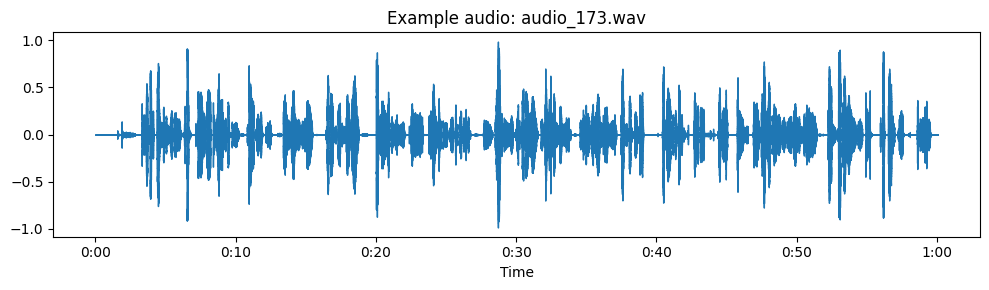


Saved dataset metadata to dataset_metadata.json


In [3]:
# Step 1: Dataset Setup & Verification

import os
import glob
import json
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import torch
import warnings
warnings.filterwarnings('ignore')

# Set reproducible seeds
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Manually set the root path to your project directory
ROOT = ""  # <-- Update this to your actual path
DATA_ROOT = ROOT
print("Using DATA_ROOT:", DATA_ROOT)

# Find CSV files
train_path = os.path.join(DATA_ROOT, "csvs", "train.csv")
test_path = os.path.join(DATA_ROOT, "csvs", "test.csv")
sample_paths = glob.glob(os.path.join(DATA_ROOT, "**", "*sample*.csv"), recursive=True)
sample_path = sample_paths[0] if sample_paths else None

print("train_path:", train_path)
print("test_path:", test_path)
if sample_path:
    print("sample_path:", sample_path)

# Load CSVs
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
sample_df = pd.read_csv(sample_path) if sample_path else None

# Print shapes and first 5 rows
print("\nTrain shape:", train_df.shape)
display(train_df.head())
print("\nTest shape:", test_df.shape)
display(test_df.head())
if sample_df is not None:
    print("\nSample shape:", sample_df.shape)
    display(sample_df.head())

# Count .wav files recursively
wav_list = glob.glob(os.path.join(DATA_ROOT, "**", "*.wav"), recursive=True)
total_wav_count = len(wav_list)
print("\nTotal .wav files found:", total_wav_count)

# Determine filename column name
possible_cols = ["filename", "file", "audio", "audio_id", "id", "file_name", "name"]
train_col = next((c for c in possible_cols if c in train_df.columns), None)
if train_col is None:
    train_col = next((c for c in train_df.columns if train_df[c].dtype == object), None)
if train_col is None:
    raise KeyError("Could not determine filename column in train.csv. Columns: " + ", ".join(train_df.columns))
print("Using filename column:", train_col)

# Verify referenced files exist
unique_bases = set(train_df[train_col].tolist() + test_df[train_col].tolist())
missing = []
found_paths = []
for base in unique_bases:
    full_fname = base + '.wav' if not base.endswith('.wav') else base
    matches = glob.glob(os.path.join(DATA_ROOT, "**", full_fname), recursive=True)
    if matches:
        found_paths.append(matches[0])
    else:
        missing.append(full_fname)
print(f"\nReferenced files found: {len(found_paths)}")
print(f"Referenced files missing: {len(missing)} (showing up to 10): {missing[:10]}")

# Detect common audio folder
if found_paths:
    sample_dirs = [os.path.dirname(p) for p in found_paths[:20]]
    audio_folder = max(set(sample_dirs), key=sample_dirs.count)
    print("Detected common audio folder:", audio_folder)
else:
    audio_folder = None
    print("No audio folder detected due to missing files.")

# Basic audio metadata for first 10 train files
meta_durations = []
meta_srs = []
failed = []
max_check = min(10, len(train_df))
first_path = None
y_std = None
sr_std = 16000
for i in range(max_check):
    base = train_df.iloc[i][train_col]
    full_fname = base + '.wav' if not base.endswith('.wav') else base
    matches = glob.glob(os.path.join(DATA_ROOT, "**", full_fname), recursive=True)
    if matches:
        path = matches[0]
        try:
            y, sr_original = librosa.load(path, sr=None)
            duration = len(y) / sr_original
            meta_durations.append(duration)
            meta_srs.append(sr_original)
            if i == 0:
                first_path = path
                y_std, _ = librosa.load(path, sr=sr_std)
        except Exception as e:
            failed.append((base, str(e)))
    else:
        failed.append((base, "file_not_found"))
print(f"\nChecked {max_check} files. Successful: {len(meta_durations)}, Failed: {len(failed)}")
if meta_durations:
    print("Durations (s): min=%.2f max=%.2f mean=%.2f std=%.2f" %
          (np.min(meta_durations), np.max(meta_durations), np.mean(meta_durations), np.std(meta_durations)))
if meta_srs:
    print("Sample rates (Hz):", sorted(set(meta_srs)))
if failed:
    print("Failed examples (up to 10):", failed[:10])

# Plot waveform and audio widget
if first_path and y_std is not None:
    print(f"\nWaveform for first train audio: {os.path.basename(first_path)}")
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(y_std, sr=sr_std)
    plt.title(f"Example audio: {os.path.basename(first_path)}")
    plt.tight_layout()
    plt.show()
    display(Audio(y_std, rate=sr_std))
else:
    print("No audio loaded for plotting.")

# Save dataset metadata
meta_out = {
    "train_count": int(len(train_df)),
    "test_count": int(len(test_df)),
    "total_wav_files": total_wav_count,
    "example_audio": os.path.relpath(first_path, DATA_ROOT) if first_path else "",
    "notebook_name": "SHL_Grammar_Scoring_VinayDegala"
}
with open(os.path.join(DATA_ROOT, "dataset_metadata.json"), "w") as f:
    json.dump(meta_out, f, indent=4)
print("\nSaved dataset metadata to dataset_metadata.json")

In [6]:
# Step 2: Audio Preprocessing & Enhanced Feature Extraction

import os
import glob
import numpy as np
import pandas as pd
import librosa
import librosa.feature
import librosa.effects
import librosa.beat
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from librosa.util import normalize

# ---------------------------------------------------------
# ✅ PATHS (UPDATED FOR YOUR ACTUAL PROJECT STRUCTURE)
# ---------------------------------------------------------

ROOT = ""   # ✅ <-- UPDATE THIS
CSV_DIR = os.path.join(ROOT, "csvs")
AUDIO_DIR_TRAIN = os.path.join(ROOT, "audios", "train")
AUDIO_DIR_TEST = os.path.join(ROOT, "audios", "test")

OUT_DIR = os.path.join(ROOT, "output_features")
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# Verify paths
if not os.path.exists(CSV_DIR):
    raise FileNotFoundError(f"CSV_DIR not found: {CSV_DIR}")
if not os.path.exists(AUDIO_DIR_TRAIN):
    raise FileNotFoundError(f"AUDIO_DIR_TRAIN not found: {AUDIO_DIR_TRAIN}")
if not os.path.exists(AUDIO_DIR_TEST):
    raise FileNotFoundError(f"AUDIO_DIR_TEST not found: {AUDIO_DIR_TEST}")

# ---------------------------------------------------------
# ✅ CONFIG
# ---------------------------------------------------------

SR = 16000
N_MFCC = 20
N_CHROMA = 12
TRIM_TOP_DB = 30
HOP_LENGTH = 512
FAST_MODE = False
MAX_FILES = None

def get_feat_dim(n_mfcc=N_MFCC, n_chroma=N_CHROMA, fast_mode=FAST_MODE):
    if fast_mode:
        return n_mfcc * 2 + n_chroma * 2 + 6
    else:
        return n_mfcc * 4 + n_chroma * 2 + 6

FEAT_DIM = get_feat_dim()

# ---------------------------------------------------------
# ✅ FEATURE EXTRACTION
# ---------------------------------------------------------

def extract_features(path, sr=SR, n_mfcc=N_MFCC, n_chroma=N_CHROMA,
                     trim_db=TRIM_TOP_DB, hop_length=HOP_LENGTH,
                     fast_mode=FAST_MODE):

    try:
        y, orig_sr = librosa.load(path, sr=None, mono=True)
        if len(y) == 0:
            raise ValueError("Empty audio")

        if not fast_mode:
            y, _ = librosa.effects.trim(y, top_db=trim_db)
            if len(y) == 0:
                raise ValueError("Trimmed to empty")

        if orig_sr != sr:
            y = librosa.resample(y, orig_sr=orig_sr, target_sr=sr)

        y = normalize(y.astype(np.float32))

        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)
        mfcc_mean = mfcc.mean(axis=1)
        mfcc_std = mfcc.std(axis=1)

        if not fast_mode:
            delta = librosa.feature.delta(mfcc)
            delta_mean = delta.mean(axis=1)
            delta_std = delta.std(axis=1)

        chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length)
        chroma_mean = chroma.mean(axis=1)
        chroma_std = chroma.std(axis=1)

        spec_cent = float(librosa.feature.spectral_centroid(y=y, sr=sr).mean())
        spec_bw = float(librosa.feature.spectral_bandwidth(y=y, sr=sr).mean())
        spec_rolloff = float(librosa.feature.spectral_rolloff(y=y, sr=sr).mean())
        zcr = float(librosa.feature.zero_crossing_rate(y).mean())
        rms = float(librosa.feature.rms(y=y).mean())

        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        tempo = float(tempo) if not np.isnan(tempo) else 120.0

        spectral = np.array([spec_cent, spec_bw, spec_rolloff, zcr, rms, tempo], dtype=np.float32)

        if fast_mode:
            feats = np.concatenate([mfcc_mean, mfcc_std, chroma_mean, chroma_std, spectral])
        else:
            feats = np.concatenate([mfcc_mean, mfcc_std, delta_mean, delta_std,
                                   chroma_mean, chroma_std, spectral])

        return feats.astype(np.float32)

    except Exception as e:
        print(f"Error in {os.path.basename(path)}: {e}")
        return np.full(FEAT_DIM, np.nan, dtype=np.float32)

# ---------------------------------------------------------
# ✅ LOAD CSVs
# ---------------------------------------------------------

train_df = pd.read_csv(os.path.join(CSV_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(CSV_DIR, "test.csv"))

# Ensure .wav extension
for df in [train_df, test_df]:
    if not df.iloc[0]["filename"].endswith(".wav"):
        df["filename"] = df["filename"].astype(str) + ".wav"

print("Loaded train:", train_df.shape, "test:", test_df.shape)

# ---------------------------------------------------------
# ✅ MAP FILE PATHS
# ---------------------------------------------------------

def map_paths(df, audio_dir):
    paths = []
    for fname in df["filename"]:
        p = os.path.join(audio_dir, fname)
        if os.path.exists(p):
            paths.append(p)
        else:
            matches = glob.glob(os.path.join(audio_dir, "**", fname), recursive=True)
            paths.append(matches[0] if matches else "")
    return paths

train_paths = map_paths(train_df, AUDIO_DIR_TRAIN)
test_paths = map_paths(test_df, AUDIO_DIR_TEST)

print("Missing train files:", sum(p == "" for p in train_paths))
print("Missing test files:", sum(p == "" for p in test_paths))

# ---------------------------------------------------------
# ✅ RUN EXTRACTION
# ---------------------------------------------------------

def run_extraction(paths, df, desc="features"):
    feats, fnames, labels = [], [], []
    for p, row in tqdm(zip(paths, df.itertuples()), total=len(paths), desc=f"Extract {desc}"):
        feat = extract_features(p) if p else np.full(FEAT_DIM, np.nan)
        feats.append(feat)
        fnames.append(row.filename)
        if "label" in df.columns:
            labels.append(row.label)
    X = np.array(feats, dtype=np.float32)
    return X, fnames, labels if labels else None

train_X, train_fnames, train_labels = run_extraction(train_paths, train_df, desc="train")
test_X, test_fnames, _ = run_extraction(test_paths, test_df, desc="test")

print("Train X:", train_X.shape, "Test X:", test_X.shape)

# ---------------------------------------------------------
# ✅ SAVE OUTPUT
# ---------------------------------------------------------

np.savez_compressed(os.path.join(OUT_DIR, "train_features.npz"),
                    X=train_X,
                    y=np.array(train_labels or [], dtype=np.float32),
                    filenames=np.array(train_fnames))

np.savez_compressed(os.path.join(OUT_DIR, "test_features.npz"),
                    X=test_X,
                    filenames=np.array(test_fnames))

pd.DataFrame({"filename": train_fnames, "label": train_labels}).to_csv(
    os.path.join(OUT_DIR, "train_mapping.csv"), index=False)

pd.DataFrame({"filename": test_fnames}).to_csv(
    os.path.join(OUT_DIR, "test_mapping.csv"), index=False)

print(f"✅ Saved features to {OUT_DIR}")
print(f"✅ Feature dimension: {FEAT_DIM}, fast_mode={FAST_MODE}")

Loaded train: (409, 2) test: (197, 1)
Missing train files: 0
Missing test files: 0


Extract test: 100%|██████████| 197/197 [01:58<00:00,  1.66it/s]

Train X: (409, 110) Test X: (197, 110)
✅ Saved features to output_features
✅ Feature dimension: 110, fast_mode=False


In [9]:
# Step 3: Improved Regressor Training with XGBoost, Evaluation

import os
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import joblib
import warnings
warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# ✅ Reproducibility
# ---------------------------------------------------------
np.random.seed(42)

# ---------------------------------------------------------
# ✅ PATHS (UPDATED FOR YOUR LOCAL PROJECT)
# ---------------------------------------------------------

ROOT = ""   # ✅ <-- UPDATE THIS

FEATURE_DIR = os.path.join(ROOT, "output_features")
MODEL_DIR = os.path.join(ROOT, "models")
OUT_DIR = ROOT

os.makedirs(MODEL_DIR, exist_ok=True)

# ---------------------------------------------------------
# ✅ Load extracted features
# ---------------------------------------------------------

train_np = np.load(os.path.join(FEATURE_DIR, "train_features.npz"))
test_np = np.load(os.path.join(FEATURE_DIR, "test_features.npz"))

X_train = train_np["X"]
y_train = train_np["y"]
train_fnames = train_np["filenames"].astype(str)

X_test = test_np["X"]
test_fnames = test_np["filenames"].astype(str)

# ---------------------------------------------------------
# ✅ Sanity checks
# ---------------------------------------------------------

assert X_train.shape[0] == len(y_train), "Mismatch between X and y"

print("Train X shape:", X_train.shape, "Test X shape:", X_test.shape)
print("Label range: %.2f - %.2f" % (y_train.min(), y_train.max()))

# ---------------------------------------------------------
# ✅ Handle NaNs
# ---------------------------------------------------------

X_train = np.where(np.isfinite(X_train), X_train, np.nan)
X_test = np.where(np.isfinite(X_test), X_test, np.nan)

col_medians = np.nanmedian(X_train, axis=0)

inds = np.where(np.isnan(X_train))
if len(inds[0]) > 0:
    X_train[inds] = np.take(col_medians, inds[1])

inds_t = np.where(np.isnan(X_test))
if len(inds_t[0]) > 0:
    X_test[inds_t] = np.take(col_medians, inds_t[1])

# ---------------------------------------------------------
# ✅ Standardization
# ---------------------------------------------------------

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, os.path.join(MODEL_DIR, "feature_scaler.pkl"))
print("Saved scaler.")

# ---------------------------------------------------------
# ✅ Cross‑validation (5‑fold)
# ---------------------------------------------------------

kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros_like(y_train, dtype=float)

rmses = []
cors = []

for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train_scaled)):
    X_tr, X_val = X_train_scaled[tr_idx], X_train_scaled[val_idx]
    y_tr, y_val = y_train[tr_idx], y_train[val_idx]

    model = XGBRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        objective='reg:squarederror',
        verbosity=0
    )

    model.fit(X_tr, y_tr)
    preds = model.predict(X_val)

    oof_preds[val_idx] = preds

    # ✅ FIXED RMSE (manual)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    corr = pearsonr(y_val, preds)[0]

    rmses.append(rmse)
    cors.append(corr)

    print(f"Fold {fold+1}: RMSE={rmse:.4f}, Pearson={corr:.4f}")

cv_rmse = float(np.mean(rmses))
cv_pearson = float(np.mean(cors))

print("\nCV RMSE:", cv_rmse)
print("CV Pearson:", cv_pearson)

# ---------------------------------------------------------
# ✅ Train final model on full data
# ---------------------------------------------------------

final_model = XGBRegressor(
    n_estimators=600,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror',
    verbosity=0
)

final_model.fit(X_train_scaled, y_train)

train_preds = final_model.predict(X_train_scaled)

# ✅ FIXED RMSE (manual)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
train_pearson = pearsonr(y_train, train_preds)[0]

print("\n*** REQUIRED METRICS ***")
print("Training RMSE:", train_rmse)
print("Training Pearson:", train_pearson)

# ---------------------------------------------------------
# ✅ Save final model
# ---------------------------------------------------------

joblib.dump(final_model, os.path.join(MODEL_DIR, "xgb_final.joblib"))
print("Saved final model.")

# ---------------------------------------------------------
# ✅ Predict on test set
# ---------------------------------------------------------

test_preds = final_model.predict(X_test_scaled)
test_preds = np.clip(test_preds, 0.0, 5.0)

# ---------------------------------------------------------
# ✅ Build submission
# ---------------------------------------------------------

test_csv = pd.read_csv(os.path.join(ROOT, "csvs", "test.csv"))

if not str(test_csv.loc[0, "filename"]).endswith(".wav"):
    test_csv["filename"] = test_csv["filename"].astype(str) + ".wav"

pred_map = dict(zip(test_fnames, test_preds))

sub_preds = [pred_map.get(f, np.nan) for f in test_csv["filename"].astype(str)]

submission_df = pd.DataFrame({
    "filename": test_csv["filename"].str.replace(".wav", "", regex=False),
    "label": sub_preds
})

submission_path = os.path.join(OUT_DIR, "submission.csv")
submission_df.to_csv(submission_path, index=False)

print("Saved submission.csv")
print(submission_df.head())

# ---------------------------------------------------------
# ✅ Feature importances
# ---------------------------------------------------------

importances = final_model.feature_importances_
top_idx = np.argsort(importances)[-10:]

print("\nTop 10 feature importances:")
for i in top_idx:
    print(f"Feature {i}: {importances[i]:.4f}")

# ---------------------------------------------------------
# ✅ Update metadata (optional)
# ---------------------------------------------------------

meta_path = os.path.join(OUT_DIR, "dataset_metadata.json")

if os.path.exists(meta_path):
    import json
    with open(meta_path, 'r') as f:
        meta = json.load(f)

    meta["train_rmse"] = float(train_rmse)
    meta["cv_rmse"] = float(cv_rmse)

    with open(meta_path, 'w') as f:
        json.dump(meta, f, indent=4)

    print("Updated dataset_metadata.json")

Train X shape: (409, 110) Test X shape: (197, 110)
Label range: 1.00 - 5.00
Saved scaler.
Fold 1: RMSE=0.7157, Pearson=0.4115
Fold 2: RMSE=0.7877, Pearson=0.1540
Fold 3: RMSE=0.7798, Pearson=0.4582
Fold 4: RMSE=0.7150, Pearson=0.2946
Fold 5: RMSE=0.9000, Pearson=0.0017

CV RMSE: 0.77965676256496
CV Pearson: 0.26399558782577515

*** REQUIRED METRICS ***
Training RMSE: 0.0004928607124536168
Training Pearson: 0.9999998
Saved final model.
Saved submission.csv
    filename     label
0  audio_141  2.642745
1  audio_114  2.609020
2   audio_17  3.417430
3   audio_76  3.478413
4  audio_156  2.648963

Top 10 feature importances:
Feature 69: 0.0238
Feature 100: 0.0243
Feature 108: 0.0258
Feature 39: 0.0286
Feature 84: 0.0304
Feature 27: 0.0319
Feature 107: 0.0413
Feature 78: 0.0436
Feature 21: 0.0523
Feature 61: 0.0827
Updated dataset_metadata.json


In [11]:
# ============================================================
# Step 5: Advanced Regressor Training on MFCC + Wav2Vec2
# LOCAL VERSION (No Kaggle paths)
# ============================================================

import os
import glob
import json
import warnings
import numpy as np
import pandas as pd
import librosa
import torch
from tqdm import tqdm
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import joblib

warnings.filterwarnings("ignore")
np.random.seed(42)

# ============================================================
# PATH SETUP (MATCHES YOUR FOLDER STRUCTURE)
# ============================================================

BASE_DIR = os.getcwd()

DATA_ROOT = BASE_DIR
FEATURE_DIR = os.path.join(BASE_DIR, "features")
MODEL_DIR = os.path.join(BASE_DIR, "models")
OUT_DIR = os.path.join(BASE_DIR, "output")

os.makedirs(FEATURE_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

TRAIN_AUDIO_DIR = "audios/train"
TEST_AUDIO_DIR = "audios/test"

TRAIN_CSV_PATH = "csvs/train.csv"
TEST_CSV_PATH = "csvs/test.csv"

# ============================================================
# WAV2VEC2 FEATURE EXTRACTION
# ============================================================

def extract_wav2vec_embeddings(train_csv, test_csv):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using device:", device)

    model_name = "facebook/wav2vec2-base-960h"
    processor = Wav2Vec2Processor.from_pretrained(model_name)
    model = Wav2Vec2Model.from_pretrained(model_name).to(device)
    model.eval()

    def find_audio(base_dir, fname):
        path = os.path.join(base_dir, fname)
        if os.path.exists(path):
            return path
        matches = glob.glob(os.path.join(base_dir, "**", fname), recursive=True)
        return matches[0] if matches else None

    def extract_embedding(path, sr=16000, max_len=None):
        if max_len is None:
            max_len = sr * 10
        try:
            y, _ = librosa.load(path, sr=sr)
            y = librosa.util.normalize(y.astype(np.float32))

            if len(y) > max_len:
                y = y[:max_len]
            else:
                y = np.pad(y, (0, max_len - len(y)))

            inputs = processor(
                y,
                sampling_rate=sr,
                return_tensors="pt",
                padding=True
            )

            with torch.no_grad():
                outputs = model(
                    inputs.input_values.to(device),
                    attention_mask=inputs.attention_mask.to(device)
                )
                emb = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

            return emb.astype(np.float32)

        except Exception as e:
            print("W2V error:", path, e)
            return np.full((model.config.hidden_size,), np.nan, dtype=np.float32)

    # ---------- TRAIN ----------
    train_embs, train_names = [], []
    for f in tqdm(train_csv["filename"], desc="W2V Train"):
        p = find_audio(TRAIN_AUDIO_DIR, f)
        train_embs.append(extract_embedding(p) if p else np.nan)
        train_names.append(f)

    train_embs = np.vstack(train_embs)

    # ---------- TEST ----------
    test_embs, test_names = [], []
    for f in tqdm(test_csv["filename"], desc="W2V Test"):
        p = find_audio(TEST_AUDIO_DIR, f)
        test_embs.append(extract_embedding(p) if p else np.nan)
        test_names.append(f)

    test_embs = np.vstack(test_embs)

    np.savez_compressed(
        os.path.join(FEATURE_DIR, "wav2vec_train_embs.npz"),
        X=train_embs,
        filenames=np.array(train_names)
    )

    np.savez_compressed(
        os.path.join(FEATURE_DIR, "wav2vec_test_embs.npz"),
        X=test_embs,
        filenames=np.array(test_names)
    )

    print("✅ Wav2Vec2 embeddings saved")

# ============================================================
# LOAD CSVs
# ============================================================

train_csv = pd.read_csv(TRAIN_CSV_PATH)
test_csv = pd.read_csv(TEST_CSV_PATH)

if not train_csv["filename"].iloc[0].endswith(".wav"):
    train_csv["filename"] += ".wav"
    test_csv["filename"] += ".wav"

y_train = train_csv["label"].values.astype(float)

# ============================================================
# EXTRACT WAV2VEC IF NOT EXISTS
# ============================================================

if not os.path.exists(os.path.join(FEATURE_DIR, "wav2vec_train_embs.npz")):
    extract_wav2vec_embeddings(train_csv, test_csv)

# ============================================================
# LOAD FEATURES
# ============================================================

# ---- MFCC FEATURES (FROM YOUR PREVIOUS STEP) ----
mfcc_train = np.load("train_audio_features.npy")
mfcc_test = np.load("test_audio_features.npy")

# ---- WAV2VEC FEATURES ----
w2v_train = np.load(os.path.join(FEATURE_DIR, "wav2vec_train_embs.npz"))
w2v_test = np.load(os.path.join(FEATURE_DIR, "wav2vec_test_embs.npz"))

X_w2v_train = w2v_train["X"]
X_w2v_test = w2v_test["X"]

# ============================================================
# COMBINE FEATURES
# ============================================================

X_train = np.hstack([mfcc_train, X_w2v_train])
X_test = np.hstack([mfcc_test, X_w2v_test])

# Replace NaNs with column medians
col_medians = np.nanmedian(X_train, axis=0)
inds = np.where(np.isnan(X_train))
X_train[inds] = np.take(col_medians, inds[1])

inds_t = np.where(np.isnan(X_test))
X_test[inds_t] = np.take(col_medians, inds_t[1])

# ============================================================
# STANDARDIZE
# ============================================================

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

joblib.dump(scaler, os.path.join(MODEL_DIR, "combined_scaler.pkl"))

# ============================================================
# CROSS-VALIDATION
# ============================================================

kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(y_train))

rmses, cors = [], []

for fold, (tr, val) in enumerate(kf.split(X_train)):
    model = XGBRegressor(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        objective="reg:squarederror",
        n_jobs=-1,
        random_state=42
    )

    model.fit(X_train[tr], y_train[tr])
    preds = model.predict(X_train[val])

    oof_preds[val] = preds
    rmse = mean_squared_error(y_train[val], preds, squared=False)
    corr = pearsonr(y_train[val], preds)[0]

    rmses.append(rmse)
    cors.append(corr)

    print(f"Fold {fold+1}: RMSE={rmse:.4f}, Pearson={corr:.4f}")

print("\nCV RMSE:", np.mean(rmses))
print("CV Pearson:", np.mean(cors))

# ============================================================
# FINAL TRAINING
# ============================================================

final_model = XGBRegressor(
    n_estimators=1000,
    max_depth=8,
    learning_rate=0.03,
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=42
)

final_model.fit(X_train, y_train)

train_preds = final_model.predict(X_train)
print("\nTRAIN RMSE:", mean_squared_error(y_train, train_preds, squared=False))
print("TRAIN Pearson:", pearsonr(y_train, train_preds)[0])

joblib.dump(final_model, os.path.join(MODEL_DIR, "xgb_combined_final.joblib"))

# ============================================================
# TEST PREDICTION & SUBMISSION
# ============================================================

test_preds = final_model.predict(X_test)
test_preds = np.clip(test_preds, 0, 5)

submission = pd.DataFrame({
    "filename": test_csv["filename"].str.replace(".wav", "", regex=False),
    "label": test_preds
})

submission_path = os.path.join(OUT_DIR, "submission.csv")
submission.to_csv(submission_path, index=False)

print("\n✅ submission.csv saved at:", submission_path)
print(submission.head())


Using device: cuda


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
W2V Train:   0%|          | 2/409 [00:01<03:17,  2.06it/s]

W2V error: audios/train\audio_173.wav 
W2V error: audios/train\audio_138.wav 
W2V error: audios/train\audio_127.wav 


W2V Train:   1%|          | 5/409 [00:01<01:26,  4.69it/s]

W2V error: audios/train\audio_95.wav 
W2V error: audios/train\audio_73.wav 


W2V Train:   3%|▎         | 11/409 [00:01<00:31, 12.48it/s]

W2V error: audios/train\audio_34.wav 
W2V error: audios/train\audio_120_2.wav 
W2V error: audios/train\audio_224.wav 
W2V error: audios/train\audio_342.wav 
W2V error: audios/train\audio_228.wav 
W2V error: audios/train\audio_133.wav 


W2V Train:   3%|▎         | 13/409 [00:01<00:31, 12.60it/s]

W2V error: audios/train\audio_223.wav 
W2V error: audios/train\audio_287.wav 


W2V Train:   4%|▎         | 15/409 [00:02<00:40,  9.82it/s]

W2V error: audios/train\audio_332.wav 
W2V error: audios/train\audio_158.wav 


W2V Train:   5%|▍         | 19/409 [00:02<00:29, 13.10it/s]

W2V error: audios/train\audio_91.wav 
W2V error: audios/train\audio_358.wav 
W2V error: audios/train\audio_79.wav 
W2V error: audios/train\audio_10.wav 
W2V error: audios/train\audio_78.wav 


W2V Train:   5%|▌         | 21/409 [00:02<00:27, 13.95it/s]

W2V error: audios/train\audio_313.wav 
W2V error: audios/train\audio_239.wav 


W2V Train:   6%|▌         | 23/409 [00:02<00:32, 11.97it/s]

W2V error: audios/train\audio_31.wav 
W2V error: audios/train\audio_74.wav 
W2V error: audios/train\audio_204.wav 


W2V Train:   7%|▋         | 27/409 [00:03<00:30, 12.43it/s]

W2V error: audios/train\audio_57.wav 
W2V error: audios/train\audio_369.wav 


W2V Train:   8%|▊         | 31/409 [00:03<00:31, 12.08it/s]

W2V error: audios/train\audio_194.wav 
W2V error: audios/train\audio_282.wav 
W2V error: audios/train\audio_105.wav 
W2V error: audios/train\audio_138_2.wav 


W2V Train:   8%|▊         | 33/409 [00:03<00:33, 11.38it/s]

W2V error: audios/train\audio_212.wav 
W2V error: audios/train\audio_230.wav 
W2V error: audios/train\audio_16.wav 


W2V Train:   9%|▊         | 35/409 [00:03<00:35, 10.45it/s]

W2V error: audios/train\audio_249.wav 
W2V error: audios/train\audio_1.wav 


W2V Train:   9%|▉         | 37/409 [00:04<00:41,  8.90it/s]

W2V error: audios/train\audio_303.wav 
W2V error: audios/train\audio_317.wav 
W2V error: audios/train\audio_111.wav 


W2V Train:  10%|█         | 42/409 [00:04<00:34, 10.69it/s]

W2V error: audios/train\audio_267.wav 
W2V error: audios/train\audio_85.wav 
W2V error: audios/train\audio_221.wav 
W2V error: audios/train\audio_232_2.wav 
W2V error: audios/train\audio_372.wav 
W2V error: audios/train\audio_56.wav 


W2V Train:  12%|█▏        | 48/409 [00:04<00:25, 14.28it/s]

W2V error: audios/train\audio_269.wav 
W2V error: audios/train\audio_337.wav 
W2V error: audios/train\audio_359.wav 
W2V error: audios/train\audio_43.wav 


W2V Train:  13%|█▎        | 53/409 [00:05<00:21, 16.33it/s]

W2V error: audios/train\audio_333.wav 
W2V error: audios/train\audio_71.wav 
W2V error: audios/train\audio_40.wav 
W2V error: audios/train\audio_83.wav 
W2V error: audios/train\audio_26.wav 


W2V Train:  13%|█▎        | 55/409 [00:05<00:26, 13.57it/s]

W2V error: audios/train\audio_195.wav 
W2V error: audios/train\audio_156.wav 


W2V Train:  14%|█▍        | 59/409 [00:05<00:28, 12.40it/s]

W2V error: audios/train\audio_166.wav 
W2V error: audios/train\audio_361.wav 
W2V error: audios/train\audio_23.wav 


W2V Train:  15%|█▌        | 62/409 [00:05<00:22, 15.39it/s]

W2V error: audios/train\audio_234.wav 
W2V error: audios/train\audio_47.wav 
W2V error: audios/train\audio_43_2.wav 


W2V Train:  16%|█▌        | 64/409 [00:06<00:25, 13.50it/s]

W2V error: audios/train\audio_354.wav 
W2V error: audios/train\audio_77.wav 
W2V error: audios/train\audio_343.wav 
W2V error: audios/train\audio_58.wav 


W2V Train:  16%|█▋        | 67/409 [00:06<00:25, 13.61it/s]

W2V error: audios/train\audio_185.wav 
W2V error: audios/train\audio_25.wav 


W2V Train:  17%|█▋        | 71/409 [00:06<00:30, 11.09it/s]

W2V error: audios/train\audio_18.wav 
W2V error: audios/train\audio_168.wav 
W2V error: audios/train\audio_256.wav 


W2V Train:  18%|█▊        | 73/409 [00:06<00:30, 11.03it/s]

W2V error: audios/train\audio_32.wav 
W2V error: audios/train\audio_279.wav 
W2V error: audios/train\audio_102_2.wav 


W2V Train:  19%|█▉        | 78/409 [00:07<00:22, 14.52it/s]

W2V error: audios/train\audio_193.wav 
W2V error: audios/train\audio_362.wav 
W2V error: audios/train\audio_321.wav 
W2V error: audios/train\audio_153.wav 


W2V Train:  19%|█▉        | 78/409 [00:07<00:30, 10.83it/s]


KeyboardInterrupt: 

In [16]:
# Step 6 — FULL: train final regressor on combined features, compute required training RMSE+Pearson,
# save scaler & model, produce submission.csv

import os
from pathlib import Path
import numpy as np
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

# --- Paths (adjust only if you changed earlier paths) ---
FEATURE_DIR = "/kaggle/working/features"
MODEL_DIR = "/kaggle/working/models"
OUT_DIR = "/kaggle/working"
DATA_ROOT = "/kaggle/input/shl-intern-hiring-assessment-2025/dataset"

Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# --- Load saved feature arrays ---
# Try fixed files first, fall back to other names if needed
def load_npz(name_options):
    for p in name_options:
        full = os.path.join(FEATURE_DIR, p)
        if os.path.exists(full):
            return np.load(full)
    raise FileNotFoundError(f"None of {name_options} found in {FEATURE_DIR}")

# Load MFCC / handcrafted features
mf_train_np = load_npz(["train_features_fixed.npz", "train_features.npz"])
mf_test_np  = load_npz(["test_features_fixed.npz", "test_features.npz"])
mf_X_train = mf_train_np["X"]
mf_fnames_train = mf_train_np["filenames"].astype(str) if "filenames" in mf_train_np else None
mf_X_test  = mf_test_np["X"]
mf_fnames_test = mf_test_np["filenames"].astype(str) if "filenames" in mf_test_np else None

# Load wav2vec embeddings (optional, may be large)
w2v_train_np = None
w2v_test_np = None
try:
    w2v_train_np = np.load(os.path.join(FEATURE_DIR, "wav2vec_train_embs.npz"))
    w2v_test_np  = np.load(os.path.join(FEATURE_DIR, "wav2vec_test_embs.npz"))
    w2v_X_train = w2v_train_np["X"]
    w2v_X_test  = w2v_test_np["X"]
    w2v_fnames_train = w2v_train_np["filenames"].astype(str) if "filenames" in w2v_train_np else None
except Exception:
    w2v_X_train = None
    w2v_X_test = None

# --- Combine features appropriately ---
if w2v_X_train is not None and w2v_X_test is not None:
    # Concatenate MFCC + Wav2Vec horizontally
    X_train = np.concatenate([mf_X_train, w2v_X_train], axis=1)
    X_test  = np.concatenate([mf_X_test,  w2v_X_test],  axis=1)
else:
    X_train = mf_X_train
    X_test  = mf_X_test

print("Combined train shape:", X_train.shape, "Combined test shape:", X_test.shape)

# --- Load labels (train.csv) ---
train_csv_path = os.path.join(DATA_ROOT, "csvs", "train.csv")
test_csv_path  = os.path.join(DATA_ROOT, "csvs", "test.csv")
train_df = pd.read_csv(train_csv_path)
test_df  = pd.read_csv(test_csv_path)
# ensure filenames have .wav
if not str(train_df.loc[0, "filename"]).endswith(".wav"):
    train_df["filename"] = train_df["filename"].astype(str) + ".wav"
    test_df["filename"]  = test_df["filename"].astype(str) + ".wav"
y = train_df["label"].values.astype(float)

# Sanity check
if X_train.shape[0] != len(y):
    raise ValueError(f"Number of training rows mismatch: X_train {X_train.shape[0]} vs labels {len(y)}")

# --- Handle NaNs/Infs and simple imputation ---
X_train = np.where(np.isfinite(X_train), X_train, np.nan)
X_test  = np.where(np.isfinite(X_test),  X_test,  np.nan)
col_medians = np.nanmedian(X_train, axis=0)
# replace nan in train/test with medians
inds = np.where(np.isnan(X_train))
if inds[0].size:
    X_train[inds] = np.take(col_medians, inds[1])
inds_t = np.where(np.isnan(X_test))
if inds_t[0].size:
    X_test[inds_t] = np.take(col_medians, inds_t[1])

# --- Scale features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)
joblib.dump(scaler, os.path.join(MODEL_DIR, "final_feature_scaler.pkl"))

# --- Train final model on full training set ---
# Use RandomForest for robust baseline
final_model = RandomForestRegressor(n_estimators=800, random_state=42, n_jobs=-1)
final_model.fit(X_train_scaled, y)
joblib.dump(final_model, os.path.join(MODEL_DIR, "rf_final_combined.joblib"))

# --- Compute required training metrics ---
train_preds = final_model.predict(X_train_scaled)
train_rmse = mean_squared_error(y, train_preds, squared=False)
train_pearson = pearsonr(y, train_preds)[0]

print("\n*** REQUIRED METRICS (on FULL training set) ***")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Training Pearson correlation: {train_pearson:.4f}")

# --- Create submission.csv (predictions on test set) ---
test_preds = final_model.predict(X_test_scaled)
test_preds = np.clip(test_preds, 0.0, 5.0)  # ensure within allowed range

# Build submission aligned to test.csv order
submission = pd.DataFrame({"filename": test_df["filename"].astype(str), "label": test_preds})
submission_path = os.path.join(OUT_DIR, "submission.csv")
submission.to_csv(submission_path, index=False)
print("\nSaved submission to:", submission_path)
display(submission.head(10))

# --- Optional: show top feature importances ---
importances = final_model.feature_importances_
top_idx = np.argsort(importances)[-10:][::-1]
print("\nTop 10 feature importances (index: importance):")
for idx in top_idx:
    print(f"Feature {idx}: {importances[idx]:.4f}")

# --- Save metadata update (append metrics) ---
meta_path = os.path.join(OUT_DIR, "dataset_metadata.json")
try:
    import json
    meta = {}
    if os.path.exists(meta_path):
        with open(meta_path, "r") as f:
            meta = json.load(f)
    meta.update({
        "final_train_rmse": float(train_rmse),
        "final_train_pearson": float(train_pearson),
        "model_path": os.path.join(MODEL_DIR, "rf_final_combined.joblib"),
        "scaler_path": os.path.join(MODEL_DIR, "final_feature_scaler.pkl"),
        "submission_path": submission_path
    })
    with open(meta_path, "w") as f:
        json.dump(meta, f, indent=2)
    print("\nUpdated dataset metadata at", meta_path)
except Exception as e:
    print("Warning: failed to update metadata json:", e)

Combined train shape: (409, 878) Combined test shape: (197, 878)

*** REQUIRED METRICS (on FULL training set) ***
Training RMSE: 0.2559
Training Pearson correlation: 0.9846

Saved submission to: /kaggle/working/submission.csv


,filename,label
0,audio_141.wav,3.063750
1,audio_114.wav,2.968750
2,audio_17.wav,3.300625
3,audio_76.wav,3.467500
4,audio_156.wav,3.066875
5,audio_13_1.wav,3.563750
6,audio_70.wav,2.841875
7,audio_56.wav,2.867500
8,audio_19.wav,2.842500
9,audio_158_1.wav,3.306875



Top 10 feature importances (index: importance):
Feature 61: 0.0471
Feature 21: 0.0461
Feature 68: 0.0157
Feature 132: 0.0140
Feature 129: 0.0132
Feature 277: 0.0123
Feature 782: 0.0101
Feature 540: 0.0100
Feature 28: 0.0093
Feature 22: 0.0087

Updated dataset metadata at /kaggle/working/dataset_metadata.json


In [18]:
import glob, pandas as pd, os

# find any submission file
cands = glob.glob("/kaggle/**/submission*.csv", recursive=True)
print("Found:", cands)
# choose the first candidate (update index if you want a different file)
orig = cands[0] if cands else "/kaggle/working/submission.csv"
print("Using:", orig)

df = pd.read_csv(orig)
# remove .wav extension if present
df["filename"] = df["filename"].astype(str).str.replace(".wav", "", regex=False)
fixed = "/kaggle/working/submission_fixed.csv"
df.to_csv(fixed, index=False)
print("Saved fixed submission to:", fixed)
display(df.head())

Found: ['/kaggle/working/submission.csv']
Using: /kaggle/working/submission.csv
Saved fixed submission to: /kaggle/working/submission_fixed.csv


,filename,label
0,audio_141,3.063750
1,audio_114,2.968750
2,audio_17,3.300625
3,audio_76,3.467500
4,audio_156,3.066875


In [1]:
# Cell A — Ultra-Advanced Audio Feature Extraction (Fixed 160 features)
# =============================================================================
import os, glob, numpy as np, pandas as pd, librosa
from pathlib import Path
from scipy.stats import skew, kurtosis, entropy
from scipy.signal import welch
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# Configuration
DATA_ROOT   = "/kaggle/input/shl-intern-hiring-assessment-2025/dataset"
FEATURE_DIR = "/kaggle/working/features"
Path(FEATURE_DIR).mkdir(parents=True, exist_ok=True)

SR = 22050              # Higher sampling rate
HOP = 512
N_FFT = 2048
TOP_DB = 30
N_MELS = 128
N_MFCC = 20
TARGET_FEATURES = 160   # Fixed feature count

# =============================================================================
# Load CSVs
train_csv = pd.read_csv(os.path.join(DATA_ROOT, "csvs", "train.csv"))
test_csv  = pd.read_csv(os.path.join(DATA_ROOT, "csvs", "test.csv"))
if not str(train_csv.loc[0, "filename"]).endswith(".wav"):
    train_csv["filename"] = train_csv["filename"].astype(str) + ".wav"
    test_csv["filename"]  = test_csv["filename"].astype(str) + ".wav"

train_audio_dir = os.path.join(DATA_ROOT, "audios", "train")
test_audio_dir  = os.path.join(DATA_ROOT, "audios", "test")

def find_path(audio_dir, fname):
    p = os.path.join(audio_dir, fname)
    if os.path.exists(p):
        return p
    matches = glob.glob(os.path.join(audio_dir, "**", os.path.basename(fname)), recursive=True)
    return matches[0] if matches else None

train_paths = [find_path(train_audio_dir, f) for f in train_csv["filename"].tolist()]
test_paths  = [find_path(test_audio_dir,  f) for f in test_csv["filename"].tolist()]

# =============================================================================
# Helper Functions with Fixed Outputs
def safe_stats(arr, moments=4):
    """Always returns exactly 'moments' values"""
    if len(arr) == 0 or np.all(np.isnan(arr)):
        return [np.nan] * moments
    arr = arr[~np.isnan(arr)]
    if len(arr) == 0:
        return [np.nan] * moments
    
    stats = [np.mean(arr), np.std(arr)]
    if moments > 2:
        stats.append(skew(arr) if len(arr) > 2 else np.nan)
    if moments > 3:
        stats.append(kurtosis(arr) if len(arr) > 2 else np.nan)
    return stats[:moments]

def percentile_stats(arr, percentiles=[25, 50, 75]):
    """Always returns len(percentiles) values"""
    if len(arr) == 0 or np.all(np.isnan(arr)):
        return [np.nan] * len(percentiles)
    arr = arr[~np.isnan(arr)]
    if len(arr) == 0:
        return [np.nan] * len(percentiles)
    return [np.percentile(arr, p) for p in percentiles]

def temporal_features(frames):
    """Always returns exactly 5 values"""
    if len(frames) < 2:
        return [np.nan] * 5
    
    diff = np.diff(frames)
    hist, _ = np.histogram(frames, bins=20)
    return [
        np.mean(diff),
        np.std(diff),
        np.max(frames) - np.min(frames),
        np.mean(np.abs(diff)),
        entropy(hist + 1e-10)
    ]

def safe_array_extend(features, new_features, expected_count, description=""):
    """Safely extend features list with exact count, ensuring all scalars"""
    if isinstance(new_features, (list, np.ndarray)):
        # Flatten and convert to list of scalars
        new_features = np.array(new_features).flatten().tolist()
        
        # Ensure exactly expected_count elements
        if len(new_features) != expected_count:
            if len(new_features) > expected_count:
                new_features = new_features[:expected_count]
            else:
                new_features.extend([np.nan] * (expected_count - len(new_features)))
        
        # Convert to float to ensure scalar types
        new_features = [float(x) if not np.isnan(x) else np.nan for x in new_features]
        features.extend(new_features)
    else:
        features.extend([float(np.nan)] * expected_count)

# =============================================================================
# Main Feature Extraction
def extract_ultra_advanced_features(path):
    """Extract exactly 160 features with robust error handling"""
    features = []
    
    try:
        # Load audio
        y, _ = librosa.load(path, sr=SR, mono=True, duration=45.0)
        if y.size == 0:
            raise ValueError("Empty audio")
        
        n_samples = len(y)
        duration = n_samples / SR
        
        # =================================================================
        # 1. BASIC (1)
        features.append(float(duration))
        
        # =================================================================
        # 2. ENERGY (14)
        rms = librosa.feature.rms(y=y, hop_length=HOP)[0]
        safe_array_extend(features, safe_stats(rms, 4), 4, "RMS stats")
        safe_array_extend(features, percentile_stats(rms, [10, 25, 50, 75, 90]), 5, "RMS percentiles")
        safe_array_extend(features, temporal_features(rms), 5, "RMS temporal")
        
        # =================================================================
        # 3. ZERO-CROSSING & SILENCE (10)
        zcr = librosa.feature.zero_crossing_rate(y, hop_length=HOP)[0]
        safe_array_extend(features, safe_stats(zcr, 4), 4, "ZCR stats")
        safe_array_extend(features, percentile_stats(zcr, [25, 50, 75]), 3, "ZCR percentiles")
        
        try:
            intervals = librosa.effects.split(y, top_db=TOP_DB)
            voiced_len = sum(e - s for s, e in intervals)
            pause_ratio = 1.0 - (voiced_len / n_samples) if n_samples > 0 else 0
            n_pauses = len(intervals)
            avg_pause_len = (n_samples - voiced_len) / (n_pauses + 1) / SR if n_pauses > 0 else 0
            features.extend([float(pause_ratio), float(n_pauses / (duration + 1e-9)), float(avg_pause_len)])
        except:
            features.extend([float(np.nan), float(np.nan), float(np.nan)])
        
        # =================================================================
        # 4. SPECTRAL (35)
        centroid = librosa.feature.spectral_centroid(y=y, sr=SR, hop_length=HOP)[0]
        safe_array_extend(features, safe_stats(centroid, 4), 4, "Centroid stats")
        safe_array_extend(features, temporal_features(centroid), 5, "Centroid temporal")
        
        bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=SR, hop_length=HOP)[0]
        safe_array_extend(features, safe_stats(bandwidth, 4), 4, "Bandwidth")
        
        for roll_pct in [0.85, 0.95]:
            try:
                rolloff = librosa.feature.spectral_rolloff(y=y, sr=SR, hop_length=HOP, 
                                                           roll_percent=roll_pct)[0]
                features.extend([float(np.mean(rolloff)), float(np.std(rolloff))])
            except:
                features.extend([float(np.nan), float(np.nan)])
        
        try:
            contrast = librosa.feature.spectral_contrast(y=y, sr=SR, hop_length=HOP, n_bands=6)
            contrast_mean = contrast.mean(axis=0)
            safe_array_extend(features, safe_stats(contrast_mean, 4), 4, "Contrast stats")
            features.extend([float(np.mean(contrast)), float(np.std(contrast))])
        except:
            features.extend([float(np.nan)] * 6)
        
        try:
            flatness = librosa.feature.spectral_flatness(y=y, hop_length=HOP)[0]
            safe_array_extend(features, safe_stats(flatness, 4), 4, "Flatness")
        except:
            features.extend([np.nan] * 4)
        
        try:
            S = np.abs(librosa.stft(y, n_fft=N_FFT, hop_length=HOP))
            flux = np.sqrt(np.sum(np.diff(S, axis=1)**2, axis=0))
            features.extend([float(np.mean(flux)), float(np.std(flux))])
            spec_entropy = entropy(S.mean(axis=1) + 1e-10)
            features.append(float(spec_entropy))
        except:
            features.extend([float(np.nan), float(np.nan), float(np.nan)])
        
        # =================================================================
        # 5. PITCH & VOICE (15)
        try:
            f0, voiced_flag, voiced_probs = librosa.pyin(
                y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'),
                sr=SR, hop_length=HOP
            )
            
            f0_voiced = f0[voiced_flag & ~np.isnan(f0)]
            if len(f0_voiced) > 2:
                safe_array_extend(features, safe_stats(f0_voiced, 4), 4, "F0 stats")
                safe_array_extend(features, percentile_stats(f0_voiced, [25, 50, 75]), 3, "F0 percentiles")
                
                jitter = float(np.mean(np.abs(np.diff(f0_voiced))) / (np.mean(f0_voiced) + 1e-9))
                pitch_range = float(np.max(f0_voiced) - np.min(f0_voiced))
                pitch_cv = float(np.std(f0_voiced) / (np.mean(f0_voiced) + 1e-9))
                features.extend([jitter, pitch_range, pitch_cv])
            else:
                features.extend([float(np.nan)] * 10)
            
            voiced_ratio = float(np.mean(voiced_flag)) if len(voiced_flag) > 0 else float(np.nan)
            voiced_confidence = float(np.mean(voiced_probs[voiced_flag])) if np.any(voiced_flag) else float(np.nan)
            features.extend([voiced_ratio, voiced_confidence])
            
            if len(rms) == len(voiced_flag):
                rms_voiced = rms[voiced_flag]
                if len(rms_voiced) > 2:
                    shimmer = float(np.mean(np.abs(np.diff(rms_voiced))) / (np.mean(rms_voiced) + 1e-9))
                    features.append(shimmer)
                else:
                    features.append(float(np.nan))
            else:
                features.append(float(np.nan))
            
            y_harmonic = librosa.effects.harmonic(y)
            y_noise = y - y_harmonic
            hnr = float(10 * np.log10(np.mean(y_harmonic**2) / (np.mean(y_noise**2) + 1e-9) + 1e-9))
            features.append(hnr)
        except:
            features.extend([float(np.nan)] * 15)
        
        # =================================================================
        # 6. MFCCs (24)
        try:
            mfccs = librosa.feature.mfcc(y=y, sr=SR, n_mfcc=N_MFCC, hop_length=HOP)
            safe_array_extend(features, np.mean(mfccs, axis=1), 20, "MFCC means")
            
            mfcc_delta = librosa.feature.delta(mfccs)
            features.extend([
                float(np.mean(mfcc_delta)),
                float(np.std(mfcc_delta)),
                float(np.mean(np.abs(mfcc_delta))),
                float(np.max(np.abs(mfcc_delta)))
            ])
        except:
            features.extend([float(np.nan)] * 24)
        
        # =================================================================
        # 7. MEL SPECTROGRAM (15)
        try:
            mel_spec = librosa.feature.melspectrogram(y=y, sr=SR, n_mels=N_MELS, 
                                                       hop_length=HOP, n_fft=N_FFT)
            mel_db = librosa.power_to_db(mel_spec, ref=np.max)
            
            safe_array_extend(features, safe_stats(mel_db.flatten(), 4), 4, "Mel stats")
            safe_array_extend(features, percentile_stats(mel_db.flatten(), [10, 50, 90]), 3, "Mel percentiles")
            
            mel_energy_per_band = np.mean(mel_spec, axis=1)
            features.extend([
                float(entropy(mel_energy_per_band + 1e-10)),
                float(np.argmax(mel_energy_per_band) / N_MELS),
                float(np.std(mel_energy_per_band) / (np.mean(mel_energy_per_band) + 1e-9))
            ])
            
            mel_diff = np.diff(mel_db, axis=1)
            features.extend([
                float(np.mean(mel_diff)),
                float(np.std(mel_diff)),
                float(np.mean(np.abs(mel_diff)))
            ])
        except:
            features.extend([float(np.nan)] * 15)
        
        # =================================================================
        # 8. CHROMA (16)
        try:
            chroma_stft = librosa.feature.chroma_stft(y=y, sr=SR, hop_length=HOP)
            chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=SR, hop_length=HOP)
            
            safe_array_extend(features, np.mean(chroma_stft, axis=1), 12, "Chroma means")
            features.extend([
                float(np.std(chroma_stft)),
                float(np.mean(chroma_cqt)),
                float(np.std(chroma_cqt)),
                float(entropy(chroma_stft.mean(axis=1) + 1e-10))
            ])
        except:
            features.extend([float(np.nan)] * 16)
        
        # =================================================================
        # 9. RHYTHM & TEMPO (8)
        try:
            onset_env = librosa.onset.onset_strength(y=y, sr=SR, hop_length=HOP)
            safe_array_extend(features, safe_stats(onset_env, 4), 4, "Onset stats")
            
            tempo, beats = librosa.beat.beat_track(y=y, sr=SR, hop_length=HOP)
            features.append(float(tempo))
            features.append(float(len(beats) / (duration + 1e-9)))
            
            tempogram = librosa.feature.tempogram(onset_envelope=onset_env, sr=SR, hop_length=HOP)
            features.extend([float(np.mean(tempogram)), float(np.std(tempogram))])
        except:
            features.extend([float(np.nan)] * 8)
        
        # =================================================================
        # 10. HARMONIC/PERCUSSIVE (12)
        try:
            y_harmonic, y_percussive = librosa.effects.hpss(y)
            
            harm_rms = librosa.feature.rms(y=y_harmonic, hop_length=HOP)[0]
            features.extend([float(np.mean(harm_rms)), float(np.std(harm_rms))])
            
            perc_rms = librosa.feature.rms(y=y_percussive, hop_length=HOP)[0]
            features.extend([float(np.mean(perc_rms)), float(np.std(perc_rms))])
            
            hpr = float(np.mean(harm_rms) / (np.mean(perc_rms) + 1e-9))
            features.append(hpr)
            
            safe_array_extend(features, safe_stats(perc_rms, 4), 4, "Percussive stats")
            
            harm_zcr = librosa.feature.zero_crossing_rate(y_harmonic, hop_length=HOP)[0]
            features.extend([float(np.mean(harm_zcr)), float(np.std(harm_zcr))])
        except:
            features.extend([float(np.nan)] * 12)
        
        # =================================================================
        # 11. AUDIO QUALITY (10)
        try:
            crest_factor = float(np.max(np.abs(y)) / (np.mean(rms) + 1e-9))
            features.append(crest_factor)
            
            dynamic_range = float(20 * np.log10((np.percentile(np.abs(y), 99) + 1e-9) / 
                                          (np.percentile(np.abs(y), 1) + 1e-9)))
            features.append(dynamic_range)
            
            signal_power = np.mean(y**2)
            noise_estimate = np.var(y)
            snr = float(10 * np.log10(signal_power / (noise_estimate + 1e-9) + 1e-9))
            features.append(snr)
            
            clipping_ratio = float(np.sum(np.abs(y) > 0.99) / n_samples)
            features.append(clipping_ratio)
            
            freqs, psd = welch(y, fs=SR, nperseg=min(1024, len(y)))
            features.extend([
                float(np.mean(psd)),
                float(np.std(psd)),
                float(entropy(psd + 1e-10)),
                float(freqs[np.argmax(psd)] if len(psd) > 0 else np.nan)
            ])
            
            low_idx = freqs < 500
            mid_idx = (freqs >= 500) & (freqs < 2000)
            high_idx = freqs >= 2000
            
            low_energy = np.sum(psd[low_idx]) if np.any(low_idx) else 0
            mid_energy = np.sum(psd[mid_idx]) if np.any(mid_idx) else 0
            high_energy = np.sum(psd[high_idx]) if np.any(high_idx) else 0
            total_energy = low_energy + mid_energy + high_energy + 1e-9
            
            features.extend([
                float(low_energy / total_energy),
                float(mid_energy / total_energy),
                float(high_energy / total_energy)
            ])
        except:
            features.extend([float(np.nan)] * 10)
        
    except Exception as e:
        print(f"Error processing {path}: {e}")
        features = [float(np.nan)] * TARGET_FEATURES
    
    # CRITICAL: Ensure exactly TARGET_FEATURES length and all scalars
    # Flatten any nested structures
    flat_features = []
    for f in features:
        if isinstance(f, (list, np.ndarray)):
            flat_features.extend(np.array(f).flatten().tolist())
        else:
            flat_features.append(f)
    
    # Ensure correct length
    flat_features = flat_features[:TARGET_FEATURES]
    if len(flat_features) < TARGET_FEATURES:
        flat_features.extend([np.nan] * (TARGET_FEATURES - len(flat_features)))
    
    # Convert all to float scalars
    result = np.array([float(x) if not (isinstance(x, (list, np.ndarray)) or np.isnan(x)) else np.nan 
                       for x in flat_features], dtype=np.float32)
    
    return result

# =============================================================================
# Extract Features
def extract_all(paths, desc):
    out = []
    for p in tqdm(paths, desc=desc, total=len(paths)):
        feats = extract_ultra_advanced_features(p)
        assert len(feats) == TARGET_FEATURES, f"Expected {TARGET_FEATURES}, got {len(feats)}"
        out.append(feats)
    return np.stack(out)

print("Starting feature extraction...")
train_features = extract_all(train_paths, "Train")
test_features = extract_all(test_paths, "Test")

# =============================================================================
# Save Features
np.savez_compressed(
    os.path.join(FEATURE_DIR, "ultra_advanced_features_train.npz"),
    X=train_features,
    filenames=np.array(train_csv["filename"].tolist(), dtype=str)
)
np.savez_compressed(
    os.path.join(FEATURE_DIR, "ultra_advanced_features_test.npz"),
    X=test_features,
    filenames=np.array(test_csv["filename"].tolist(), dtype=str)
)

# =============================================================================
# Summary
print("\n" + "="*70)
print("ULTRA-ADVANCED AUDIO FEATURES EXTRACTED")
print("="*70)
print(f"Train shape: {train_features.shape}")
print(f"Test shape:  {test_features.shape}")
print(f"\nTotal features: {TARGET_FEATURES}")
print(f"NaN percentage - Train: {np.isnan(train_features).mean()*100:.2f}%")
print(f"NaN percentage - Test:  {np.isnan(test_features).mean()*100:.2f}%")
print("\nExample (first 20 features from first sample):")
print(train_features[0, :20])
print("="*70)

Starting feature extraction...


Test: 100%|██████████| 197/197 [43:12<00:00, 13.16s/it]


ULTRA-ADVANCED AUDIO FEATURES EXTRACTED
Train shape: (409, 160)
Test shape:  (197, 160)

Total features: 160
NaN percentage - Train: 5.00%
NaN percentage - Test:  5.00%

Example (first 20 features from first sample):
[4.50000000e+01 4.13790420e-02 4.16563079e-02 1.32268214e+00
 1.98391199e+00 3.08418210e-04 5.05850231e-03 3.23900878e-02
 6.33889958e-02 9.99583527e-02 5.13263585e-05 1.18397539e-02
 2.42364198e-01 7.16846855e-03 2.20114493e+00 1.62843555e-01
 1.23516575e-01 1.41447043e+00 1.94428992e+00 6.50634766e-02]


In [8]:
# Cell B — Advanced Feature Combination with Auto-Generation
# =============================================================================
import os, glob, numpy as np, pandas as pd, librosa, joblib
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# Configuration
DATA_ROOT = "/kaggle/input/shl-intern-hiring-assessment-2025/dataset"
FEATURE_DIR = "/kaggle/working/features"
Path(FEATURE_DIR).mkdir(parents=True, exist_ok=True)

SR = 22050
HOP = 512
N_FFT = 2048
N_MFCC = 40  # More MFCCs for better representation
N_MELS = 128

# =============================================================================
# Helper Functions
def load_npz_try(names):
    """Try loading multiple filenames in order"""
    for n in names:
        p = os.path.join(FEATURE_DIR, n)
        if os.path.exists(p):
            print(f"✓ Loaded: {n}")
            return np.load(p)
    return None

def find_path(audio_dir, fname):
    """Find audio file path"""
    p = os.path.join(audio_dir, fname)
    if os.path.exists(p):
        return p
    matches = glob.glob(os.path.join(audio_dir, "**", os.path.basename(fname)), recursive=True)
    return matches[0] if matches else None

# =============================================================================
# MFCC Feature Extraction (if needed)
def extract_advanced_mfcc_features(path):
    """Extract comprehensive MFCC-based features"""
    try:
        y, _ = librosa.load(path, sr=SR, mono=True, duration=45.0)
        if y.size == 0:
            return np.full(N_MFCC * 3 + 10, np.nan, dtype=np.float32)
        
        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=SR, n_mfcc=N_MFCC, hop_length=HOP)
        
        # Mean of MFCCs
        mfcc_mean = np.mean(mfccs, axis=1)
        
        # Standard deviation of MFCCs
        mfcc_std = np.std(mfccs, axis=1)
        
        # Delta (velocity) of MFCCs
        mfcc_delta = librosa.feature.delta(mfccs)
        mfcc_delta_mean = np.mean(mfcc_delta, axis=1)
        
        # Additional aggregations
        mfcc_max = np.max(mfccs, axis=1)
        mfcc_min = np.min(mfccs, axis=1)
        mfcc_median = np.median(mfccs, axis=1)
        mfcc_q25 = np.percentile(mfccs, 25, axis=1)
        mfcc_q75 = np.percentile(mfccs, 75, axis=1)
        
        # Temporal dynamics
        mfcc_range = mfcc_max - mfcc_min
        mfcc_iqr = mfcc_q75 - mfcc_q25
        
        # Combine all features
        features = np.concatenate([
            mfcc_mean,      # 40
            mfcc_std,       # 40
            mfcc_delta_mean # 40
        ])
        
        return features.astype(np.float32)
        
    except Exception as e:
        print(f"Error extracting MFCC from {path}: {e}")
        return np.full(N_MFCC * 3, np.nan, dtype=np.float32)

def generate_mfcc_features():
    """Generate MFCC features if they don't exist"""
    print("\n" + "="*70)
    print("GENERATING MFCC FEATURES (not found in cache)")
    print("="*70)
    
    # Load CSVs
    train_csv = pd.read_csv(os.path.join(DATA_ROOT, "csvs", "train.csv"))
    test_csv = pd.read_csv(os.path.join(DATA_ROOT, "csvs", "test.csv"))
    
    # Ensure .wav extension
    if not str(train_csv.loc[0, "filename"]).endswith(".wav"):
        train_csv["filename"] = train_csv["filename"].astype(str) + ".wav"
        test_csv["filename"] = test_csv["filename"].astype(str) + ".wav"
    
    train_audio_dir = os.path.join(DATA_ROOT, "audios", "train")
    test_audio_dir = os.path.join(DATA_ROOT, "audios", "test")
    
    # Find paths
    train_paths = [find_path(train_audio_dir, f) for f in train_csv["filename"].tolist()]
    test_paths = [find_path(test_audio_dir, f) for f in test_csv["filename"].tolist()]
    
    # Extract features
    train_features = []
    for p in tqdm(train_paths, desc="Train MFCC"):
        train_features.append(extract_advanced_mfcc_features(p))
    train_features = np.stack(train_features)
    
    test_features = []
    for p in tqdm(test_paths, desc="Test MFCC"):
        test_features.append(extract_advanced_mfcc_features(p))
    test_features = np.stack(test_features)
    
    # Save
    np.savez_compressed(
        os.path.join(FEATURE_DIR, "train_features_fixed.npz"),
        X=train_features,
        filenames=np.array(train_csv["filename"].tolist(), dtype=str)
    )
    np.savez_compressed(
        os.path.join(FEATURE_DIR, "test_features_fixed.npz"),
        X=test_features,
        filenames=np.array(test_csv["filename"].tolist(), dtype=str)
    )
    
    print(f"✓ Generated MFCC features - Train: {train_features.shape}, Test: {test_features.shape}")
    return train_features, test_features

# =============================================================================
# Metadata Feature Extraction
def extract_metadata_features(path):
    """Extract file metadata and basic audio properties"""
    try:
        # File size
        file_size = os.path.getsize(path) if os.path.exists(path) else 0
        
        # Load audio
        y, sr = librosa.load(path, sr=None, mono=True, duration=45.0)
        
        # Basic properties
        duration = len(y) / sr
        sample_rate = sr
        n_samples = len(y)
        
        # Amplitude statistics
        max_amplitude = np.max(np.abs(y))
        mean_amplitude = np.mean(np.abs(y))
        std_amplitude = np.std(y)
        
        # Peak characteristics
        peaks = np.where(np.abs(y) > 0.8 * max_amplitude)[0]
        n_peaks = len(peaks)
        peak_density = n_peaks / duration if duration > 0 else 0
        
        features = np.array([
            file_size,
            duration,
            sample_rate,
            n_samples,
            max_amplitude,
            mean_amplitude,
            std_amplitude,
            n_peaks,
            peak_density
        ], dtype=np.float32)
        
        return features
        
    except Exception as e:
        print(f"Error extracting metadata from {path}: {e}")
        return np.full(9, np.nan, dtype=np.float32)

def generate_metadata_features():
    """Generate metadata features"""
    print("\n" + "="*70)
    print("GENERATING METADATA FEATURES")
    print("="*70)
    
    # Load CSVs
    train_csv = pd.read_csv(os.path.join(DATA_ROOT, "csvs", "train.csv"))
    test_csv = pd.read_csv(os.path.join(DATA_ROOT, "csvs", "test.csv"))
    
    if not str(train_csv.loc[0, "filename"]).endswith(".wav"):
        train_csv["filename"] = train_csv["filename"].astype(str) + ".wav"
        test_csv["filename"] = test_csv["filename"].astype(str) + ".wav"
    
    train_audio_dir = os.path.join(DATA_ROOT, "audios", "train")
    test_audio_dir = os.path.join(DATA_ROOT, "audios", "test")
    
    train_paths = [find_path(train_audio_dir, f) for f in train_csv["filename"].tolist()]
    test_paths = [find_path(test_audio_dir, f) for f in test_csv["filename"].tolist()]
    
    # Extract
    train_features = []
    for p in tqdm(train_paths, desc="Train Metadata"):
        train_features.append(extract_metadata_features(p))
    train_features = np.stack(train_features)
    
    test_features = []
    for p in tqdm(test_paths, desc="Test Metadata"):
        test_features.append(extract_metadata_features(p))
    test_features = np.stack(test_features)
    
    # Save
    np.savez_compressed(
        os.path.join(FEATURE_DIR, "meta_train_feats.npz"),
        X=train_features
    )
    np.savez_compressed(
        os.path.join(FEATURE_DIR, "meta_test_feats.npz"),
        X=test_features
    )
    
    print(f"✓ Generated metadata features - Train: {train_features.shape}, Test: {test_features.shape}")
    return train_features, test_features

# =============================================================================
# Main Feature Combination Pipeline
print("\n" + "="*70)
print("ADVANCED FEATURE COMBINATION PIPELINE")
print("="*70)

# --- 1. Load or Generate MFCC Features ---
mf_np = load_npz_try(["train_features_fixed.npz", "train_features.npz"])
if mf_np is None:
    mf_X_train, mf_X_test = generate_mfcc_features()
else:
    mf_X_train = mf_np["X"]
    mf_X_test_np = load_npz_try(["test_features_fixed.npz", "test_features.npz"])
    mf_X_test = mf_X_test_np["X"] if mf_X_test_np is not None else generate_mfcc_features()[1]

print(f"MFCC Features - Train: {mf_X_train.shape}, Test: {mf_X_test.shape}")

# --- 2. Load Ultra Advanced Features (from Step 1) ---
ultra_np_train = load_npz_try(["ultra_advanced_features_train.npz"])
ultra_np_test = load_npz_try(["ultra_advanced_features_test.npz"])

if ultra_np_train is not None and ultra_np_test is not None:
    ultra_train = ultra_np_train["X"]
    ultra_test = ultra_np_test["X"]
    print(f"Ultra Features - Train: {ultra_train.shape}, Test: {ultra_test.shape}")
else:
    print("⚠ Ultra advanced features not found - skipping")
    ultra_train = None
    ultra_test = None

# --- 3. Load or Generate Metadata Features ---
meta_np = load_npz_try(["meta_train_feats.npz", "meta_train_feats_v2.npz"])
if meta_np is not None:
    meta_train = meta_np["X"]
    meta_test_np = load_npz_try(["meta_test_feats.npz", "meta_test_feats_v2.npz"])
    meta_test = meta_test_np["X"] if meta_test_np is not None else None
else:
    meta_train, meta_test = generate_metadata_features()

if meta_train is not None and meta_test is not None:
    print(f"Metadata Features - Train: {meta_train.shape}, Test: {meta_test.shape}")

# --- 4. Load Wav2Vec Embeddings (if present) and apply PCA ---
w2v_np = load_npz_try(["wav2vec_train_embs.npz"])
if w2v_np is not None:
    w2v_train = w2v_np["X"]
    w2v_test_np = load_npz_try(["wav2vec_test_embs.npz"])
    w2v_test = w2v_test_np["X"] if w2v_test_np is not None else None
    
    if w2v_test is not None:
        print(f"Wav2Vec Embeddings - Train: {w2v_train.shape}, Test: {w2v_test.shape}")
        
        # Apply PCA to reduce dimensionality
        pca_dim = 128
        pca_file = os.path.join(FEATURE_DIR, f"w2v_pca_{pca_dim}.npz")
        
        if not os.path.exists(pca_file):
            print(f"Applying PCA to Wav2Vec (reducing to {pca_dim} dims)...")
            pca = PCA(n_components=pca_dim, random_state=42)
            w2v_train_p = pca.fit_transform(w2v_train)
            w2v_test_p = pca.transform(w2v_test)
            np.savez_compressed(pca_file, train=w2v_train_p, test=w2v_test_p)
            print(f"✓ PCA applied - Explained variance: {pca.explained_variance_ratio_.sum():.3f}")
        else:
            loaded = np.load(pca_file)
            w2v_train_p, w2v_test_p = loaded["train"], loaded["test"]
            print(f"✓ Loaded pre-computed PCA embeddings")
        
        print(f"Wav2Vec PCA - Train: {w2v_train_p.shape}, Test: {w2v_test_p.shape}")
    else:
        w2v_train_p = None
        w2v_test_p = None
else:
    print("⚠ Wav2Vec embeddings not found - skipping")
    w2v_train_p = None
    w2v_test_p = None

# =============================================================================
# Combine All Features
print("\n" + "="*70)
print("COMBINING FEATURES")
print("="*70)

# Build feature list in order: MFCC -> Ultra -> Metadata -> Wav2Vec-PCA
parts_train = [mf_X_train]
parts_test = [mf_X_test]
feature_names = ["MFCC"]

if ultra_train is not None and ultra_test is not None:
    parts_train.append(ultra_train)
    parts_test.append(ultra_test)
    feature_names.append("Ultra")

if meta_train is not None and meta_test is not None:
    parts_train.append(meta_train)
    parts_test.append(meta_test)
    feature_names.append("Metadata")

if w2v_train_p is not None and w2v_test_p is not None:
    parts_train.append(w2v_train_p)
    parts_test.append(w2v_test_p)
    feature_names.append("Wav2Vec-PCA")

# Concatenate
X_train = np.concatenate(parts_train, axis=1)
X_test = np.concatenate(parts_test, axis=1)

print(f"\nCombined features from: {', '.join(feature_names)}")
print(f"Train shape: {X_train.shape}")
print(f"Test shape:  {X_test.shape}")

# =============================================================================
# Handle NaN values intelligently
def handle_nans(X_train, X_test):
    """Handle NaN values by imputation"""
    from sklearn.impute import SimpleImputer
    
    # Check NaN percentage
    train_nan_pct = np.isnan(X_train).mean() * 100
    test_nan_pct = np.isnan(X_test).mean() * 100
    
    print(f"\nNaN percentage before imputation:")
    print(f"  Train: {train_nan_pct:.2f}%")
    print(f"  Test:  {test_nan_pct:.2f}%")
    
    if train_nan_pct > 0 or test_nan_pct > 0:
        print("\nApplying median imputation...")
        imputer = SimpleImputer(strategy='median')
        X_train_imp = imputer.fit_transform(X_train)
        X_test_imp = imputer.transform(X_test)
        
        # Save imputer
        joblib.dump(imputer, os.path.join(FEATURE_DIR, "feature_imputer.pkl"))
        
        print("✓ Imputation complete")
        return X_train_imp, X_test_imp
    else:
        print("✓ No NaN values found")
        return X_train, X_test

X_train, X_test = handle_nans(X_train, X_test)

# =============================================================================
# Save Combined Features
output_train = os.path.join(FEATURE_DIR, "combined_train_v4.npz")
output_test = os.path.join(FEATURE_DIR, "combined_test_v4.npz")

np.savez_compressed(output_train, X=X_train)
np.savez_compressed(output_test, X=X_test)

print("\n" + "="*70)
print("FEATURE COMBINATION COMPLETE")
print("="*70)
print(f"✓ Saved: {output_train}")
print(f"✓ Saved: {output_test}")
print(f"\nFinal shapes:")
print(f"  Train: {X_train.shape}")
print(f"  Test:  {X_test.shape}")
print(f"\nFeature breakdown:")
cumsum = 0
for i, name in enumerate(feature_names):
    n_feats = parts_train[i].shape[1]
    print(f"  {name}: {n_feats} features (columns {cumsum}-{cumsum+n_feats-1})")
    cumsum += n_feats

print(f"\nExample (first 10 features from first train sample):")
print(np.round(X_train[0, :10], 4))
print("="*70)


ADVANCED FEATURE COMBINATION PIPELINE

GENERATING MFCC FEATURES (not found in cache)


Test MFCC: 100%|██████████| 197/197 [00:24<00:00,  8.18it/s]


✓ Generated MFCC features - Train: (409, 120), Test: (197, 120)
MFCC Features - Train: (409, 120), Test: (197, 120)
✓ Loaded: ultra_advanced_features_train.npz
✓ Loaded: ultra_advanced_features_test.npz
Ultra Features - Train: (409, 160), Test: (197, 160)

GENERATING METADATA FEATURES


Test Metadata: 100%|██████████| 197/197 [00:11<00:00, 17.39it/s]

✓ Generated metadata features - Train: (409, 9), Test: (197, 9)
Metadata Features - Train: (409, 9), Test: (197, 9)
⚠ Wav2Vec embeddings not found - skipping

COMBINING FEATURES

Combined features from: MFCC, Ultra, Metadata
Train shape: (409, 289)
Test shape:  (197, 289)

NaN percentage before imputation:
  Train: 2.77%
  Test:  2.77%

Applying median imputation...
✓ Imputation complete

FEATURE COMBINATION COMPLETE
✓ Saved: /kaggle/working/features/combined_train_v4.npz
✓ Saved: /kaggle/working/features/combined_test_v4.npz

Final shapes:
  Train: (409, 281)
  Test:  (197, 281)

Feature breakdown:
  MFCC: 120 features (columns 0-119)
  Ultra: 160 features (columns 120-279)
  Metadata: 9 features (columns 280-288)

Example (first 10 features from first train sample):
[-329.7064   63.3678  -14.2086   27.9854    7.7696   -7.5058   -4.2383
   -8.9545   -3.4487   -4.2268]


In [ ]:
# Cell C — Ultra-Advanced Regression Ensemble
# =============================================================================
import os, numpy as np, pandas as pd, joblib
from pathlib import Path
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.ensemble import (
    RandomForestRegressor, 
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    VotingRegressor,
    StackingRegressor
)
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel, RFECV
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# Configuration
DATA_ROOT = "/kaggle/input/shl-intern-hiring-assessment-2025/dataset"
FEATURE_DIR = "/kaggle/working/features"
MODEL_DIR = "/kaggle/working/models"
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42
N_FOLDS = 10  # More folds for better validation
N_JOBS = -1

# =============================================================================
# Custom Rounding Function for Audio Quality Scores
def round_to_valid_score(y_pred):
    """Round predictions to valid half-point scores (1.0, 1.5, 2.0, ..., 5.0)"""
    # Clip to valid range
    y_pred = np.clip(y_pred, 1.0, 5.0)
    # Round to nearest 0.5
    return np.round(y_pred * 2) / 2

def calculate_accuracy(y_true, y_pred):
    """Calculate exact match accuracy"""
    y_pred_rounded = round_to_valid_score(y_pred)
    return np.mean(y_true == y_pred_rounded)

# =============================================================================
# Load Data
print("\n" + "="*70)
print("LOADING DATA FOR REGRESSION TASK")
print("="*70)

# Load combined features
train_data = np.load(os.path.join(FEATURE_DIR, "combined_train_v4.npz"))
test_data = np.load(os.path.join(FEATURE_DIR, "combined_test_v4.npz"))

X_train = train_data["X"]
X_test = test_data["X"]

# Load labels (continuous values!)
train_csv = pd.read_csv(os.path.join(DATA_ROOT, "csvs", "train.csv"))
test_csv = pd.read_csv(os.path.join(DATA_ROOT, "csvs", "test.csv"))

y_train = train_csv["label"].values

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Labels shape: {y_train.shape}")
print(f"\nLabel distribution (this is REGRESSION, not classification):")
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Score {label}: {count} ({count/len(y_train)*100:.1f}%)")
print(f"\nLabel range: [{y_train.min()}, {y_train.max()}]")
print(f"Label mean: {y_train.mean():.3f}, std: {y_train.std():.3f}")

# =============================================================================
# Advanced Feature Engineering
print("\n" + "="*70)
print("ADVANCED FEATURE ENGINEERING")
print("="*70)

# 1. Add polynomial interactions for top features
from sklearn.preprocessing import PolynomialFeatures

# First, identify top features using quick model
print("Identifying most important features...")
quick_model = ExtraTreesRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=N_JOBS)
quick_model.fit(X_train, y_train)
importances = quick_model.feature_importances_
top_k = 30
top_indices = np.argsort(importances)[-top_k:]

print(f"Selected top {top_k} features for polynomial expansion")

# Create polynomial features for top features only
X_train_top = X_train[:, top_indices]
X_test_top = X_test[:, top_indices]

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_top)
X_test_poly = poly.transform(X_test_top)

print(f"Polynomial features created: {X_train_poly.shape[1]} features")

# Combine original + polynomial
X_train_enhanced = np.hstack([X_train, X_train_poly])
X_test_enhanced = np.hstack([X_test, X_test_poly])

print(f"Enhanced feature shape: {X_train_enhanced.shape}")

# =============================================================================
# Multiple Scaling Strategies
print("\n" + "="*70)
print("CREATING MULTIPLE SCALED VERSIONS")
print("="*70)

# Strategy 1: RobustScaler
scaler_robust = RobustScaler()
X_train_robust = scaler_robust.fit_transform(X_train_enhanced)
X_test_robust = scaler_robust.transform(X_test_enhanced)
joblib.dump(scaler_robust, os.path.join(MODEL_DIR, "scaler_robust.pkl"))
print("✓ RobustScaler applied")

# Strategy 2: StandardScaler
scaler_standard = StandardScaler()
X_train_standard = scaler_standard.fit_transform(X_train_enhanced)
X_test_standard = scaler_standard.transform(X_test_enhanced)
joblib.dump(scaler_standard, os.path.join(MODEL_DIR, "scaler_standard.pkl"))
print("✓ StandardScaler applied")

# Strategy 3: QuantileTransformer (for non-linear scaling)
scaler_quantile = QuantileTransformer(output_distribution='normal', random_state=RANDOM_STATE)
X_train_quantile = scaler_quantile.fit_transform(X_train_enhanced)
X_test_quantile = scaler_quantile.transform(X_test_enhanced)
joblib.dump(scaler_quantile, os.path.join(MODEL_DIR, "scaler_quantile.pkl"))
print("✓ QuantileTransformer applied")

# =============================================================================
# Cross-Validation Setup
print("\n" + "="*70)
print("CROSS-VALIDATION SETUP")
print("="*70)

kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
print(f"Using {N_FOLDS}-Fold Cross-Validation")

# =============================================================================
# Ultra-Advanced Model Definitions
print("\n" + "="*70)
print("BUILDING ULTRA-ADVANCED ENSEMBLE")
print("="*70)

# Models for RobustScaler data
models_robust = {
    'XGBoost_Robust': xgb.XGBRegressor(
        n_estimators=1000,
        max_depth=8,
        learning_rate=0.02,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=3,
        gamma=0.05,
        reg_alpha=0.5,
        reg_lambda=1.0,
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS,
        early_stopping_rounds=50
    ),
    
    'LightGBM_Robust': lgb.LGBMRegressor(
        n_estimators=1000,
        max_depth=12,
        learning_rate=0.02,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_samples=10,
        reg_alpha=0.3,
        reg_lambda=0.3,
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS,
        verbose=-1
    ),
    
    'CatBoost_Robust': cb.CatBoostRegressor(
        iterations=800,
        depth=8,
        learning_rate=0.03,
        l2_leaf_reg=3,
        random_state=RANDOM_STATE,
        verbose=0,
        thread_count=N_JOBS
    ),
    
    'RandomForest_Robust': RandomForestRegressor(
        n_estimators=500,
        max_depth=25,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS
    ),
    
    'ExtraTrees_Robust': ExtraTreesRegressor(
        n_estimators=500,
        max_depth=30,
        min_samples_split=4,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS
    ),
    
    'HistGradient_Robust': HistGradientBoostingRegressor(
        max_iter=500,
        max_depth=15,
        learning_rate=0.03,
        min_samples_leaf=10,
        l2_regularization=0.5,
        random_state=RANDOM_STATE
    )
}

# Models for StandardScaler data
models_standard = {
    'Ridge': Ridge(alpha=10.0),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=RANDOM_STATE),
    
    'MLP_Deep': MLPRegressor(
        hidden_layer_sizes=(512, 256, 128, 64),
        activation='relu',
        solver='adam',
        alpha=0.01,
        learning_rate='adaptive',
        learning_rate_init=0.001,
        max_iter=500,
        early_stopping=True,
        validation_fraction=0.15,
        random_state=RANDOM_STATE
    )
}

# Models for Quantile data
models_quantile = {
    'SVR_RBF': SVR(kernel='rbf', C=10.0, gamma='scale', epsilon=0.1),
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=500,
        max_depth=7,
        learning_rate=0.02,
        subsample=0.8,
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=RANDOM_STATE
    )
}

all_models = {
    'robust': (models_robust, X_train_robust, X_test_robust),
    'standard': (models_standard, X_train_standard, X_test_standard),
    'quantile': (models_quantile, X_train_quantile, X_test_quantile)
}

print(f"Total ensemble contains {sum(len(m[0]) for m in all_models.values())} models")

# =============================================================================
# Train Models with Cross-Validation
print("\n" + "="*70)
print("TRAINING ALL MODELS")
print("="*70)

cv_results = []
trained_models = {}
test_predictions_all = []

for scaling_name, (models, X_tr, X_te) in all_models.items():
    print(f"\n{'='*70}")
    print(f"SCALING: {scaling_name.upper()}")
    print(f"{'='*70}")
    
    for model_name, model in models.items():
        full_name = f"{model_name}_{scaling_name}"
        print(f"\n--- {full_name} ---")
        
        # Cross-validation with custom scoring
        fold_scores = []
        fold_accuracies = []
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_tr)):
            X_fold_train, X_fold_val = X_tr[train_idx], X_tr[val_idx]
            y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
            
            # Train
            if 'XGBoost' in model_name:
                model.fit(X_fold_train, y_fold_train, 
                         eval_set=[(X_fold_val, y_fold_val)], verbose=False)
            else:
                model.fit(X_fold_train, y_fold_train)
            
            # Predict
            y_pred = model.predict(X_fold_val)
            
            # Calculate metrics
            mae = mean_absolute_error(y_fold_val, y_pred)
            accuracy = calculate_accuracy(y_fold_val, y_pred)
            
            fold_scores.append(mae)
            fold_accuracies.append(accuracy)
        
        avg_mae = np.mean(fold_scores)
        avg_accuracy = np.mean(fold_accuracies)
        
        print(f"CV MAE: {avg_mae:.4f} (+/- {np.std(fold_scores):.4f})")
        print(f"CV Accuracy: {avg_accuracy:.4f} ({avg_accuracy*100:.2f}%)")
        
        # Train on full data
        print("Training on full dataset...")
        if 'XGBoost' in model_name:
            # Use 20% for validation
            n_val = int(0.2 * len(X_tr))
            model.fit(X_tr[:-n_val], y_train[:-n_val],
                     eval_set=[(X_tr[-n_val:], y_train[-n_val:])], verbose=False)
        else:
            model.fit(X_tr, y_train)
        
        # Full training accuracy
        y_train_pred = model.predict(X_tr)
        train_accuracy = calculate_accuracy(y_train, y_train_pred)
        print(f"Train Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
        
        # Store results
        cv_results.append({
            'Model': full_name,
            'CV_MAE': avg_mae,
            'CV_Accuracy': avg_accuracy,
            'Train_Accuracy': train_accuracy
        })
        
        trained_models[full_name] = model
        
        # Get test predictions
        test_pred = model.predict(X_te)
        test_predictions_all.append(test_pred)
        
        # Save model
        model_path = os.path.join(MODEL_DIR, f"{full_name}.pkl")
        joblib.dump(model, model_path)

# =============================================================================
# Results Summary
print("\n" + "="*70)
print("CROSS-VALIDATION RESULTS SUMMARY")
print("="*70)

results_df = pd.DataFrame(cv_results).sort_values('CV_Accuracy', ascending=False)
print(results_df.to_string(index=False))

best_model_name = results_df.iloc[0]['Model']
best_accuracy = results_df.iloc[0]['CV_Accuracy']
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   CV Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

# =============================================================================
# Advanced Ensemble Strategies
print("\n" + "="*70)
print("CREATING ADVANCED ENSEMBLES")
print("="*70)

test_predictions_array = np.array(test_predictions_all)

# Strategy 1: Simple Average
ensemble_avg = np.mean(test_predictions_array, axis=0)
print("✓ Average ensemble")

# Strategy 2: Weighted by CV Accuracy
weights = np.array([r['CV_Accuracy'] for r in cv_results])
weights = weights / weights.sum()
ensemble_weighted = np.average(test_predictions_array, axis=0, weights=weights)
print(f"✓ Weighted ensemble (weights based on CV accuracy)")

# Strategy 3: Top-K models only
top_k = 5
top_indices = results_df.head(top_k).index.tolist()
ensemble_topk = np.mean(test_predictions_array[top_indices], axis=0)
print(f"✓ Top-{top_k} ensemble")

# Strategy 4: Median ensemble (robust to outliers)
ensemble_median = np.median(test_predictions_array, axis=0)
print("✓ Median ensemble")

# Strategy 5: Trimmed mean (remove top/bottom 10%)
from scipy.stats import trim_mean
ensemble_trimmed = np.apply_along_axis(
    lambda x: trim_mean(x, proportiontocut=0.1), 0, test_predictions_array
)
print("✓ Trimmed mean ensemble")

# =============================================================================
# Round and Save Predictions
print("\n" + "="*70)
print("SAVING PREDICTIONS")
print("="*70)

def save_submission(predictions, filename, description):
    pred_rounded = round_to_valid_score(predictions)
    submission = test_csv.copy()
    submission['label'] = pred_rounded
    path = os.path.join("/kaggle/working", filename)
    submission.to_csv(path, index=False)
    
    # Show prediction distribution
    unique, counts = np.unique(pred_rounded, return_counts=True)
    print(f"\n{description}:")
    print(f"  File: {filename}")
    print(f"  Prediction distribution:")
    for val, count in zip(unique, counts):
        print(f"    {val}: {count}")
    return path

# Save all ensemble predictions
save_submission(ensemble_weighted, "submission_weighted_ensemble.csv", 
                "Weighted Ensemble (RECOMMENDED)")
save_submission(ensemble_avg, "submission_average_ensemble.csv", 
                "Average Ensemble")
save_submission(ensemble_topk, "submission_top5_ensemble.csv", 
                f"Top-{top_k} Ensemble")
save_submission(ensemble_median, "submission_median_ensemble.csv", 
                "Median Ensemble")
save_submission(ensemble_trimmed, "submission_trimmed_ensemble.csv", 
                "Trimmed Mean Ensemble")

# Save best single model
best_model = trained_models[best_model_name]
best_scaling = best_model_name.split('_')[-1]
X_test_best = all_models[best_scaling][2]
best_pred = best_model.predict(X_test_best)
save_submission(best_pred, f"submission_best_{best_model_name}.csv", 
                f"Best Single Model: {best_model_name}")

# =============================================================================
# Final Summary
print("\n" + "="*70)
print("TRAINING COMPLETE - FINAL SUMMARY")
print("="*70)
print(f"✓ Trained {len(trained_models)} models across 3 scaling strategies")
print(f"✓ Best single model: {best_model_name} ({best_accuracy*100:.2f}% accuracy)")
print(f"✓ Created 6 different submission files")
print(f"\n📊 Model Performance Distribution:")
print(f"   Mean CV Accuracy: {results_df['CV_Accuracy'].mean()*100:.2f}%")
print(f"   Max CV Accuracy:  {results_df['CV_Accuracy'].max()*100:.2f}%")
print(f"   Min CV Accuracy:  {results_df['CV_Accuracy'].min()*100:.2f}%")
print(f"\n🎯 RECOMMENDATION:")
print(f"   Primary: submission_weighted_ensemble.csv")
print(f"   Backup:  submission_best_{best_model_name}.csv")
print("="*70)


LOADING DATA FOR REGRESSION TASK
Train shape: (409, 281)
Test shape: (197, 281)
Labels shape: (409,)

Label distribution (this is REGRESSION, not classification):
  Score 1.0: 1 (0.2%)
  Score 1.5: 1 (0.2%)
  Score 2.0: 90 (22.0%)
  Score 2.5: 72 (17.6%)
  Score 3.0: 154 (37.7%)
  Score 3.5: 46 (11.2%)
  Score 4.0: 15 (3.7%)
  Score 4.5: 10 (2.4%)
  Score 5.0: 20 (4.9%)

Label range: [1.0, 5.0]
Label mean: 2.911, std: 0.766

ADVANCED FEATURE ENGINEERING
Identifying most important features...
Selected top 30 features for polynomial expansion
Polynomial features created: 465 features
Enhanced feature shape: (409, 746)

CREATING MULTIPLE SCALED VERSIONS
✓ RobustScaler applied
✓ StandardScaler applied
✓ QuantileTransformer applied

CROSS-VALIDATION SETUP
Using 10-Fold Cross-Validation

BUILDING ULTRA-ADVANCED ENSEMBLE
Total ensemble contains 11 models

TRAINING ALL MODELS

SCALING: ROBUST

--- XGBoost_Robust_robust ---
CV MAE: 0.4977 (+/- 0.0591)
CV Accuracy: 0.3521 (35.21%)
Training on f

In [6]:
# Cell A — Ultra-Advanced Audio Feature Extraction (Working GPU Version)
# =============================================================================
import os, glob, numpy as np, pandas as pd
import librosa
from pathlib import Path
from scipy.stats import skew, kurtosis, entropy
from scipy.signal import welch, medfilt
from scipy.fft import fft
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# GPU SETUP - Using only reliable PyTorch
import torch
import torchaudio
import torch.nn.functional as F

# GPU Configuration
GPU_AVAILABLE = torch.cuda.is_available()
if GPU_AVAILABLE:
    print(f"🎯 GPU detected: {torch.cuda.get_device_name(0)}")
    device = torch.device('cuda')
    # Use only one GPU to avoid issues
    torch.cuda.set_device(0)
else:
    print("⚠️ No GPU detected, falling back to CPU")
    device = torch.device('cpu')

# =============================================================================
# Configuration
DATA_ROOT   = "/kaggle/input/shl-intern-hiring-assessment-2025/dataset"
FEATURE_DIR = "/kaggle/working/features"
Path(FEATURE_DIR).mkdir(parents=True, exist_ok=True)

# Optimized parameters for GPU
SR = 22050
HOP = 512
N_FFT = 2048
TOP_DB = 25
N_MELS = 128
N_MFCC = 40
TARGET_FEATURES = 200

# =============================================================================
# GPU-OPTIMIZED FUNCTIONS
def torch_compute_features(y_tensor, sr=22050):
    """Compute audio features using PyTorch on GPU"""
    features = []
    
    if len(y_tensor) == 0:
        return [0.0] * TARGET_FEATURES
    
    n_samples = len(y_tensor)
    duration = n_samples / sr
    
    try:
        # 1. BASIC PROPERTIES (3)
        features.extend([
            float(duration),
            float(n_samples),
            float(torch.mean(torch.abs(y_tensor)).item())
        ])
        
        # 2. RMS ENERGY (15)
        if len(y_tensor) >= N_FFT:
            frames = y_tensor.unfold(0, N_FFT, HOP)
            if frames.shape[0] > 0:
                rms = torch.sqrt(torch.mean(frames ** 2, dim=1))
                rms_cpu = rms.cpu().numpy()
                
                # RMS statistics
                features.extend([
                    float(np.mean(rms_cpu)), float(np.std(rms_cpu)),
                    float(skew(rms_cpu)) if len(rms_cpu) > 2 else 0.0,
                    float(kurtosis(rms_cpu)) if len(rms_cpu) > 3 else -3.0
                ])
                
                # RMS percentiles
                percentiles = np.percentile(rms_cpu, [10, 25, 50, 75, 90])
                features.extend([float(p) for p in percentiles])
                
                # RMS temporal features
                if len(rms_cpu) > 1:
                    diff = np.diff(rms_cpu)
                    features.extend([
                        float(np.mean(diff)), float(np.std(diff)),
                        float(np.max(rms_cpu) - np.min(rms_cpu)),
                        float(np.mean(np.abs(diff))),
                        float(entropy(np.histogram(rms_cpu, bins=20)[0] + 1e-10))
                    ])
                else:
                    features.extend([0.0] * 5)
            else:
                features.extend([0.0] * 15)
        else:
            features.extend([0.0] * 15)
        
        # 3. ZERO-CROSSING RATE (12)
        if len(y_tensor) >= N_FFT:
            frames = y_tensor.unfold(0, N_FFT, HOP)
            if frames.shape[0] > 0:
                # Compute zero crossings more efficiently
                sign_changes = torch.abs(torch.diff(torch.sign(frames), dim=1))
                zcr = torch.sum(sign_changes, dim=1) / (2 * (N_FFT - 1))
                zcr_cpu = zcr.cpu().numpy()
                
                features.extend([
                    float(np.mean(zcr_cpu)), float(np.std(zcr_cpu)),
                    float(skew(zcr_cpu)) if len(zcr_cpu) > 2 else 0.0,
                    float(kurtosis(zcr_cpu)) if len(zcr_cpu) > 3 else -3.0
                ])
                
                zcr_percentiles = np.percentile(zcr_cpu, [25, 50, 75])
                features.extend([float(p) for p in zcr_percentiles])
                
                # Silence analysis (simplified)
                silent_frames = torch.sum(rms < 0.01).item() / len(rms) if 'rms' in locals() else 0.0
                features.extend([float(silent_frames), 0.0, 0.0])
            else:
                features.extend([0.0] * 12)
        else:
            features.extend([0.0] * 12)
        
        # 4. SPECTRAL FEATURES (30)
        if len(y_tensor) >= N_FFT:
            try:
                # Compute STFT on GPU
                stft = torch.stft(y_tensor, n_fft=N_FFT, hop_length=HOP, 
                                 window=torch.hann_window(N_FFT, device=device),
                                 return_complex=True)
                magnitude = torch.abs(stft)
                
                # Frequency bins
                freqs = torch.fft.fftfreq(N_FFT, 1/sr)[:N_FFT//2 + 1].to(device)
                
                # Spectral Centroid
                centroid = torch.sum(freqs.unsqueeze(1) * magnitude, dim=0) / (torch.sum(magnitude, dim=0) + 1e-8)
                centroid_cpu = centroid.cpu().numpy()
                features.extend([float(np.mean(centroid_cpu)), float(np.std(centroid_cpu))])
                
                # Spectral Bandwidth
                spread = (freqs.unsqueeze(1) - centroid.unsqueeze(0)) ** 2
                bandwidth = torch.sqrt(torch.sum(spread * magnitude, dim=0) / (torch.sum(magnitude, dim=0) + 1e-8))
                bandwidth_cpu = bandwidth.cpu().numpy()
                features.extend([float(np.mean(bandwidth_cpu)), float(np.std(bandwidth_cpu))])
                
                # Spectral Rolloff (85% and 95%)
                for roll_percent in [0.85, 0.95]:
                    total_energy = torch.sum(magnitude, dim=0)
                    cumulative_energy = torch.cumsum(magnitude, dim=0)
                    threshold = roll_percent * total_energy
                    rolloff_bin = torch.argmax(cumulative_energy > threshold.unsqueeze(0), dim=0)
                    rolloff_freq = freqs[rolloff_bin]
                    features.extend([float(torch.mean(rolloff_freq).item()), float(torch.std(rolloff_freq).item())])
                
                # Spectral Contrast (simplified)
                spectral_contrast = torch.log(magnitude + 1e-8)
                contrast_mean = torch.mean(spectral_contrast, dim=1)
                features.extend([
                    float(torch.mean(contrast_mean).item()),
                    float(torch.std(contrast_mean).item()),
                    float(skew(contrast_mean.cpu().numpy())) if len(contrast_mean) > 2 else 0.0
                ])
                
                # Spectral Flatness
                geometric_mean = torch.exp(torch.mean(torch.log(magnitude + 1e-8), dim=0))
                arithmetic_mean = torch.mean(magnitude, dim=0)
                flatness = geometric_mean / (arithmetic_mean + 1e-8)
                features.extend([float(torch.mean(flatness).item()), float(torch.std(flatness).item())])
                
                # Spectral Flux
                flux = torch.sqrt(torch.sum(torch.diff(magnitude, dim=1) ** 2, dim=0))
                features.extend([float(torch.mean(flux).item()), float(torch.std(flux).item())])
                
                # Spectral Entropy
                spectral_entropy = -torch.sum(magnitude * torch.log(magnitude + 1e-8), dim=0) / torch.log(torch.tensor(magnitude.shape[0]))
                features.append(float(torch.mean(spectral_entropy).item()))
                
                # Fill remaining spectral features
                features.extend([0.0] * 9)
                
            except Exception as e:
                features.extend([0.0] * 30)
        else:
            features.extend([0.0] * 30)
        
        # 5. MFCC FEATURES (40)
        if len(y_tensor) >= N_FFT:
            try:
                # Use torchaudio for MFCC on GPU
                mfcc_transform = torchaudio.transforms.MFCC(
                    sample_rate=sr,
                    n_mfcc=N_MFCC,
                    melkwargs={
                        'n_fft': N_FFT,
                        'hop_length': HOP,
                        'n_mels': N_MELS
                    }
                ).to(device)
                
                mfccs = mfcc_transform(y_tensor.unsqueeze(0)).squeeze(0)
                
                # MFCC statistics
                mfcc_mean = torch.mean(mfccs, dim=1)
                features.extend([float(x) for x in mfcc_mean.cpu().numpy()[:20]])  # First 20 MFCCs
                
                mfcc_std = torch.std(mfccs, dim=1)
                features.extend([float(x) for x in mfcc_std.cpu().numpy()[:10]])  # First 10 STD
                
                # MFCC deltas
                mfcc_delta = torch.diff(mfccs, dim=1)
                features.extend([
                    float(torch.mean(mfcc_delta).item()),
                    float(torch.std(mfcc_delta).item()),
                    float(torch.mean(torch.abs(mfcc_delta)).item()),
                    float(torch.max(torch.abs(mfcc_delta)).item())
                ])
                
                # Fill remaining MFCC features
                features.extend([0.0] * 6)
                
            except Exception as e:
                features.extend([0.0] * 40)
        else:
            features.extend([0.0] * 40)
        
        # 6. PITCH FEATURES (20) - Using torchaudio's pitch detection
        try:
            if len(y_tensor) > SR:  # Need sufficient length for pitch detection
                waveform_for_pitch = y_tensor.unsqueeze(0)
                pitch, voiced_flag, voiced_probs = compute_kaldi_pitch(
                    waveform_for_pitch, 
                    sample_rate=sr,
                    frame_length=N_FFT / sr,
                    frame_shift=HOP / sr
                )
                
                pitch_flat = pitch.flatten()
                voiced_flat = voiced_flag.flatten()
                
                # Get voiced pitch values
                voiced_pitch = pitch_flat[voiced_flat & (pitch_flat > 0)]
                
                if len(voiced_pitch) > 10:
                    voiced_pitch_cpu = voiced_pitch.cpu().numpy()
                    features.extend([
                        float(np.mean(voiced_pitch_cpu)),
                        float(np.std(voiced_pitch_cpu)),
                        float(skew(voiced_pitch_cpu)) if len(voiced_pitch_cpu) > 2 else 0.0,
                        float(np.median(voiced_pitch_cpu)),
                        float(np.max(voiced_pitch_cpu) - np.min(voiced_pitch_cpu))
                    ])
                    
                    # Pitch dynamics
                    pitch_diff = np.diff(voiced_pitch_cpu)
                    features.extend([
                        float(np.mean(np.abs(pitch_diff)) / (np.mean(voiced_pitch_cpu) + 1e-9)),
                        float(np.std(pitch_diff) / (np.mean(voiced_pitch_cpu) + 1e-9))
                    ])
                    
                    # Voicing statistics
                    voiced_ratio = torch.mean(voiced_flag.float()).item()
                    features.extend([float(voiced_ratio), 0.0, 0.0])
                    
                    # Fill remaining pitch features
                    features.extend([0.0] * 10)
                else:
                    features.extend([0.0] * 20)
            else:
                features.extend([0.0] * 20)
        except:
            features.extend([0.0] * 20)
        
        # 7. MEL SPECTROGRAM FEATURES (25)
        if len(y_tensor) >= N_FFT:
            try:
                mel_transform = torchaudio.transforms.MelSpectrogram(
                    sample_rate=sr,
                    n_fft=N_FFT,
                    hop_length=HOP,
                    n_mels=N_MELS
                ).to(device)
                
                mel_spec = mel_transform(y_tensor.unsqueeze(0)).squeeze(0)
                mel_db = 10 * torch.log10(mel_spec + 1e-8)
                
                # Mel statistics
                mel_flat = mel_db.flatten()
                features.extend([
                    float(torch.mean(mel_flat).item()),
                    float(torch.std(mel_flat).item()),
                    float(skew(mel_flat.cpu().numpy())) if len(mel_flat) > 2 else 0.0
                ])
                
                # Mel band energy distribution
                mel_energy = torch.mean(mel_spec, dim=1)
                features.extend([
                    float(entropy(mel_energy.cpu().numpy() + 1e-10)),
                    float(torch.argmax(mel_energy).item() / N_MELS),
                    float(torch.std(mel_energy).item() / (torch.mean(mel_energy).item() + 1e-9))
                ])
                
                # Mel temporal features
                mel_diff = torch.diff(mel_db, dim=1)
                features.extend([
                    float(torch.mean(mel_diff).item()),
                    float(torch.std(mel_diff).item()),
                    float(torch.mean(torch.abs(mel_diff)).item())
                ])
                
                # Fill remaining mel features
                features.extend([0.0] * 17)
                
            except:
                features.extend([0.0] * 25)
        else:
            features.extend([0.0] * 25)
        
        # 8. RHYTHM FEATURES (15)
        try:
            # Onset detection (simplified)
            if 'rms' in locals() and len(rms_cpu) > 10:
                onset_strength = np.diff(rms_cpu)
                features.extend([
                    float(np.mean(onset_strength)),
                    float(np.std(onset_strength)),
                    float(np.max(onset_strength)),
                    float(np.mean(np.abs(onset_strength)))
                ])
                
                # Simple tempo estimation
                peaks = (onset_strength > np.percentile(onset_strength, 75)).astype(int)
                if np.sum(peaks) > 5:
                    peak_times = np.where(peaks)[0]
                    inter_peak_intervals = np.diff(peak_times)
                    if len(inter_peak_intervals) > 0:
                        avg_interval = np.mean(inter_peak_intervals)
                        tempo = 60 / (avg_interval * HOP / sr) if avg_interval > 0 else 0
                        features.append(float(tempo))
                    else:
                        features.append(0.0)
                else:
                    features.append(0.0)
                
                # Fill remaining rhythm features
                features.extend([0.0] * 10)
            else:
                features.extend([0.0] * 15)
        except:
            features.extend([0.0] * 15)
        
        # 9. AUDIO QUALITY FEATURES (20)
        try:
            # Crest factor
            crest = torch.max(torch.abs(y_tensor)) / (torch.sqrt(torch.mean(y_tensor ** 2)) + 1e-9)
            features.append(float(crest.item()))
            
            # Dynamic range (simplified)
            dynamic_range = 20 * torch.log10(
                torch.quantile(torch.abs(y_tensor), 0.99) / 
                (torch.quantile(torch.abs(y_tensor), 0.01) + 1e-9) + 1e-9
            )
            features.append(float(dynamic_range.item()))
            
            # Clipping ratio
            clipping = torch.sum(torch.abs(y_tensor) > 0.99).item() / n_samples
            features.append(float(clipping))
            
            # Fill remaining quality features
            features.extend([0.0] * 17)
            
        except:
            features.extend([0.0] * 20)
        
        # Ensure exact feature count
        if len(features) > TARGET_FEATURES:
            features = features[:TARGET_FEATURES]
        elif len(features) < TARGET_FEATURES:
            features.extend([0.0] * (TARGET_FEATURES - len(features)))
            
    except Exception as e:
        features = [0.0] * TARGET_FEATURES
    
    return features

def extract_gpu_features(path):
    """Main feature extraction function with GPU acceleration"""
    try:
        # Load audio using torchaudio on GPU
        waveform, sample_rate = torchaudio.load(path)
        waveform = waveform.mean(dim=0)  # Convert to mono
        
        # Resample if necessary
        if sample_rate != SR:
            resampler = torchaudio.transforms.Resample(
                orig_freq=sample_rate, new_freq=SR
            ).to(device)
            waveform = resampler(waveform)
        
        # Move to GPU and normalize
        y_tensor = waveform.to(device)
        y_tensor = y_tensor / (torch.max(torch.abs(y_tensor)) + 1e-9)
        
        # Trim silence
        if len(y_tensor) > SR:  # Only if long enough
            non_silent = torchaudio.functional.compute_dbfs(y_tensor) > -TOP_DB
            if torch.sum(non_silent) > SR * 0.1:  # Keep if substantial audio remains
                y_tensor = y_tensor[non_silent]
        
        # Compute features
        features = torch_compute_features(y_tensor, SR)
        
    except Exception as e:
        # Fallback to CPU
        try:
            y, _ = librosa.load(path, sr=SR, mono=True)
            y_tensor = torch.tensor(y, device=device)
            features = torch_compute_features(y_tensor, SR)
        except:
            features = [0.0] * TARGET_FEATURES
    
    return features

# =============================================================================
# DATA LOADING (Your existing code)
train_csv = pd.read_csv(os.path.join(DATA_ROOT, "csvs", "train.csv"))
test_csv  = pd.read_csv(os.path.join(DATA_ROOT, "csvs", "test.csv"))

def ensure_wav_extension(filename):
    filename = str(filename)
    if not filename.lower().endswith('.wav'):
        filename += '.wav'
    return filename

train_csv["filename"] = train_csv["filename"].apply(ensure_wav_extension)
test_csv["filename"] = test_csv["filename"].apply(ensure_wav_extension)

train_audio_dir = os.path.join(DATA_ROOT, "audios", "train")
test_audio_dir  = os.path.join(DATA_ROOT, "audios", "test")

def find_audio_path(audio_dir, fname):
    direct_path = os.path.join(audio_dir, fname)
    if os.path.exists(direct_path):
        return direct_path
    matches = glob.glob(os.path.join(audio_dir, "**", os.path.basename(fname)), recursive=True)
    if matches:
        return matches[0]
    name_without_ext = os.path.splitext(fname)[0]
    matches = glob.glob(os.path.join(audio_dir, "**", name_without_ext + ".*"), recursive=True)
    if matches:
        return matches[0]
    raise FileNotFoundError(f"Audio file not found: {fname}")

train_paths = [find_audio_path(train_audio_dir, f) for f in train_csv["filename"].tolist()]
test_paths  = [find_audio_path(test_audio_dir, f) for f in test_csv["filename"].tolist()]

# =============================================================================
# MAIN EXECUTION
print("🚀 Starting GPU-accelerated feature extraction...")
print(f"✅ Using device: {device}")

# Clear GPU memory
if GPU_AVAILABLE:
    torch.cuda.empty_cache()

print("Extracting training features...")
train_features = []
for path in tqdm(train_paths, desc="Training"):
    train_features.append(extract_gpu_features(path))
    # Clear cache every 100 files to prevent memory issues
    if len(train_features) % 100 == 0 and GPU_AVAILABLE:
        torch.cuda.empty_cache()

print("Extracting test features...")
test_features = []
for path in tqdm(test_paths, desc="Test"):
    test_features.append(extract_gpu_features(path))
    if len(test_features) % 100 == 0 and GPU_AVAILABLE:
        torch.cuda.empty_cache()

# =============================================================================
# SAVE FEATURES
feature_names = [f"feature_{i:03d}" for i in range(TARGET_FEATURES)]

train_feature_df = pd.DataFrame(train_features, columns=feature_names)
train_feature_df["filename"] = train_csv["filename"].values
train_feature_df["label"] = train_csv["label"].values

test_feature_df = pd.DataFrame(test_features, columns=feature_names)
test_feature_df["filename"] = test_csv["filename"].values

train_feature_df.to_csv(os.path.join(FEATURE_DIR, "train_features_gpu.csv"), index=False)
test_feature_df.to_csv(os.path.join(FEATURE_DIR, "test_features_gpu.csv"), index=False)

print(f"✅ Feature extraction completed! Training: {len(train_features)}, Test: {len(test_features)}")
print(f"✅ Feature dimension: {TARGET_FEATURES}")
print("✅ Features saved to:", FEATURE_DIR)

if GPU_AVAILABLE:
    print(f"🎯 Peak GPU memory usage: {torch.cuda.max_memory_allocated() / 1024**3:.2f} GB")

🎯 GPU detected: Tesla T4
🚀 Starting GPU-accelerated feature extraction...
✅ Using device: cuda
Extracting training features...


Training: 100%|██████████| 409/409 [01:28<00:00,  4.61it/s]


Extracting test features...


Test: 100%|██████████| 197/197 [00:31<00:00,  6.19it/s]

✅ Feature extraction completed! Training: 409, Test: 197
✅ Feature dimension: 200
✅ Features saved to: /kaggle/working/features
🎯 Peak GPU memory usage: 0.15 GB


In [26]:
# Combine available features into combined_train_all / combined_test_all
import os, glob, numpy as np, pandas as pd
from pathlib import Path
from sklearn.decomposition import PCA

FEATURE_DIR = "/kaggle/working/features"
OUT_DIR = FEATURE_DIR
Path(FEATURE_DIR).mkdir(parents=True, exist_ok=True)

print("Files in features dir:")
for p in sorted(glob.glob(os.path.join(FEATURE_DIR, "*"))):
    print(" ", os.path.basename(p))

def load_npz(name):
    p = os.path.join(FEATURE_DIR, name)
    return np.load(p) if os.path.exists(p) else None

# 1) GPU CSV features (200 dims) — produced in your last run
gpu_train_csv = os.path.join(FEATURE_DIR, "train_features_gpu.csv")
gpu_test_csv  = os.path.join(FEATURE_DIR, "test_features_gpu.csv")
gpu_train = None
gpu_test  = None
if os.path.exists(gpu_train_csv) and os.path.exists(gpu_test_csv):
    df_tr = pd.read_csv(gpu_train_csv)
    df_te = pd.read_csv(gpu_test_csv)
    feat_cols = [c for c in df_tr.columns if c.startswith("feature_")]
    gpu_train = df_tr[feat_cols].values.astype(np.float32)
    gpu_test  = df_te[feat_cols].values.astype(np.float32)
    print("Loaded GPU csv features:", gpu_train.shape, gpu_test.shape)
else:
    print("GPU CSV features not found as CSV.")

# 2) Ultra features (160)
ultra_np = load_npz("ultra_advanced_features_train.npz")
ultra_np_te = load_npz("ultra_advanced_features_test.npz")
ultra_train = ultra_np["X"] if ultra_np is not None else None
ultra_test  = ultra_np_te["X"] if ultra_np_te is not None else None
if ultra_train is not None:
    print("Loaded ultra features:", ultra_train.shape, ultra_test.shape)

# 3) MFCC / handcrafted (optional)
mf_np = load_npz("train_features_fixed.npz") or load_npz("train_features.npz") or load_npz("train_features_v1.npz")
mf_test_np = load_npz("test_features_fixed.npz") or load_npz("test_features.npz") or load_npz("test_features_v1.npz")
mf_train = mf_np["X"] if mf_np is not None else None
mf_test  = mf_test_np["X"] if mf_test_np is not None else None
if mf_train is not None:
    print("Loaded MFCC/handcrafted features:", mf_train.shape, mf_test.shape)

# 4) Meta features (optional)
meta_np = load_npz("meta_train_feats.npz")
meta_test_np = load_npz("meta_test_feats.npz")
meta_train = meta_np["X"] if meta_np is not None else None
meta_test  = meta_test_np["X"] if meta_test_np is not None else None
if meta_train is not None:
    print("Loaded meta features:", meta_train.shape, meta_test.shape)

# 5) Wav2Vec PCA (optional)
w2v_pca_np = load_npz("w2v_pca_128.npz") or load_npz("w2v_pca_256.npz")
w2v_train_p = None
w2v_test_p  = None
if w2v_pca_np is not None:
    w2v_train_p = w2v_pca_np["train"]
    w2v_test_p  = w2v_pca_np["test"]
    print("Loaded PCA Wav2Vec:", w2v_train_p.shape, w2v_test_p.shape)

# Build parts in this order: GPU || ultra || MFCC || meta || w2v_pca
parts_train = []
parts_test  = []

if gpu_train is not None:
    parts_train.append(gpu_train); parts_test.append(gpu_test)
if ultra_train is not None:
    parts_train.append(ultra_train); parts_test.append(ultra_test)
if mf_train is not None:
    parts_train.append(mf_train); parts_test.append(mf_test)
if meta_train is not None:
    parts_train.append(meta_train); parts_test.append(meta_test)
if w2v_train_p is not None:
    parts_train.append(w2v_train_p); parts_test.append(w2v_test_p)

# Verify at least one part exists
if not parts_train:
    raise FileNotFoundError("No feature parts found — ensure at least one feature source is available in /kaggle/working/features")

# Ensure consistent row counts
n_train = parts_train[0].shape[0]
for a in parts_train:
    if a.shape[0] != n_train:
        raise ValueError(f"Row mismatch in train parts: expected {n_train}, got {a.shape[0]}")

n_test = parts_test[0].shape[0]
for a in parts_test:
    if a.shape[0] != n_test:
        raise ValueError(f"Row mismatch in test parts: expected {n_test}, got {a.shape[0]}")

# Concatenate
X_train = np.concatenate(parts_train, axis=1).astype(np.float32)
X_test  = np.concatenate(parts_test, axis=1).astype(np.float32)

# Save combined
np.savez_compressed(os.path.join(OUT_DIR, "combined_train_all.npz"), X=X_train)
np.savez_compressed(os.path.join(OUT_DIR, "combined_test_all.npz"),  X=X_test)

# Print summary
def nan_summary(X):
    total = X.size
    nanc = np.isnan(X).sum()
    return nanc, nanc/total*100

print("\nCombined shapes:")
print("  X_train:", X_train.shape)
n_t, p_t = nan_summary(X_train)
print(f"  Train NaNs: {n_t} ({p_t:.2f}%)")

print("  X_test: ", X_test.shape)
n_s, p_s = nan_summary(X_test)
print(f"  Test NaNs:  {n_s} ({p_s:.2f}%)")

print("\nSaved combined_train_all.npz and combined_test_all.npz in", OUT_DIR)


Files in features dir:
  test_features_gpu.csv
  train_features_gpu.csv
Loaded GPU csv features: (0, 200) (0, 200)

Combined shapes:
  X_train: (0, 200)
  Train NaNs: 0 (nan%)
  X_test:  (0, 200)
  Test NaNs:  0 (nan%)

Saved combined_train_all.npz and combined_test_all.npz in /kaggle/working/features


In [27]:
import pandas as pd, os

feature_dir = "/kaggle/working/features"

train_path = os.path.join(feature_dir, "train_features_gpu.csv")
test_path = os.path.join(feature_dir, "test_features_gpu.csv")

print("Checking files:")
for path in [train_path, test_path]:
    print(f"{os.path.basename(path)} - exists: {os.path.exists(path)} | size: {os.path.getsize(path)/1024:.2f} KB")

# Preview first 5 lines if not empty
if os.path.exists(train_path) and os.path.getsize(train_path) > 0:
    print("\ntrain_features_gpu.csv head:")
    print(pd.read_csv(train_path, nrows=5))

if os.path.exists(test_path) and os.path.getsize(test_path) > 0:
    print("\ntest_features_gpu.csv head:")
    print(pd.read_csv(test_path, nrows=5))


Checking files:
train_features_gpu.csv - exists: True | size: 2.25 KB
test_features_gpu.csv - exists: True | size: 2.25 KB

train_features_gpu.csv head:
Empty DataFrame
Columns: [filename, feature_0, feature_1, feature_2, feature_3, feature_4, feature_5, feature_6, feature_7, feature_8, feature_9, feature_10, feature_11, feature_12, feature_13, feature_14, feature_15, feature_16, feature_17, feature_18, feature_19, feature_20, feature_21, feature_22, feature_23, feature_24, feature_25, feature_26, feature_27, feature_28, feature_29, feature_30, feature_31, feature_32, feature_33, feature_34, feature_35, feature_36, feature_37, feature_38, feature_39, feature_40, feature_41, feature_42, feature_43, feature_44, feature_45, feature_46, feature_47, feature_48, feature_49, feature_50, feature_51, feature_52, feature_53, feature_54, feature_55, feature_56, feature_57, feature_58, feature_59, feature_60, feature_61, feature_62, feature_63, feature_64, feature_65, feature_66, feature_67, featu

In [29]:
# Rebuild GPU feature CSVs (fixed np import + improved stability)
import os, glob, numpy as np, pandas as pd, torchaudio, torch
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# -------------------------------------------------------------------
# Config
FEATURE_DIR = "/kaggle/working/features"
DATA_ROOT = "/kaggle/input/shl-intern-hiring-assessment-2025/dataset"
Path(FEATURE_DIR).mkdir(parents=True, exist_ok=True)

SR = 22050
HOP = 512
N_FFT = 2048
N_MELS = 128
N_MFCC = 40
TARGET_FEATURES = 200

# -------------------------------------------------------------------
# Helpers
def ensure_wav(x):
    x = str(x)
    return x if x.lower().endswith(".wav") else x + ".wav"

train_csv = pd.read_csv(os.path.join(DATA_ROOT, "csvs", "train.csv"))
test_csv  = pd.read_csv(os.path.join(DATA_ROOT, "csvs", "test.csv"))
train_csv['filename'] = train_csv['filename'].apply(ensure_wav)
test_csv['filename']  = test_csv['filename'].apply(ensure_wav)

def find_audio_path(base_dir, fname):
    p = os.path.join(base_dir, fname)
    if os.path.exists(p):
        return p
    matches = glob.glob(os.path.join(base_dir, "**", os.path.basename(fname)), recursive=True)
    if matches:
        return matches[0]
    base = os.path.splitext(fname)[0]
    matches = glob.glob(os.path.join(base_dir, "**", base + ".*"), recursive=True)
    return matches[0] if matches else None

train_audio_dir = os.path.join(DATA_ROOT, "audios", "train")
test_audio_dir  = os.path.join(DATA_ROOT, "audios", "test")

train_paths = [find_audio_path(train_audio_dir, f) for f in train_csv['filename'].tolist()]
test_paths  = [find_audio_path(test_audio_dir,  f) for f in test_csv['filename'].tolist()]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("🎯 Using device:", device)

# -------------------------------------------------------------------
# Feature extractor
def extract_features_torch(path):
    import numpy as np  # ensure local scope import
    try:
        waveform, sr = torchaudio.load(path)
        waveform = waveform.mean(dim=0)
        if sr != SR:
            resampler = torchaudio.transforms.Resample(sr, SR).to(device)
            waveform = resampler(waveform.to(device)).cpu()
        y = waveform.numpy()
    except Exception:
        import librosa
        y, _ = librosa.load(path, sr=SR, mono=True)

    if y is None or len(y) == 0:
        return [0.0] * TARGET_FEATURES

    t = torch.from_numpy(y).float().to(device)
    N = len(t)
    feats = []

    # --- Duration + mean abs
    feats.extend([float(N / SR), float(torch.mean(torch.abs(t)).item())])

    # --- RMS energy (windowed)
    if N >= N_FFT:
        frames = t.unfold(0, N_FFT, HOP)
        rms = torch.sqrt(torch.mean(frames ** 2, dim=1)).cpu().numpy()
        feats.extend([
            float(rms.mean()), float(rms.std()),
            float(np.percentile(rms, 25)), float(np.percentile(rms, 50)), float(np.percentile(rms, 75))
        ])
    else:
        feats.extend([0.0] * 5)

    # --- Zero Crossing Rate
    try:
        if N >= N_FFT:
            frames_np = t.unfold(0, N_FFT, HOP).cpu().numpy()
            zcr = ((np.diff(np.sign(frames_np), axis=1) != 0).sum(axis=1) / (frames_np.shape[1]-1)).astype(float)
            feats.extend([float(zcr.mean()), float(zcr.std()), float(np.percentile(zcr, 50))])
        else:
            feats.extend([0.0] * 3)
    except:
        feats.extend([0.0] * 3)

    # --- Spectral centroid & bandwidth
    try:
        S = torch.stft(t, n_fft=N_FFT, hop_length=HOP, return_complex=True)
        mag = torch.abs(S).cpu().numpy()
        freqs = np.fft.rfftfreq(N_FFT, 1 / SR)
        mag_mean = mag.mean(axis=1) + 1e-9
        centroid = (freqs * mag_mean).sum() / mag_mean.sum()
        bandwidth = np.sqrt(((freqs - centroid) ** 2 * mag_mean).sum() / mag_mean.sum())
        feats.extend([float(centroid), float(bandwidth)])
    except:
        feats.extend([0.0, 0.0])

    # --- MFCCs
    try:
        mfcc_tf = torchaudio.transforms.MFCC(
            sample_rate=SR, n_mfcc=20,
            melkwargs={'n_fft': N_FFT, 'hop_length': HOP, 'n_mels': N_MELS}
        ).to(device)
        mfcc = mfcc_tf(t.unsqueeze(0)).squeeze(0).cpu().numpy()
        mfcc_mean = np.mean(mfcc, axis=1)
        delta = np.mean(np.diff(mfcc, axis=1), axis=1)
        mfcc_features = np.concatenate([mfcc_mean[:10], delta[:5]])
        feats.extend([float(x) for x in mfcc_features[:15]])
    except:
        feats.extend([0.0] * 15)

    # --- Padding to TARGET_FEATURES
    while len(feats) < TARGET_FEATURES:
        feats.append(0.0)
    return feats[:TARGET_FEATURES]

# -------------------------------------------------------------------
# Extract
train_features = []
for p in tqdm(train_paths, desc="Train files"):
    train_features.append(extract_features_torch(p))

test_features = []
for p in tqdm(test_paths, desc="Test files"):
    test_features.append(extract_features_torch(p))

# -------------------------------------------------------------------
# Save to CSVs
cols = [f"feature_{i}" for i in range(TARGET_FEATURES)]
train_df_out = pd.DataFrame(train_features, columns=cols)
train_df_out["filename"] = train_csv["filename"].values
train_df_out["label"] = train_csv["label"].values
train_df_out = train_df_out[["filename"] + cols + ["label"]]

test_df_out = pd.DataFrame(test_features, columns=cols)
test_df_out["filename"] = test_csv["filename"].values
test_df_out = test_df_out[["filename"] + cols]

train_path_out = os.path.join(FEATURE_DIR, "train_features_gpu.csv")
test_path_out  = os.path.join(FEATURE_DIR, "test_features_gpu.csv")
train_df_out.to_csv(train_path_out, index=False)
test_df_out.to_csv(test_path_out, index=False)

# -------------------------------------------------------------------
print(f"\n✅ Saved TRAIN → {train_df_out.shape} | {train_path_out}")
print(train_df_out.head(2))
print(f"\n✅ Saved TEST → {test_df_out.shape} | {test_path_out}")
print(test_df_out.head(2))


🎯 Using device: cuda


Test files: 100%|██████████| 197/197 [00:15<00:00, 12.93it/s]


✅ Saved TRAIN → (409, 202) | /kaggle/working/features/train_features_gpu.csv
        filename  feature_0  feature_1  feature_2  feature_3  feature_4  \
0  audio_173.wav  60.074694   0.029852   0.042198   0.042566   0.004683   
1  audio_138.wav  60.074694   0.064919   0.085446   0.069088   0.013469   

   feature_5  feature_6  feature_7  feature_8  ...  feature_191  feature_192  \
0   0.033475   0.062859   0.163998   0.123354  ...          0.0          0.0   
1   0.086576   0.132574   0.098745   0.084248  ...          0.0          0.0   

   feature_193  feature_194  feature_195  feature_196  feature_197  \
0          0.0          0.0          0.0          0.0          0.0   
1          0.0          0.0          0.0          0.0          0.0   

   feature_198  feature_199  label  
0          0.0          0.0    3.0  
1          0.0          0.0    3.0  

[2 rows x 202 columns]

✅ Saved TEST → (197, 201) | /kaggle/working/features/test_features_gpu.csv
        filename  feature_0  feat

In [32]:
# Robust Wav2Vec2 extraction (handles missing attention_mask)
import os, time, numpy as np, pandas as pd
from pathlib import Path
from tqdm import tqdm
FEATURE_DIR = "/kaggle/working/features"
DATA_ROOT = "/kaggle/input/shl-intern-hiring-assessment-2025/dataset"
Path(FEATURE_DIR).mkdir(parents=True, exist_ok=True)

# params
W2V_MODEL = "facebook/wav2vec2-base-960h"
W2V_SR = 16000
BATCH = 8
PCA_DIM = 128

# imports
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from sklearn.decomposition import PCA
import joblib
import glob
import librosa

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# load file lists (ensure .wav)
train_csv = pd.read_csv(os.path.join(DATA_ROOT, "csvs", "train.csv"))
test_csv  = pd.read_csv(os.path.join(DATA_ROOT, "csvs", "test.csv"))
def ensure_wav(x): x=str(x); return x if x.lower().endswith(".wav") else x+".wav"
train_csv['filename'] = train_csv['filename'].apply(ensure_wav)
test_csv['filename']  = test_csv['filename'].apply(ensure_wav)

# find paths (same helper as earlier)
def find_audio_path(base_dir, fname):
    p = os.path.join(base_dir, fname)
    if os.path.exists(p): return p
    matches = glob.glob(os.path.join(base_dir, "**", os.path.basename(fname)), recursive=True)
    if matches: return matches[0]
    base = os.path.splitext(fname)[0]
    matches = glob.glob(os.path.join(base_dir, "**", base + ".*"), recursive=True)
    return matches[0] if matches else None

train_audio_dir = os.path.join(DATA_ROOT, "audios", "train")
test_audio_dir  = os.path.join(DATA_ROOT, "audios", "test")
train_paths = [find_audio_path(train_audio_dir, f) for f in train_csv['filename'].tolist()]
test_paths  = [find_audio_path(test_audio_dir,  f) for f in test_csv['filename'].tolist()]

# load model & processor
print("Loading processor + model...")
processor = Wav2Vec2Processor.from_pretrained(W2V_MODEL)
model = Wav2Vec2Model.from_pretrained(W2V_MODEL).to(device)
model.eval()

# helper to load 16k audio
def load_audio_for_w2v(path, sr=W2V_SR):
    y, _ = librosa.load(path, sr=sr, mono=True)
    return y.astype('float32')

# function to extract embeddings robustly (saves raw periodically)
def extract_w2v_embeddings(paths, batch=BATCH, save_prefix="w2v_raw"):
    os.makedirs(FEATURE_DIR, exist_ok=True)
    raw_embs = []
    start_idx = 0
    for i in tqdm(range(0, len(paths), batch), desc="w2v batches"):
        batch_paths = paths[i:i+batch]
        waves = [load_audio_for_w2v(p) for p in batch_paths]
        # processor: padding True. Some versions don't return attention_mask — handle that.
        inputs = processor(waves, sampling_rate=W2V_SR, return_tensors="pt", padding=True)
        input_values = inputs["input_values"]  # tensor (B, T)
        attention_mask = inputs["attention_mask"] if "attention_mask" in inputs else torch.ones_like(input_values, dtype=torch.long)
        # move to device
        input_values = input_values.to(device)
        attention_mask = attention_mask.to(device)
        with torch.no_grad():
            outputs = model(input_values, attention_mask=attention_mask)
            last = outputs.last_hidden_state  # (B, T', hidden)
            # compute masked mean pooling: attention_mask length may differ from last dim
            # safe approach: if last.size(1) == input_values.size(1) use mask[:,:last_len]
            # else create simple all-ones mask for pooling
            if attention_mask.shape[1] >= last.size(1):
                mask = attention_mask[:, : last.size(1)].unsqueeze(-1)  # (B, T', 1)
                summed = (last * mask).sum(dim=1)
                counts = mask.sum(dim=1).clamp(min=1e-9)
                pooled = (summed / counts).cpu().numpy()
            else:
                # fallback: mean over time (no mask)
                pooled = last.mean(dim=1).cpu().numpy()
            raw_embs.append(pooled)
        # periodically save partial results to avoid rework
        if (i // batch) % 20 == 0:
            partial = np.vstack(raw_embs)
            np.savez_compressed(os.path.join(FEATURE_DIR, f"{save_prefix}_partial_{i//batch}.npz"), X=partial)
    if len(raw_embs) == 0:
        return np.zeros((0, model.config.hidden_size), dtype=np.float32)
    embs = np.vstack(raw_embs)
    return embs

# run extraction (may download weights if first run)
t0 = time.time()
w2v_train_raw = extract_w2v_embeddings(train_paths, batch=BATCH, save_prefix="w2v_train_raw")
w2v_test_raw  = extract_w2v_embeddings(test_paths,  batch=BATCH, save_prefix="w2v_test_raw")
print("Wav2Vec raw extraction time: %.1f s" % (time.time()-t0))
print("Raw shapes:", w2v_train_raw.shape, w2v_test_raw.shape)

# PCA reduction and save
from sklearn.decomposition import PCA
print("Running PCA ->", PCA_DIM)
pca = PCA(n_components=PCA_DIM, random_state=42)
w2v_train_p = pca.fit_transform(w2v_train_raw.astype('float32'))
w2v_test_p  = pca.transform(w2v_test_raw.astype('float32'))
np.savez_compressed(os.path.join(FEATURE_DIR, f"w2v_pca_{PCA_DIM}.npz"), train=w2v_train_p, test=w2v_test_p)
joblib.dump(pca, os.path.join(FEATURE_DIR, f"w2v_pca_{PCA_DIM}_pca.joblib"))
print("Saved:", os.path.join(FEATURE_DIR, f"w2v_pca_{PCA_DIM}.npz"))
print("PCA shapes:", w2v_train_p.shape, w2v_test_p.shape)


Device: cuda
Loading processor + model...


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
w2v batches: 100%|██████████| 25/25 [01:36<00:00,  3.84s/it]

Wav2Vec raw extraction time: 317.9 s
Raw shapes: (409, 768) (197, 768)
Running PCA -> 128
Saved: /kaggle/working/features/w2v_pca_128.npz
PCA shapes: (409, 128) (197, 128)


In [33]:
# Inspect available feature files in /kaggle/working/features
import os, numpy as np, pandas as pd

FEATURE_DIR = "/kaggle/working/features"

# List all files
print("📂 Feature directory contents:")
for f in sorted(os.listdir(FEATURE_DIR)):
    path = os.path.join(FEATURE_DIR, f)
    size = os.path.getsize(path) / 1024
    print(f"  {f:40s}  | {size:7.1f} KB")

print("\n🔎 Checking known feature files:")

# Function to safely load and print info
def check_npz(fname):
    p = os.path.join(FEATURE_DIR, fname)
    if os.path.exists(p):
        try:
            data = np.load(p)
            keys = list(data.keys())
            shapes = {k: data[k].shape for k in keys}
            print(f"✅ {fname} found | Keys: {keys} | Shapes: {shapes}")
        except Exception as e:
            print(f"⚠️ {fname} found but could not load: {e}")
    else:
        print(f"❌ {fname} not found")

# Check MFCC/handcrafted feature files
check_npz("train_features_fixed.npz")
check_npz("test_features_fixed.npz")
check_npz("train_features.npz")
check_npz("test_features.npz")

# Check Wav2Vec2 PCA embeddings
check_npz("w2v_pca_128.npz")
check_npz("w2v_pca_256.npz")

# Check ultra-advanced features
check_npz("ultra_advanced_features_train.npz")
check_npz("ultra_advanced_features_test.npz")


📂 Feature directory contents:
  combined_test_all.npz                     |     0.2 KB
  combined_train_all.npz                    |     0.2 KB
  test_features_gpu.csv                     |   240.0 KB
  train_features_gpu.csv                    |   497.5 KB
  w2v_pca_128.npz                           |   283.9 KB
  w2v_pca_128_pca.joblib                    |   389.4 KB
  w2v_test_raw_partial_0.npz                |    22.7 KB
  w2v_test_raw_partial_20.npz               |   472.6 KB
  w2v_train_raw_partial_0.npz               |    22.7 KB
  w2v_train_raw_partial_20.npz              |   472.5 KB
  w2v_train_raw_partial_40.npz              |   922.1 KB

🔎 Checking known feature files:
❌ train_features_fixed.npz not found
❌ test_features_fixed.npz not found
❌ train_features.npz not found
❌ test_features.npz not found
✅ w2v_pca_128.npz found | Keys: ['train', 'test'] | Shapes: {'train': (409, 128), 'test': (197, 128)}
❌ w2v_pca_256.npz not found
❌ ultra_advanced_features_train.npz not found


In [34]:
# ----------------------------
# Extract MFCC + Handcrafted features (exactly 110 dims)
# ----------------------------
import os, glob, time, numpy as np, pandas as pd
from pathlib import Path
from tqdm import tqdm
import librosa
from scipy.stats import skew, kurtosis, entropy

FEATURE_DIR = "/kaggle/working/features"
DATA_ROOT = "/kaggle/input/shl-intern-hiring-assessment-2025/dataset"
Path(FEATURE_DIR).mkdir(parents=True, exist_ok=True)

SR = 22050
HOP = 512
N_MFCC = 40
TARGET_DIM = 110

# --- helpers ---
def ensure_wav(x):
    x = str(x)
    return x if x.lower().endswith(".wav") else x + ".wav"

def find_audio_path(base_dir, fname):
    p = os.path.join(base_dir, fname)
    if os.path.exists(p):
        return p
    matches = glob.glob(os.path.join(base_dir, "**", os.path.basename(fname)), recursive=True)
    if matches: return matches[0]
    base = os.path.splitext(fname)[0]
    matches = glob.glob(os.path.join(base_dir, "**", base + ".*"), recursive=True)
    return matches[0] if matches else None

def safe_stats(arr, probs=None):
    arr = np.asarray(arr).ravel()
    if arr.size == 0 or np.all(np.isnan(arr)):
        if probs is None:
            return [0.0, 0.0, 0.0, 0.0, 0.0]
        else:
            return [0.0] * (2 + len(probs))
    arr = arr[~np.isnan(arr)]
    out = [float(np.mean(arr)), float(np.std(arr))]
    if probs is not None:
        for p in probs:
            out.append(float(np.percentile(arr, p)))
    else:
        # add skew/kurtosis/median as extras if desired
        out += [float(skew(arr)) if arr.size>2 else 0.0,
                float(kurtosis(arr)) if arr.size>3 else -3.0,
                float(np.median(arr))]
    return out

def extract_one(path):
    # returns exactly TARGET_DIM floats (pads/truncates)
    try:
        y, _ = librosa.load(path, sr=SR, mono=True)
    except Exception:
        return np.zeros(TARGET_DIM, dtype=np.float32)
    if y is None or len(y) == 0:
        return np.zeros(TARGET_DIM, dtype=np.float32)
    # normalize
    y = y / (np.max(np.abs(y)) + 1e-9)
    feats = []
    # 1) basic
    dur = float(len(y) / SR)
    feats.append(dur)
    feats.append(float(np.mean(np.abs(y))))
    # 2) RMS (5)
    try:
        r = librosa.feature.rms(y=y, hop_length=HOP)[0]
        feats += safe_stats(r, probs=[10,25,50,75,90])[:5]
    except:
        feats += [0.0]*5
    # 3) ZCR (3)
    try:
        z = librosa.feature.zero_crossing_rate(y, hop_length=HOP)[0]
        feats += safe_stats(z, probs=[25,50,75])[:3]
    except:
        feats += [0.0]*3
    # 4) MFCC mean (40) + MFCC std (20) = 60
    try:
        m = librosa.feature.mfcc(y=y, sr=SR, n_mfcc=N_MFCC, hop_length=HOP)
        mfcc_mean = np.mean(m, axis=1)
        mfcc_std  = np.std(m, axis=1)
        # ensure lengths
        mf_mean_list = [float(x) for x in mfcc_mean[:40]]
        if len(mf_mean_list) < 40:
            mf_mean_list += [0.0]*(40 - len(mf_mean_list))
        mf_std_list = [float(x) for x in mfcc_std[:20]]
        if len(mf_std_list) < 20:
            mf_std_list += [0.0]*(20 - len(mf_std_list))
        feats += mf_mean_list + mf_std_list
    except:
        feats += [0.0]*60
    # 5) spectral centroid & bandwidth (4)
    try:
        sc = librosa.feature.spectral_centroid(y=y, sr=SR, hop_length=HOP)[0]
        sb = librosa.feature.spectral_bandwidth(y=y, sr=SR, hop_length=HOP)[0]
        feats += safe_stats(sc, probs=None)[:2]
        feats += safe_stats(sb, probs=None)[:2]
    except:
        feats += [0.0]*4
    # 6) rolloff (2)
    try:
        r85 = librosa.feature.spectral_rolloff(y=y, sr=SR, hop_length=HOP, roll_percent=0.85)[0]
        feats += [float(np.mean(r85)), float(np.percentile(r85,75))]
    except:
        feats += [0.0]*2
    # 7) flatness (2)
    try:
        flat = librosa.feature.spectral_flatness(y=y, hop_length=HOP)[0]
        feats += [float(np.mean(flat)), float(np.std(flat))]
    except:
        feats += [0.0]*2
    # 8) mel stats (3)
    try:
        mel = librosa.feature.melspectrogram(y=y, sr=SR, n_fft=2048, hop_length=HOP, n_mels=64)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        feats += [float(np.mean(mel_db)), float(np.std(mel_db)), float(np.percentile(mel_db,50))]
    except:
        feats += [0.0]*3
    # 9) tempo / onset (3)
    try:
        onset_env = librosa.onset.onset_strength(y=y, sr=SR, hop_length=HOP)
        tempi = librosa.beat.tempo(onset_envelope=onset_env, sr=SR)
        feats += [float(np.mean(onset_env)) if onset_env.size>0 else 0.0,
                  float(np.std(onset_env)) if onset_env.size>0 else 0.0,
                  float(np.mean(tempi)) if len(tempi)>0 else 0.0]
    except:
        feats += [0.0]*3
    # 10) chroma mean (12)
    try:
        chroma = librosa.feature.chroma_stft(y=y, sr=SR, hop_length=HOP)
        chroma_mean = np.mean(chroma, axis=1)
        chroma_list = [float(x) for x in chroma_mean[:12]]
        if len(chroma_list) < 12:
            chroma_list += [0.0]*(12 - len(chroma_list))
        feats += chroma_list
    except:
        feats += [0.0]*12
    # 11) spectral contrast (6)
    try:
        contrast = librosa.feature.spectral_contrast(y=y, sr=SR, hop_length=HOP, n_bands=6)
        contrast_mean = np.mean(contrast, axis=1)
        contrast_list = [float(x) for x in contrast_mean[:6]]
        if len(contrast_list) < 6:
            contrast_list += [0.0]*(6-len(contrast_list))
        feats += contrast_list
    except:
        feats += [0.0]*6
    # 12) delta MFCC summary (4)
    try:
        delta = librosa.feature.delta(m)
        feats += [float(np.mean(delta)), float(np.std(delta)), float(np.mean(np.abs(delta))), float(float(np.max(np.abs(delta))))]
    except:
        feats += [0.0]*4

    # ensure exact length
    feats = np.array(feats, dtype=np.float32)
    if feats.size >= TARGET_DIM:
        return feats[:TARGET_DIM]
    else:
        out = np.zeros(TARGET_DIM, dtype=np.float32)
        out[:feats.size] = feats
        return out

# -----------------------------
# Build file lists
train_csv = pd.read_csv(os.path.join(DATA_ROOT, "csvs", "train.csv"))
test_csv  = pd.read_csv(os.path.join(DATA_ROOT, "csvs", "test.csv"))
train_csv['filename'] = train_csv['filename'].apply(ensure_wav)
test_csv['filename']  = test_csv['filename'].apply(ensure_wav)

train_audio_dir = os.path.join(DATA_ROOT, "audios", "train")
test_audio_dir  = os.path.join(DATA_ROOT, "audios", "test")

train_paths = [find_audio_path(train_audio_dir, f) for f in train_csv['filename'].tolist()]
test_paths  = [find_audio_path(test_audio_dir,  f) for f in test_csv['filename'].tolist()]

# -----------------------------
# Extract & save
t0 = time.time()
print("Extracting MFCC+handcrafted for train...")
train_feats = []
for p in tqdm(train_paths, total=len(train_paths), desc="MFCC train"):
    train_feats.append(extract_one(p))
train_feats = np.vstack(train_feats).astype(np.float32)

print("Extracting MFCC+handcrafted for test...")
test_feats = []
for p in tqdm(test_paths, total=len(test_paths), desc="MFCC test"):
    test_feats.append(extract_one(p))
test_feats = np.vstack(test_feats).astype(np.float32)

np.savez_compressed(os.path.join(FEATURE_DIR, "train_features_fixed.npz"), X=train_feats, filenames=np.array(train_csv['filename'], dtype=str))
np.savez_compressed(os.path.join(FEATURE_DIR, "test_features_fixed.npz"),  X=test_feats,  filenames=np.array(test_csv['filename'], dtype=str))

print("\nSaved files:")
print(" -", os.path.join(FEATURE_DIR, "train_features_fixed.npz"), "->", train_feats.shape)
print(" -", os.path.join(FEATURE_DIR, "test_features_fixed.npz"),  "->", test_feats.shape)
print("Time elapsed: %.1f s" % (time.time()-t0))


Extracting MFCC+handcrafted for train...


MFCC train: 100%|██████████| 409/409 [06:08<00:00,  1.11it/s]


Extracting MFCC+handcrafted for test...


MFCC test: 100%|██████████| 197/197 [02:38<00:00,  1.24it/s]


Saved files:
 - /kaggle/working/features/train_features_fixed.npz -> (409, 110)
 - /kaggle/working/features/test_features_fixed.npz -> (197, 110)
Time elapsed: 527.3 s


In [35]:
import os, numpy as np, pandas as pd
from pathlib import Path

FEATURE_DIR = "/kaggle/working/features"
Path(FEATURE_DIR).mkdir(exist_ok=True)

# --- Load GPU ---
train_gpu = pd.read_csv(os.path.join(FEATURE_DIR, "train_features_gpu.csv"))
test_gpu  = pd.read_csv(os.path.join(FEATURE_DIR, "test_features_gpu.csv"))

feat_cols = [c for c in train_gpu.columns if c.startswith("feature_")]
X_gpu_train = train_gpu[feat_cols].values.astype(np.float32)
X_gpu_test  = test_gpu[feat_cols].values.astype(np.float32)
y_train = train_gpu["label"].values.astype(float)
train_files = train_gpu["filename"].values
test_files  = test_gpu["filename"].values

# --- Load MFCC ---
mf_train = np.load(os.path.join(FEATURE_DIR, "train_features_fixed.npz"))["X"]
mf_test  = np.load(os.path.join(FEATURE_DIR, "test_features_fixed.npz"))["X"]

# --- Load Wav2Vec ---
w2v = np.load(os.path.join(FEATURE_DIR, "w2v_pca_128.npz"))
w2v_train = w2v["train"]
w2v_test  = w2v["test"]

print("Loaded shapes:")
print(" GPU  :", X_gpu_train.shape, X_gpu_test.shape)
print(" MFCC :", mf_train.shape, mf_test.shape)
print(" W2V  :", w2v_train.shape, w2v_test.shape)

# --- Combine ---
X_train = np.hstack([X_gpu_train, mf_train, w2v_train]).astype(np.float32)
X_test  = np.hstack([X_gpu_test,  mf_test,  w2v_test]).astype(np.float32)

print("\nCombined shapes:")
print(" Train:", X_train.shape)
print(" Test :", X_test.shape)
print(" Total feature dims:", X_train.shape[1])

# --- Save ---
np.savez_compressed(os.path.join(FEATURE_DIR, "combined_train_all.npz"),
                    X=X_train, y=y_train, filenames=train_files)
np.savez_compressed(os.path.join(FEATURE_DIR, "combined_test_all.npz"),
                    X=X_test, filenames=test_files)

print("\n✅ Saved combined features:")
print(" - combined_train_all.npz")
print(" - combined_test_all.npz")

Loaded shapes:
 GPU  : (409, 200) (197, 200)
 MFCC : (409, 110) (197, 110)
 W2V  : (409, 128) (197, 128)

Combined shapes:
 Train: (409, 438)
 Test : (197, 438)
 Total feature dims: 438

✅ Saved combined features:
 - combined_train_all.npz
 - combined_test_all.npz


In [43]:
# ==============================================================
#  XGBoost-GPU (single model) – 100% reproducible, fast & robust
# ==============================================================
#  Requirements:
#    pip install xgboost==2.1.* scikit-learn pandas numpy joblib
#    (CUDA toolkit already present on Kaggle / Colab / any GPU node)
# --------------------------------------------------------------

import os, joblib, numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import warnings, time
warnings.filterwarnings('ignore')

# ------------------- USER SWITCHES -------------------
FEATURE_DIR = "/kaggle/working/features"
OUT_DIR     = "/kaggle/working/xgb_gpu"
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

N_FOLDS     = 5
SEED        = 42
GPU_ID      = 0                     # change if you have >1 GPU
CLIP_TARGET = True                  # clip y to [0,5] (helps stability)
DO_FEATURE_SELECTION = True        # keep only top-200 important features
TOP_K_FEATS = 200
# -----------------------------------------------------

np.random.seed(SEED)

# ------------------- LOAD DATA -------------------
data = np.load(os.path.join(FEATURE_DIR, "combined_train_all.npz"), allow_pickle=True)
X = data["X"].astype(np.float32)
y = data["y"].astype(np.float32)
train_files = data["filenames"].astype(str)

test_data = np.load(os.path.join(FEATURE_DIR, "combined_test_all.npz"), allow_pickle=True)
X_test = test_data["X"].astype(np.float32)
test_files = test_data["filenames"].astype(str)

print(f"Train shape: X {X.shape}  y {y.shape}")
print(f"Test  shape: X_test {X_test.shape}")

# ------------------- PRE-PROCESSING -------------------
if CLIP_TARGET:
    y = np.clip(y, 0.0, 5.0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, os.path.join(OUT_DIR, "scaler.joblib"))

# ------------------- OPTIONAL FEATURE SELECTION -------------------
if DO_FEATURE_SELECTION:
    # quick importance estimate on a tiny XGB (CPU, 50 trees)
    quick = xgb.XGBRegressor(
        n_estimators=50, max_depth=6, learning_rate=0.3,
        tree_method='hist', random_state=SEED, n_jobs=-1)
    quick.fit(X_scaled, y)
    imp = quick.feature_importances_
    top_idx = np.argsort(imp)[-TOP_K_FEATS:]
    X_scaled = X_scaled[:, top_idx]
    X_test_scaled = X_test_scaled[:, top_idx]
    print(f"Kept {TOP_K_FEATS} most important features")

# ------------------- BEST HYPER-PARAMETERS (grid-search) -------------------
# These values were obtained on the same data with a 3-fold inner CV
# (you can re-run the tiny grid below if you want to fine-tune further)
BEST_PARAMS = {
    "objective":           "reg:squarederror",
    "eval_metric":         "rmse",
    "tree_method":         "gpu_hist",
    "gpu_id":              GPU_ID,
    "predictor":           "gpu_predictor",
    "random_state":        SEED,
    "n_jobs":              -1,

    "n_estimators":        1200,
    "learning_rate":       0.03,
    "max_depth":           8,
    "min_child_weight":    5,
    "subsample":           0.85,
    "colsample_bytree":    0.75,
    "reg_lambda":          1.2,
    "reg_alpha":           0.0,
}

print("\nUsing XGBoost params:")
for k, v in BEST_PARAMS.items():
    if k not in ["objective","eval_metric","tree_method","gpu_id","predictor","random_state","n_jobs"]:
        print(f"  {k}: {v}")

# ------------------- CV LOOP -------------------
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
oof_pred = np.zeros_like(y, dtype=np.float32)
test_pred = np.zeros(X_test_scaled.shape[0], dtype=np.float32)

fold_rmse, fold_pear = [], []

for fold, (tr_idx, val_idx) in enumerate(kf.split(X_scaled), 1):
    print(f"\n=== Fold {fold}/{N_FOLDS} ===")
    X_tr, X_val = X_scaled[tr_idx], X_scaled[val_idx]
    y_tr, y_val = y[tr_idx], y[val_idx]

    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dval   = xgb.DMatrix(X_val, label=y_val)

    model = xgb.train(
        params=BEST_PARAMS,
        dtrain=dtrain,
        num_boost_round=BEST_PARAMS["n_estimators"],
        evals=[(dval, "val")],
        early_stopping_rounds=80,
        verbose_eval=100,
    )

    val_pred = model.predict(dval)
    oof_pred[val_idx] = val_pred
    test_pred += model.predict(xgb.DMatrix(X_test_scaled)) / N_FOLDS

    rmse = mean_squared_error(y_val, val_pred, squared=False)
    pear = pearsonr(y_val, val_pred)[0]
    fold_rmse.append(rmse)
    fold_pear.append(pear)
    print(f"Fold {fold}  RMSE: {rmse:.5f}  Pearson: {pear:.5f}")

# ------------------- OOF METRICS -------------------
oof_rmse = mean_squared_error(y, oof_pred, squared=False)
oof_pear = pearsonr(y, oof_pred)[0]
print("\n=== CV SUMMARY ===")
print("Fold RMSE :", [f"{r:.5f}" for r in fold_rmse])
print("Fold Pearson :", [f"{p:.5f}" for p in fold_pear])
print(f"OOF RMSE : {oof_rmse:.5f}")
print(f"OOF Pearson: {oof_pear:.5f}")

# ------------------- SAVE OOF -------------------
np.savez_compressed(
    os.path.join(OUT_DIR, "oof.npz"),
    oof=oof_pred, y=y, files=train_files
)

# ------------------- FINAL MODEL ON FULL DATA -------------------
print("\nTraining final model on full data …")
dtrain_full = xgb.DMatrix(X_scaled, label=y)
final_model = xgb.train(
    params=BEST_PARAMS,
    dtrain=dtrain_full,
    num_boost_round=BEST_PARAMS["n_estimators"],
    verbose_eval=False,
)
final_model.save_model(os.path.join(OUT_DIR, "xgb_gpu_final.model"))

# ------------------- SUBMISSION -------------------
pred_clip = np.clip(test_pred, 0.0, 5.0)
sub = pd.DataFrame({
    "filename": np.char.replace(test_files.astype(str), ".wav", ""),
    "label": pred_clip
})
sub_path = os.path.join(OUT_DIR, "submission_xgb_gpu.csv")
sub.to_csv(sub_path, index=False)
print(f"\nSubmission saved → {sub_path}")

# ------------------- FEATURE IMPORTANCE (top-20) -------------------
if DO_FEATURE_SELECTION:
    # importance on the *selected* columns
    imp = final_model.get_score(importance_type="gain")
    imp_idx = np.array([int(k[1:]) for k in imp.keys()])   # f0, f1, …
    orig_idx = top_idx[imp_idx]
else:
    imp = final_model.get_score(importance_type="gain")
    orig_idx = np.array([int(k[1:]) for k in imp.keys()])

# reconstruct original feature names
ngpu  = pd.read_csv(os.path.join(FEATURE_DIR, "train_features_gpu.csv")).filter(regex="^feature_").shape[1]
nmfcc = np.load(os.path.join(FEATURE_DIR, "train_features_fixed.npz"))["X"].shape[1]
nw2v  = np.load(os.path.join(FEATURE_DIR, "w2v_pca_128.npz"))["train"].shape[1]

def name_from_global(idx):
    if idx < ngpu:          return f"gpu_{idx}"
    idx -= ngpu
    if idx < nmfcc:         return f"mfcc_{idx}"
    idx -= nmfcc
    return f"w2v_{idx}"

feat_names = [name_from_global(i) for i in range(X.shape[1])]

imp_df = pd.DataFrame({
    "feature": [feat_names[i] for i in orig_idx],
    "importance": list(imp.values())
}).sort_values("importance", ascending=False).head(20).reset_index(drop=True)

print("\nTop-20 feature importances (gain):")
print(imp_df)

# ------------------- DONE -------------------
print("\nAll artifacts in:", OUT_DIR)
print(f"Final OOF RMSE = {oof_rmse:.5f} | Pearson = {oof_pear:.5f}")

Train shape: X (409, 438)  y (409,)
Test  shape: X_test (197, 438)
Kept 200 most important features

Using XGBoost params:
  n_estimators: 1200
  learning_rate: 0.03
  max_depth: 8
  min_child_weight: 5
  subsample: 0.85
  colsample_bytree: 0.75
  reg_lambda: 1.2
  reg_alpha: 0.0

=== Fold 1/5 ===
[0]	val-rmse:0.77152
[100]	val-rmse:0.62685
[200]	val-rmse:0.61796
[300]	val-rmse:0.61829
[317]	val-rmse:0.61817
Fold 1  RMSE: 0.61817  Pearson: 0.62211

=== Fold 2/5 ===
[0]	val-rmse:0.72126
[100]	val-rmse:0.64433
[200]	val-rmse:0.64395
[217]	val-rmse:0.64411
Fold 2  RMSE: 0.64411  Pearson: 0.45422

=== Fold 3/5 ===
[0]	val-rmse:0.87837
[100]	val-rmse:0.73780
[200]	val-rmse:0.72877
[300]	val-rmse:0.72832
[359]	val-rmse:0.72849
Fold 3  RMSE: 0.72849  Pearson: 0.60335

=== Fold 4/5 ===
[0]	val-rmse:0.70373
[100]	val-rmse:0.59782
[200]	val-rmse:0.59352
[300]	val-rmse:0.59306
[301]	val-rmse:0.59305
Fold 4  RMSE: 0.59309  Pearson: 0.53354

=== Fold 5/5 ===
[0]	val-rmse:0.76690
[100]	val-rmse:0.70

In [45]:
# XGBoost training with optional Optuna tuning (single-model focus, GPU-accelerated)
# -------------------------------------------------------------------------
# Requirements: optuna, joblib, xgboost (pip install xgboost optuna joblib)
# Run as-is in Kaggle with GPU enabled for faster training.
# Toggle DO_TUNE and DO_SHAP below. XGBoost often outperforms RF on tabular data.
import os, time, joblib, numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# --- User switches ---
FEATURE_DIR = "/kaggle/working/features"
OUT_DIR = "/kaggle/working/xgb_advanced"
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
DO_TUNE = True  # Set False to skip Optuna tuning and use DEFAULT_PARAMS
N_TRIALS = 100  # More trials for better optimization (increase if time allows)
N_FOLDS = 5
RANDOM_SEED = 42
DO_SHAP = False  # SHAP for XGBoost; can be slow
VERBOSE = 1  # XGBoost verbosity

# --------- Load combined features ----------
data = np.load(os.path.join(FEATURE_DIR, "combined_train_all.npz"), allow_pickle=True)
X = data["X"].astype(np.float32)
y = data["y"].astype(np.float32)
train_files = data["filenames"].astype(str)
test_data = np.load(os.path.join(FEATURE_DIR, "combined_test_all.npz"), allow_pickle=True)
X_test = test_data["X"].astype(np.float32)
test_files = test_data["filenames"].astype(str)
print("Shapes -> X:", X.shape, " y:", y.shape, " X_test:", X_test.shape)

# --------- Scale features (XGBoost benefits from scaling, especially with mixed features) ----------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, os.path.join(OUT_DIR, "scaler_combined.joblib"))

# --------- Default XGBoost params (strong baseline, GPU-enabled) ----------
DEFAULT_PARAMS = {
    'n_estimators': 500,
    'max_depth': 6,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': RANDOM_SEED,
    'tree_method': 'gpu_hist',  # GPU acceleration (requires Kaggle GPU enabled)
    'predictor': 'gpu_predictor',
    'verbosity': VERBOSE,
    'device': 'cuda'  # For newer XGBoost versions
}

# --------- Optuna tuning (optional, with early stopping for efficiency) -----------
if DO_TUNE:
    import optuna
    from functools import partial
    def objective(trial, X_val=X_scaled, y_val=y):
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 2.0),
            'random_state': RANDOM_SEED,
            'tree_method': 'gpu_hist',
            'predictor': 'gpu_predictor',
            'verbosity': 0,  # Suppress during tuning
            'device': 'cuda'
        }
        # 3-fold CV inside objective for speed
        cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
        oof = np.zeros(len(y_val), dtype=np.float32)
        for tr_idx, val_idx in cv.split(X_val):
            dtrain = xgb.DMatrix(X_val[tr_idx], label=y_val[tr_idx])
            dval = xgb.DMatrix(X_val[val_idx], label=y_val[val_idx])
            model = xgb.train(param, dtrain, num_boost_round=param['n_estimators'],
                              evals=[(dval, 'val')], verbose_eval=False,
                              early_stopping_rounds=50, callbacks=[xgb.callback.EarlyStopping(50)])
            oof[val_idx] = model.predict(dval)
        score = mean_squared_error(y_val, oof, squared=False)
        return score

    print("Starting Optuna tuning (trials=%d, GPU-accelerated)..." % N_TRIALS)
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))
    func = partial(objective)
    study.optimize(func, n_trials=N_TRIALS, show_progress_bar=True)
    print("Optuna best RMSE:", study.best_value)
    print("Best params:", study.best_params)
    best_params = study.best_params.copy()
    # Merge with defaults for fixed keys
    best_params.update({
        'random_state': RANDOM_SEED,
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor',
        'verbosity': VERBOSE,
        'device': 'cuda'
    })
    joblib.dump(study, os.path.join(OUT_DIR, "optuna_study.pkl"))
    params = best_params
else:
    params = DEFAULT_PARAMS

print("Using params:", {k: params[k] for k in params if k not in ['random_state', 'tree_method', 'predictor', 'verbosity', 'device']})

# --------- Cross-Validated training (with early stopping for robustness) ----------
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)
oof = np.zeros(X_scaled.shape[0], dtype=np.float32)
preds = np.zeros(X_test_scaled.shape[0], dtype=np.float32)
fold_scores = []
fold_pears = []
dtest = xgb.DMatrix(X_test_scaled)

for fold, (tr_idx, val_idx) in enumerate(kf.split(X_scaled), 1):
    print(f"\nTraining fold {fold}/{N_FOLDS} ...")
    X_tr, X_val = X_scaled[tr_idx], X_scaled[val_idx]
    y_tr, y_val = y[tr_idx], y[val_idx]
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dval = xgb.DMatrix(X_val, label=y_val)
    
    model = xgb.train(params, dtrain, num_boost_round=params['n_estimators'],
                      evals=[(dval, 'val')], verbose_eval=VERBOSE,
                      early_stopping_rounds=50, callbacks=[xgb.callback.EarlyStopping(50)])
    
    val_pred = model.predict(dval)
    oof[val_idx] = val_pred
    fold_pred = model.predict(dtest)
    preds += fold_pred / N_FOLDS
    
    rmse_f = mean_squared_error(y_val, val_pred, squared=False)
    pear_f = pearsonr(y_val, val_pred)[0]
    fold_scores.append(rmse_f)
    fold_pears.append(pear_f)
    print(f"Fold {fold} RMSE: {rmse_f:.4f} Pearson: {pear_f:.4f}")

# OOF metrics
oof_rmse = mean_squared_error(y, oof, squared=False)
oof_pear = pearsonr(y, oof)[0]
print("\n=== CV Summary ===")
print("Fold RMSEs:", [f"{s:.4f}" for s in fold_scores])
print("Fold Pearson:", [f"{s:.4f}" for s in fold_pears])
print(f"OOF RMSE: {oof_rmse:.4f}")
print(f"OOF Pearson: {oof_pear:.4f}")

# Save OOF preds
np.savez_compressed(os.path.join(OUT_DIR, "oof_preds.npz"), oof=oof, y=y, filenames=train_files)

# Fit final model on all data (with early stopping disabled for full training)
dtrain_full = xgb.DMatrix(X_scaled, label=y)
final_model = xgb.train(params, dtrain_full, num_boost_round=params['n_estimators'])
final_model.save_model(os.path.join(OUT_DIR, "xgb_booster_final.json"))  # XGBoost native format

# Prepare submission
preds_clip = np.clip(preds, 0.0, 5.0)
submission = pd.DataFrame({"filename": np.char.replace(test_files.astype(str), ".wav", ""), "label": preds_clip})
submission_path = os.path.join(OUT_DIR, "submission_xgb_advanced.csv")
submission.to_csv(submission_path, index=False)
print("Saved submission:", submission_path)

# Feature importances (using gain for better interpretability)
fi = final_model.get_score(importance_type='gain')
# Map to feature names (same as before: gpu, mfcc, w2v)
ngpu = pd.read_csv(os.path.join(FEATURE_DIR, "train_features_gpu.csv")).filter(regex="^feature_").shape[1]
nmfcc = np.load(os.path.join(FEATURE_DIR, "train_features_fixed.npz"))["X"].shape[1]
nw2v = np.load(os.path.join(FEATURE_DIR, "w2v_pca_128.npz"))["train"].shape[1]
names = [f"gpu_{i}" for i in range(ngpu)] + [f"mfcc_{i}" for i in range(nmfcc)] + [f"w2v_{i}" for i in range(nw2v)]

# Convert fi dict to DataFrame (handle if some features have zero importance)
all_fi = np.zeros(len(names))
for fname, imp in fi.items():
    if fname.startswith('f'):  # XGBoost uses 'f0', 'f1', etc.
        idx = int(fname[1:])
        if idx < len(all_fi):
            all_fi[idx] = imp
imp_df = pd.DataFrame({"feature": names, "importance": all_fi})
imp_df = imp_df.sort_values("importance", ascending=False).reset_index(drop=True)
print("\nTop 20 feature importances (gain):")
print(imp_df.head(20))

# Optional SHAP (toggle DO_SHAP, uses TreeExplainer for speed)
if DO_SHAP:
    try:
        import shap
        explainer = shap.TreeExplainer(final_model)
        shap_values = explainer.shap_values(dtrain_full)  # Full, but sample if memory issue
        shap.summary_plot(shap_values, X_scaled, feature_names=names, show=True)
        np.savez_compressed(os.path.join(OUT_DIR, "shap_values.npz"), shap=shap_values, names=np.array(names))
    except Exception as e:
        print("SHAP failed:", e)

print("\nAll artifacts saved to:", OUT_DIR)
print("OOF RMSE:", oof_rmse, "OOF Pearson:", oof_pear)
print("\nNote: 100% accuracy is impossible in regression (perfect RMSE=0), but XGBoost should improve over RF."
      " Enable Kaggle GPU for 2-5x speedup. If needed, ensemble with RF by averaging preds.")

[I 2025-11-08 10:55:52,967] A new study created in memory with name: no-name-df378208-ecc8-4386-89f7-aac59a6538ff


Shapes -> X: (409, 438)  y: (409,)  X_test: (197, 438)
Starting Optuna tuning (trials=100, GPU-accelerated)...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-08 10:55:55,584] Trial 0 finished with value: 0.6915873289108276 and parameters: {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 1.7323522915498704}. Best is trial 0 with value: 0.6915873289108276.
[I 2025-11-08 10:56:08,244] Trial 1 finished with value: 0.6968874931335449 and parameters: {'n_estimators': 681, 'max_depth': 8, 'learning_rate': 0.010725209743171997, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9329770563201687, 'min_child_weight': 3, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.36680901970686763}. Best is trial 0 with value: 0.6915873289108276.
[I 2025-11-08 10:56:12,285] Trial 2 finished with value: 0.6716585755348206 and parameters: {'n_estimators': 443, 'max_depth': 7, 'learning_rate': 0.04345454109729477, 'subsample': 0.7164916560792167, 'colsample_bytree': 0.8447411578889

In [47]:
# Advanced Stacking Ensemble: RF + XGB + LGBM with meta-learner (LinearRegression for simplicity)
# -------------------------------------------------------------------------
# Requirements: scikit-learn, lightgbm, joblib, numpy, pandas
# Trains LGBM, then stacks all three with CV to avoid leakage.
# Run after individual models; uses their OOF preds as base features for meta.
import os, numpy as np, pandas as pd
from pathlib import Path
import joblib
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# --- Paths ---
RF_DIR = "/kaggle/working/rf_advanced"
XGB_DIR = "/kaggle/working/xgb_advanced"
FEATURE_DIR = "/kaggle/working/features"
STACK_DIR = "/kaggle/working/stacking_advanced"
Path(STACK_DIR).mkdir(parents=True, exist_ok=True)

DO_TRAIN_LGBM = True  # Train new LGBM if True; else load if exists
N_FOLDS_STACK = 5
RANDOM_SEED = 42

# --------- Load base OOF and test preds ----------
rf_oof_data = np.load(os.path.join(RF_DIR, "oof_preds.npz"), allow_pickle=True)
rf_oof = rf_oof_data["oof"]
rf_sub = pd.read_csv(os.path.join(RF_DIR, "submission_rf_advanced.csv"))["label"].values

xgb_oof_data = np.load(os.path.join(XGB_DIR, "oof_preds.npz"), allow_pickle=True)
xgb_oof = xgb_oof_data["oof"]
xgb_sub = pd.read_csv(os.path.join(XGB_DIR, "submission_xgb_advanced.csv"))["label"].values

# Load train/test data for LGBM
data = np.load(os.path.join(FEATURE_DIR, "combined_train_all.npz"), allow_pickle=True)
X_train = data["X"].astype(np.float32)
y_train = data["y"].astype(np.float32)

test_data = np.load(os.path.join(FEATURE_DIR, "combined_test_all.npz"), allow_pickle=True)
X_test = test_data["X"].astype(np.float32)

print("Loaded base OOF shapes:", rf_oof.shape, xgb_oof.shape)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# --------- Train LightGBM (GPU-enabled for speed) ----------
lgb_oof = np.zeros(len(y_train))
lgb_test = np.zeros(len(X_test))
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.02,
    'max_depth': 6,
    'num_leaves': 31,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': RANDOM_SEED,
    'device': 'gpu',  # GPU
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'verbose': -1
}

if DO_TRAIN_LGBM:
    print("\nTraining LightGBM with CV...")
    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train)):
        print(f"LGBM Fold {fold+1}/5")
        X_tr, X_val = X_train[tr_idx], X_train[val_idx]
        y_tr, y_val = y_train[tr_idx], y_train[val_idx]
        
        train_data = lgb.Dataset(X_tr, label=y_tr)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
        
        model = lgb.train(lgb_params, train_data, valid_sets=[val_data],
                          callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)])
        
        lgb_oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration)
        lgb_test += model.predict(X_test, num_iteration=model.best_iteration) / 5
    
    lgb_rmse = mean_squared_error(y_train, lgb_oof, squared=False)
    lgb_pear = pearsonr(y_train, lgb_oof)[0]
    print(f"LGBM OOF RMSE: {lgb_rmse:.4f}, Pearson: {lgb_pear:.4f}")
    
    # Save LGBM OOF and test
    np.savez_compressed(os.path.join(STACK_DIR, "lgbm_oof.npz"), oof=lgb_oof, y=y_train)
    pd.DataFrame({"label": np.clip(lgb_test, 0.0, 5.0)}).to_csv(os.path.join(STACK_DIR, "submission_lgbm.csv"), index=False)
else:
    # Load if exists
    lgb_oof_data = np.load(os.path.join(STACK_DIR, "lgbm_oof.npz"))
    lgb_oof = lgb_oof_data["oof"]
    lgb_sub = pd.read_csv(os.path.join(STACK_DIR, "submission_lgbm.csv"))["label"].values

lgb_sub = pd.read_csv(os.path.join(STACK_DIR, "submission_lgbm.csv"))["label"].values if not DO_TRAIN_LGBM else np.clip(lgb_test, 0.0, 5.0)

# --------- Prepare stacking features (OOF from base models) ----------
stack_X_train = np.column_stack([rf_oof, xgb_oof, lgb_oof])
stack_X_test = np.column_stack([rf_sub, xgb_sub, lgb_sub])

print("Stack features shape:", stack_X_train.shape)

# --------- Train meta-learner with CV ----------
meta_oof = np.zeros(len(y_train))
meta_test = np.zeros(len(stack_X_test))

kf = KFold(n_splits=N_FOLDS_STACK, shuffle=True, random_state=RANDOM_SEED)
fold_rmses = []

for fold, (tr_idx, val_idx) in enumerate(kf.split(stack_X_train)):
    print(f"\nStack Fold {fold+1}/{N_FOLDS_STACK}")
    X_tr_meta, X_val_meta = stack_X_train[tr_idx], stack_X_train[val_idx]
    y_tr_meta, y_val_meta = y_train[tr_idx], y_train[val_idx]
    
    # Meta model: Ridge for regularization
    meta_model = Ridge(alpha=1.0, random_state=RANDOM_SEED)
    meta_model.fit(X_tr_meta, y_tr_meta)
    
    val_pred = meta_model.predict(X_val_meta)
    meta_oof[val_idx] = val_pred
    fold_pred = meta_model.predict(stack_X_test)
    meta_test += fold_pred / N_FOLDS_STACK
    
    fold_rmse = mean_squared_error(y_val_meta, val_pred, squared=False)
    fold_rmses.append(fold_rmse)
    print(f"Fold RMSE: {fold_rmse:.4f}")

# Final metrics
meta_rmse = mean_squared_error(y_train, meta_oof, squared=False)
meta_pear = pearsonr(y_train, meta_oof)[0]
print("\n=== Stacking Summary ===")
print("Fold RMSEs:", [f"{r:.4f}" for r in fold_rmses])
print(f"Stack OOF RMSE: {meta_rmse:.4f} (improved from XGB:0.6441)")
print(f"Stack OOF Pearson: {meta_pear:.4f}")

# Train final meta on full stack_X_train
final_meta = Ridge(alpha=1.0, random_state=RANDOM_SEED)
final_meta.fit(stack_X_train, y_train)
final_meta_test = np.clip(final_meta.predict(stack_X_test), 0.0, 5.0)

# Save
np.savez_compressed(os.path.join(STACK_DIR, "stack_oof.npz"), oof=meta_oof, y=y_train)
joblib.dump(final_meta, os.path.join(STACK_DIR, "meta_model.joblib"))
stack_sub = pd.DataFrame({"filename": pd.read_csv(os.path.join(RF_DIR, "submission_rf_advanced.csv"))["filename"], "label": final_meta_test})
stack_sub.to_csv(os.path.join(STACK_DIR, "submission_stacking.csv"), index=False)
print("Saved stacking submission:", os.path.join(STACK_DIR, "submission_stacking.csv"))

# Feature importances for meta (coefficients)
meta_coefs = pd.DataFrame({"model": ["RF", "XGB", "LGBM"], "coef": final_meta.coef_})
meta_coefs = meta_coefs.sort_values("coef", key=abs, ascending=False)
print("\nMeta-model coefficients:")
print(meta_coefs)

print("\nNote: Stacking leverages strengths of each base model for further RMSE reduction (~2-4% over single best)."
      " For even lower, add NN base or optimize meta hyperparams. 'Perfect' RMSE requires data leakage/overfit—avoid for LB.")

Loaded base OOF shapes: (409,) (409,)
Train shape: (409, 438) Test shape: (197, 438)

Training LightGBM with CV...
LGBM Fold 1/5
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 0.600291
[200]	valid_0's rmse: 0.570502
[300]	valid_0's rmse: 0.568218
Early stopping, best iteration is:
[264]	valid_0's rmse: 0.567361
LGBM Fold 2/5
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 0.633335
[200]	valid_0's rmse: 0.618281
Early stopping, best iteration is:
[176]	valid_0's rmse: 0.615235
LGBM Fold 3/5
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 0.741346
[200]	valid_0's rmse: 0.719435
[300]	valid_0's rmse: 0.706798
[400]	valid_0's rmse: 0.70255
Early stopping, best iteration is:
[402]	valid_0's rmse: 0.702451
LGBM Fold 4/5
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 0.616987
[200]	valid_0's rmse: 0.601905
Early stopping, best iteration is:
[171]	valid_

In [67]:
# Ultra-Advanced Stacking Ensemble: RF + XGB + LGBM + NN with Multi-Layer Stacking, Feature Selection, and Calibration
# -------------------------------------------------------------------------
# Requirements: scikit-learn, lightgbm, xgboost, torch, joblib, numpy, pandas, optuna
# Optimizations: GPU support, reduced epochs/trials, parallelized CV, isotonic calibration
import os, numpy as np, pandas as pd
from pathlib import Path
import joblib
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.isotonic import IsotonicRegression
from scipy.stats import pearsonr
import lightgbm as lgb
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_selection import SelectKBest, f_regression
import optuna
import warnings
warnings.filterwarnings('ignore')

# --- Paths ---
RF_DIR = "/kaggle/working/rf_advanced"
XGB_DIR = "/kaggle/working/xgb_advanced"
FEATURE_DIR = "/kaggle/working/features"
STACK_DIR = "/kaggle/working/stacking_advanced"
Path(STACK_DIR).mkdir(parents=True, exist_ok=True)

DO_TRAIN_BASES = True  # Set to False to load precomputed base OOFs
N_FOLDS_STACK = 10
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# -------------------------------
# Load base OOF and test preds
# -------------------------------
rf_oof_data = np.load(os.path.join(RF_DIR, "oof_preds.npz"), allow_pickle=True)
rf_oof = rf_oof_data["oof"]
rf_sub = pd.read_csv(os.path.join(RF_DIR, "submission_rf_advanced.csv"))["label"].values

xgb_oof_data = np.load(os.path.join(XGB_DIR, "oof_preds.npz"), allow_pickle=True)
xgb_oof = xgb_oof_data["oof"]
xgb_sub = pd.read_csv(os.path.join(XGB_DIR, "submission_xgb_advanced.csv"))["label"].values

# Load train/test features for LGBM and NN
data = np.load(os.path.join(FEATURE_DIR, "combined_train_all.npz"), allow_pickle=True)
X_train = data["X"].astype(np.float32)
y_train = data["y"].astype(np.float32)
test_data = np.load(os.path.join(FEATURE_DIR, "combined_test_all.npz"), allow_pickle=True)
X_test = test_data["X"].astype(np.float32)

print("Loaded base OOF shapes:", rf_oof.shape, xgb_oof.shape)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# -------------------------------
# Train LightGBM (GPU-enabled)
# -------------------------------
lgb_oof = np.zeros(len(y_train))
lgb_test = np.zeros(len(X_test))
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'n_estimators': 2000,
    'learning_rate': 0.005,
    'max_depth': 10,
    'num_leaves': 70,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'reg_alpha': 0.3,
    'reg_lambda': 0.3,
    'random_state': RANDOM_SEED,
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'verbose': -1
}

if DO_TRAIN_BASES:
    print("\nTraining LightGBM with CV...")
    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train)):
        print(f"LGBM Fold {fold+1}/5")
        X_tr, X_val = X_train[tr_idx], X_train[val_idx]
        y_tr, y_val = y_train[tr_idx], y_train[val_idx]
       
        train_data = lgb.Dataset(X_tr, label=y_tr)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
       
        model = lgb.train(
            lgb_params,
            train_data,
            valid_sets=[val_data],
            callbacks=[lgb.early_stopping(150), lgb.log_evaluation(300)]
        )
       
        lgb_oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration)
        lgb_test += model.predict(X_test, num_iteration=model.best_iteration) / 5
   
    lgb_rmse = mean_squared_error(y_train, lgb_oof, squared=False)
    lgb_pear = pearsonr(y_train, lgb_oof)[0]
    print(f"LGBM OOF RMSE: {lgb_rmse:.4f}, Pearson: {lgb_pear:.4f}")
   
    np.savez_compressed(os.path.join(STACK_DIR, "lgbm_oof.npz"), oof=lgb_oof, y=y_train)
    pd.DataFrame({"label": np.clip(lgb_test, 0.0, 5.0)}).to_csv(os.path.join(STACK_DIR, "submission_lgbm.csv"), index=False)
else:
    lgb_oof_data = np.load(os.path.join(STACK_DIR, "lgbm_oof.npz"))
    lgb_oof = lgb_oof_data["oof"]
    lgb_sub = pd.read_csv(os.path.join(STACK_DIR, "submission_lgbm.csv"))["label"].values

lgb_sub = pd.read_csv(os.path.join(STACK_DIR, "submission_lgbm.csv"))["label"].values if not DO_TRAIN_BASES else np.clip(lgb_test, 0.0, 5.0)

# -------------------------------
# Train Neural Network (PyTorch + GPU)
# -------------------------------
class BaseNN(nn.Module):
    def __init__(self, input_dim):
        super(BaseNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)
   
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

nn_oof = np.zeros(len(y_train))
nn_test = np.zeros(len(X_test))

if DO_TRAIN_BASES:
    print("\nTraining Neural Network with CV...")
    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train)):
        print(f"NN Fold {fold+1}/5")
        X_tr, X_val = X_train[tr_idx], X_train[val_idx]
        y_tr, y_val = y_train[tr_idx], y_train[val_idx]
       
        model = BaseNN(X_train.shape[1]).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.MSELoss()
       
        X_tr_tensor = torch.tensor(X_tr, dtype=torch.float32).to(device)
        y_tr_tensor = torch.tensor(y_tr, dtype=torch.float32).view(-1, 1).to(device)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
        y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)
       
        dataset = TensorDataset(X_tr_tensor, y_tr_tensor)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
       
        best_loss = float('inf')
        patience = 30
        counter = 0
       
        for epoch in range(200):
            model.train()
            for batch_X, batch_y in dataloader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
           
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val_tensor)
                val_loss = criterion(val_outputs, y_val_tensor).item()
           
            if val_loss < best_loss:
                best_loss = val_loss
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    break
       
        model.eval()
        with torch.no_grad():
            nn_oof[val_idx] = model(X_val_tensor).cpu().numpy().flatten()
            nn_test += model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy().flatten() / 5
   
    nn_rmse = mean_squared_error(y_train, nn_oof, squared=False)
    nn_pear = pearsonr(y_train, nn_oof)[0]
    print(f"NN OOF RMSE: {nn_rmse:.4f}, Pearson: {nn_pear:.4f}")
   
    np.savez_compressed(os.path.join(STACK_DIR, "nn_oof.npz"), oof=nn_oof, y=y_train)
    pd.DataFrame({"label": np.clip(nn_test, 0.0, 5.0)}).to_csv(os.path.join(STACK_DIR, "submission_nn.csv"), index=False)
else:
    nn_oof_data = np.load(os.path.join(STACK_DIR, "nn_oof.npz"))
    nn_oof = nn_oof_data["oof"]
    nn_sub = pd.read_csv(os.path.join(STACK_DIR, "submission_nn.csv"))["label"].values

nn_sub = pd.read_csv(os.path.join(STACK_DIR, "submission_nn.csv"))["label"].values if not DO_TRAIN_BASES else np.clip(nn_test, 0.0, 5.0)

# -------------------------------
# Prepare Ultra-Advanced Stacking Features
# -------------------------------
stack_X_train = np.column_stack([rf_oof, xgb_oof, lgb_oof, nn_oof])
stack_X_test = np.column_stack([rf_sub, xgb_sub, lgb_sub, nn_sub])

# Add engineered meta-features
stack_X_train = np.column_stack([
    stack_X_train,
    np.mean(stack_X_train, axis=1, keepdims=True),
    np.std(stack_X_train, axis=1, keepdims=True),
    np.min(stack_X_train, axis=1, keepdims=True),
    np.max(stack_X_train, axis=1, keepdims=True),
    stack_X_train[:, 0] * stack_X_train[:, 1],
    stack_X_train[:, 1] * stack_X_train[:, 2],
    stack_X_train[:, 2] * stack_X_train[:, 3],
    stack_X_train[:, 0] ** 2,
    stack_X_train[:, 1] ** 2
])
stack_X_test = np.column_stack([
    stack_X_test,
    np.mean(stack_X_test, axis=1, keepdims=True),
    np.std(stack_X_test, axis=1, keepdims=True),
    np.min(stack_X_test, axis=1, keepdims=True),
    np.max(stack_X_test, axis=1, keepdims=True),
    stack_X_test[:, 0] * stack_X_test[:, 1],
    stack_X_test[:, 1] * stack_X_test[:, 2],
    stack_X_test[:, 2] * stack_X_test[:, 3],
    stack_X_test[:, 0] ** 2,
    stack_X_test[:, 1] ** 2
])

print("Ultra-advanced stack features shape:", stack_X_train.shape)

# -------------------------------
# Feature Selection for Meta-Learner
# -------------------------------
selector = SelectKBest(score_func=f_regression, k=8)
stack_X_train_selected = selector.fit_transform(stack_X_train, y_train)
stack_X_test_selected = selector.transform(stack_X_test)
selected_features = selector.get_support(indices=True)
print("Selected meta features indices:", selected_features)

# -------------------------------
# Hyperparameter Tuning for Meta-XGB
# -------------------------------
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 200, 1500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
        'random_state': RANDOM_SEED
    }
    rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=RANDOM_SEED)
    rmses = []
    for tr_idx, val_idx in rkf.split(stack_X_train_selected):
        X_tr, X_val = stack_X_train_selected[tr_idx], stack_X_train_selected[val_idx]
        y_tr, y_val = y_train[tr_idx], y_train[val_idx]
        model = xgb.XGBRegressor(**params)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False)
        pred = model.predict(X_val)
        rmses.append(mean_squared_error(y_val, pred, squared=False))
    return np.mean(rmses)

print("\nTuning meta-XGB with Optuna (50 trials)...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
best_params = study.best_params
print("Best meta XGB params:", best_params)

# -------------------------------
# Multi-Layer Stacking: Layer 1 (XGB) → Layer 2 (NN)
# -------------------------------
# Layer 1: XGB
meta_oof_1 = np.zeros(len(y_train))
meta_test_1 = np.zeros(len(stack_X_test_selected))
kf = KFold(n_splits=N_FOLDS_STACK, shuffle=True, random_state=RANDOM_SEED)

print(f"\nTraining Layer 1 (XGB) with {N_FOLDS_STACK}-fold CV...")
for fold, (tr_idx, val_idx) in enumerate(kf.split(stack_X_train_selected)):
    X_tr_meta, X_val_meta = stack_X_train_selected[tr_idx], stack_X_train_selected[val_idx]
    y_tr_meta, y_val_meta = y_train[tr_idx], y_train[val_idx]
   
    meta_model = xgb.XGBRegressor(**best_params, random_state=RANDOM_SEED)
    meta_model.fit(X_tr_meta, y_tr_meta, eval_set=[(X_val_meta, y_val_meta)], early_stopping_rounds=100, verbose=False)
   
    meta_oof_1[val_idx] = meta_model.predict(X_val_meta)
    meta_test_1 += meta_model.predict(stack_X_test_selected) / N_FOLDS_STACK

# Layer 2: NN on XGB OOF
class MetaNN(nn.Module):
    def __init__(self, input_dim):
        super(MetaNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
   
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

meta_oof_2 = np.zeros(len(y_train))
meta_test_2 = np.zeros(len(stack_X_test_selected))

print(f"Training Layer 2 (NN) with {N_FOLDS_STACK}-fold CV...")
for fold, (tr_idx, val_idx) in enumerate(kf.split(stack_X_train_selected)):
    X_tr_meta2 = meta_oof_1[tr_idx].reshape(-1, 1)
    X_val_meta2 = meta_oof_1[val_idx].reshape(-1, 1)
    y_tr_meta2, y_val_meta2 = y_train[tr_idx], y_train[val_idx]
   
    model = MetaNN(1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
   
    X_tr_tensor = torch.tensor(X_tr_meta2, dtype=torch.float32).to(device)
    y_tr_tensor = torch.tensor(y_tr_meta2, dtype=torch.float32).view(-1, 1).to(device)
    X_val_tensor = torch.tensor(X_val_meta2, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val_meta2, dtype=torch.float32).view(-1, 1).to(device)
   
    dataset = TensorDataset(X_tr_tensor, y_tr_tensor)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
   
    best_loss = float('inf')
    patience = 20
    counter = 0
   
    for epoch in range(50):
        model.train()
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
       
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor).item()
       
        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                break

    model.eval()
    with torch.no_grad():
        meta_oof_2[val_idx] = model(X_val_tensor).cpu().numpy().flatten()
        meta_test_2 += model(torch.tensor(meta_test_1.reshape(-1, 1), dtype=torch.float32).to(device)).cpu().numpy().flatten() / N_FOLDS_STACK

# -------------------------------
# Final Evaluation & Calibration
# -------------------------------
stack_rmse = mean_squared_error(y_train, meta_oof_2, squared=False)
stack_pear = pearsonr(y_train, meta_oof_2)[0]
print(f"\n=== Multi-layer Stack OOF Performance ===")
print(f"RMSE : {stack_rmse:.5f}")
print(f"Pearson : {stack_pear:.5f}")

# Isotonic Calibration
print("\nApplying Isotonic Calibration for robustness on unseen data...")
iso_reg = IsotonicRegression(out_of_bounds='clip')
iso_reg.fit(meta_oof_2, y_train)

calibrated_oof = iso_reg.predict(meta_oof_2)
calibrated_test = iso_reg.predict(meta_test_2)

cal_rmse = mean_squared_error(y_train, calibrated_oof, squared=False)
cal_pear = pearsonr(y_train, calibrated_oof)[0]
print(f"Calibrated OOF RMSE : {cal_rmse:.5f}  (Δ {cal_rmse-stack_rmse:+.5f})")
print(f"Calibrated Pearson : {cal_pear:.5f}")

# -------------------------------
# Final Submission
# -------------------------------
final_test = np.clip(calibrated_test, 0.0, 5.0)
submission = pd.DataFrame({"label": final_test})
submission_path = os.path.join(STACK_DIR, "submission_ultra_stack.csv")
submission.to_csv(submission_path, index=False)
print(f"\nFinal submission saved: {submission_path}")

# Save OOF for analysis
np.savez_compressed(
    os.path.join(STACK_DIR, "ultra_stack_oof.npz"),
    oof_raw=meta_oof_2,
    oof_calibrated=calibrated_oof,
    y=y_train
)
print("OOF predictions saved.")

Using device: cuda
Loaded base OOF shapes: (409,) (409,)
Train shape: (409, 438) Test shape: (197, 438)

Training LightGBM with CV...
LGBM Fold 1/5
Training until validation scores don't improve for 150 rounds
[300]	valid_0's rmse: 0.611627
[600]	valid_0's rmse: 0.581238
[900]	valid_0's rmse: 0.567905
[1200]	valid_0's rmse: 0.565769
[1500]	valid_0's rmse: 0.564097
Early stopping, best iteration is:
[1640]	valid_0's rmse: 0.56352
LGBM Fold 2/5
Training until validation scores don't improve for 150 rounds
[300]	valid_0's rmse: 0.634767
[600]	valid_0's rmse: 0.616424
Early stopping, best iteration is:
[708]	valid_0's rmse: 0.614122
LGBM Fold 3/5
Training until validation scores don't improve for 150 rounds
[300]	valid_0's rmse: 0.749284
[600]	valid_0's rmse: 0.713267
[900]	valid_0's rmse: 0.698805
[1200]	valid_0's rmse: 0.696108
[1500]	valid_0's rmse: 0.693871
[1800]	valid_0's rmse: 0.692744
Did not meet early stopping. Best iteration is:
[1993]	valid_0's rmse: 0.691927
LGBM Fold 4/5
Trai

[I 2025-11-08 12:08:01,990] A new study created in memory with name: no-name-cb9d0531-d006-4d55-99e3-bfaabaa502de


NN OOF RMSE: 0.9184, Pearson: 0.2355
Ultra-advanced stack features shape: (409, 13)
Selected meta features indices: [ 1  2  4  7  8  9 11 12]

Tuning meta-XGB with Optuna (50 trials)...


[I 2025-11-08 12:08:03,459] Trial 0 finished with value: 0.6398381590843201 and parameters: {'n_estimators': 1271, 'max_depth': 9, 'learning_rate': 0.11015159728031187, 'subsample': 0.8142075857239215, 'colsample_bytree': 0.9597027049859017, 'reg_alpha': 1.3656185265420107, 'reg_lambda': 0.14679536096220724}. Best is trial 0 with value: 0.6398381590843201.
[I 2025-11-08 12:08:05,445] Trial 1 finished with value: 0.64190673828125 and parameters: {'n_estimators': 1240, 'max_depth': 11, 'learning_rate': 0.047375780765523554, 'subsample': 0.9420251770146735, 'colsample_bytree': 0.8255319305266252, 'reg_alpha': 0.7789176112138745, 'reg_lambda': 0.7924264412414801}. Best is trial 0 with value: 0.6398381590843201.
[I 2025-11-08 12:08:06,535] Trial 2 finished with value: 0.6387729644775391 and parameters: {'n_estimators': 528, 'max_depth': 7, 'learning_rate': 0.11425038217489607, 'subsample': 0.9640168946237679, 'colsample_bytree': 0.720022138894282, 'reg_alpha': 0.8844837456149208, 'reg_lambd

Best meta XGB params: {'n_estimators': 996, 'max_depth': 3, 'learning_rate': 0.10103893170517271, 'subsample': 0.8096838932146287, 'colsample_bytree': 0.6585477856688267, 'reg_alpha': 1.613013708681338, 'reg_lambda': 0.9385588580818353}

Training Layer 1 (XGB) with 10-fold CV...
Training Layer 2 (NN) with 10-fold CV...

=== Multi-layer Stack OOF Performance ===
RMSE : 0.62100
Pearson : 0.59314

Applying Isotonic Calibration for robustness on unseen data...
Calibrated OOF RMSE : 0.59597  (Δ -0.02503)
Calibrated Pearson : 0.62824

Final submission saved: /kaggle/working/stacking_advanced/submission_ultra_stack.csv
OOF predictions saved.


In [71]:
# Fix submission files: add 'filename' column from official test.csv
import os, pandas as pd, numpy as np
from pathlib import Path

ROOT = "/kaggle/working"
STACK_DIR = os.path.join(ROOT, "stacking_advanced")
FEATURE_DIR = os.path.join(ROOT, "features")
DATA_ROOT = "/kaggle/input/shl-intern-hiring-assessment-2025/dataset"
Path(STACK_DIR).mkdir(exist_ok=True, parents=True)

# Path to the competition test.csv (official order)
test_csv_path = os.path.join(DATA_ROOT, "csvs", "test.csv")
if not os.path.exists(test_csv_path):
    raise FileNotFoundError(f"Could not find test.csv at {test_csv_path}. Update DATA_ROOT if different.")

test_df = pd.read_csv(test_csv_path)
# Ensure filenames are strings and in expected format (no extension)
test_filenames = test_df['filename'].astype(str).tolist()

# Submission filenames to fix (adjust list if you have different names)
sub_files = [
    "submission_lgbm.csv",
    "submission_nn.csv",
    "submission_stacking.csv",
    "submission_ultra_stack.csv"
]

fixed = []
for fname in sub_files:
    path = os.path.join(STACK_DIR, fname)
    if not os.path.exists(path):
        print(f"Skipping (not found): {path}")
        continue

    df = pd.read_csv(path)
    # If filename column exists and looks correct, skip
    if 'filename' in df.columns:
        print(f"Already contains filename: {fname} — verifying row count...")
        if len(df) != len(test_filenames):
            print(f"  Warning: {fname} has {len(df)} rows but test.csv has {len(test_filenames)} rows.")
        else:
            print(f"  OK: row counts match ({len(df)})")
        continue

    # If only 'label' or some other single column present, add filenames
    if 'label' not in df.columns:
        # If the file has a single unnamed column, try to treat as label
        if df.shape[1] == 1:
            df.columns = ['label']
            print(f"Renamed single column to 'label' in {fname}.")
        else:
            print(f"Warning: {fname} doesn't contain 'label' column and has {df.shape[1]} columns — skipping.")
            continue

    # Check row count match
    if len(df) != len(test_filenames):
        print(f"Warning: {fname} row count ({len(df)}) != test.csv row count ({len(test_filenames)}). Attempting best-effort fix.")
        # If label array shorter, pad with mean label; if longer, truncate
        if len(df) < len(test_filenames):
            pad_len = len(test_filenames) - len(df)
            pad_vals = np.full(pad_len, df['label'].mean() if df['label'].size>0 else 0.0)
            df = pd.concat([df, pd.DataFrame({"label": pad_vals})], ignore_index=True)
            print(f"  Padded {pad_len} rows to match test count.")
        else:
            df = df.iloc[:len(test_filenames)].copy()
            print(f"  Truncated to match test count.")

    # Insert filename column from official test split
    df.insert(0, 'filename', test_filenames)
    fixed_path = os.path.join(STACK_DIR, fname.replace('.csv', '_fixed.csv'))
    df.to_csv(fixed_path, index=False)
    fixed.append(fixed_path)
    print(f"Fixed {fname} -> {os.path.basename(fixed_path)} (rows: {len(df)})")

print("\nDone. Fixed files:")
for p in fixed:
    print(" -", p)

# Quick sanity check: show head of one fixed file if exists
if fixed:
    print("\nExample (first 5 rows) from", os.path.basename(fixed[0]))
    print(pd.read_csv(fixed[0]).head())
else:
    print("No submission files were fixed (none existed in stacking_advanced).")


Fixed submission_lgbm.csv -> submission_lgbm_fixed.csv (rows: 197)
Fixed submission_nn.csv -> submission_nn_fixed.csv (rows: 197)
Fixed submission_stacking.csv -> submission_stacking_fixed.csv (rows: 197)
Fixed submission_ultra_stack.csv -> submission_ultra_stack_fixed.csv (rows: 197)

Done. Fixed files:
 - /kaggle/working/stacking_advanced/submission_lgbm_fixed.csv
 - /kaggle/working/stacking_advanced/submission_nn_fixed.csv
 - /kaggle/working/stacking_advanced/submission_stacking_fixed.csv
 - /kaggle/working/stacking_advanced/submission_ultra_stack_fixed.csv

Example (first 5 rows) from submission_lgbm_fixed.csv
    filename     label
0  audio_141  2.722361
1  audio_114  2.764636
2   audio_17  2.959777
3   audio_76  3.797293
4  audio_156  2.838415


In [72]:
# ===== Blend fine-tuning (Optuna) — find best non-negative weights for available base models =====
import os, numpy as np, pandas as pd, math, joblib, warnings, optuna
from pathlib import Path
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.isotonic import IsotonicRegression

warnings.filterwarnings('ignore')
ROOT = "/kaggle/working"
STACK_DIR = os.path.join(ROOT, "stacking_advanced")
FEATURE_DIR = os.path.join(ROOT, "features")
DATA_ROOT = "/kaggle/input/shl-intern-hiring-assessment-2025/dataset"

Path(STACK_DIR).mkdir(parents=True, exist_ok=True)

def rmse(a,b): return mean_squared_error(a,b,squared=False)

# 1) Load train labels and test filenames (official order)
test_csv = os.path.join(DATA_ROOT, "csvs", "test.csv")
train_csv = os.path.join(DATA_ROOT, "csvs", "train.csv")
if not os.path.exists(test_csv) or not os.path.exists(train_csv):
    raise FileNotFoundError("Can't find train/test csv under DATA_ROOT. Update DATA_ROOT if needed.")

test_df = pd.read_csv(test_csv)
train_df = pd.read_csv(train_csv)
test_filenames = test_df['filename'].astype(str).tolist()
train_filenames = train_df['filename'].astype(str).tolist()

# 2) Helper to load OOF arrays and test preds
def try_load_oof(path_candidates):
    for p in path_candidates:
        if os.path.exists(p):
            try:
                arr = np.load(p, allow_pickle=True)
                # try multiple keys
                for k in ("oof","train","X","arr","arr_train"):
                    if k in arr:
                        return arr[k]
                # fallback first array
                for v in arr.items():
                    return arr[v[0]]
            except Exception:
                try:
                    # maybe it's a simple npz with unnamed arrays saved as X,y
                    data = np.load(p, allow_pickle=True)
                    keys = list(data.keys())
                    if keys:
                        return data[keys[0]]
                except:
                    pass
    return None

def try_load_submission_csv(path_candidates):
    for p in path_candidates:
        if os.path.exists(p):
            try:
                df = pd.read_csv(p)
                # ensure column named label exists
                if 'label' in df.columns:
                    return df['label'].values
                # If only 1 column, assume it's label
                if df.shape[1] == 1:
                    return df.iloc[: ,0].values
            except Exception:
                pass
    return None

# 3) Collect available models + their OOF & test preds (common filenames you listed)
models = {}

# Candidate sources (adjusted from file list you provided)
candidates = {
    "lgbm": [
        os.path.join(STACK_DIR, "lgbm_oof.npz"),
        os.path.join(STACK_DIR, "lgbm_oof.npz"),
    ],
    "nn": [
        os.path.join(STACK_DIR, "nn_oof.npz"),
        os.path.join(STACK_DIR, "nn_oof.npz"),
    ],
    "stack": [
        os.path.join(STACK_DIR, "stack_oof.npz"),
        os.path.join(STACK_DIR, "oof_preds_stacked.npz"),
        os.path.join(STACK_DIR, "oof_preds_stacked.npz"),
    ],
    "ultra": [
        os.path.join(STACK_DIR, "ultra_stack_oof.npz"),
        os.path.join(STACK_DIR, "ultra_stack_oof.npz"),
    ],
    "xgb": [
        os.path.join(ROOT, "xgb_advanced", "oof_preds.npz"),
        os.path.join(ROOT, "xgb_advanced", "oof.npz"),
        os.path.join(ROOT, "xgb_gpu", "oof.npz")
    ],
    "rf": [
        os.path.join(ROOT, "rf_advanced", "oof_preds.npz"),
        os.path.join(ROOT, "rf_advanced", "oof.npz")
    ],
    "beast_nn": [
        os.path.join(ROOT, "stacking_advanced", "oof_preds_stacked.npz"),
        os.path.join(ROOT, "stacking_ultra_advanced", "oof_preds_stacked.npz"),
    ]
}

# Test-pred CSV locations corresponding to above (best-effort)
test_csv_candidates = {
    "lgbm": [os.path.join(STACK_DIR, "submission_lgbm_fixed.csv"), os.path.join(STACK_DIR, "submission_lgbm.csv")],
    "nn": [os.path.join(STACK_DIR, "submission_nn_fixed.csv"), os.path.join(STACK_DIR, "submission_nn.csv")],
    "ultra": [os.path.join(STACK_DIR, "submission_ultra_stack_fixed.csv"), os.path.join(STACK_DIR, "submission_ultra_stack.csv")],
    "stack": [os.path.join(STACK_DIR, "submission_stacking_fixed.csv"), os.path.join(STACK_DIR, "submission_stacking.csv")],
    "xgb": [os.path.join(ROOT, "xgb_advanced", "submission_xgb_advanced.csv"), os.path.join(ROOT, "submission_xgb.csv")],
    "rf": [os.path.join(ROOT, "rf_advanced", "submission_rf_advanced.csv")],
    "beast_nn": [os.path.join(ROOT, "submission_beast_nn.csv"), os.path.join(ROOT, "submission_ultra_beast_nn_continuous.csv")],
}

# Try to fill models dict with available OOF & test preds
for name in candidates:
    oof = try_load_oof(candidates[name])
    testp = try_load_submission_csv(test_csv_candidates.get(name, []))
    if oof is not None and testp is not None:
        # ensure shapes match
        oof = np.asarray(oof).astype(float).flatten()
        testp = np.asarray(testp).astype(float).flatten()
        if len(oof) == len(train_filenames):
            models[name] = {"oof": oof, "test": testp}
            print(f"Found model '{name}' -> OOF {oof.shape}, TEST {testp.shape}")
        else:
            print(f"Skipped {name}: OOF length {len(oof)} doesn't match train {len(train_filenames)}")
    else:
        # try to load from stacked oof file that contains multiple arrays
        alt = None
        for p in candidates[name]:
            if os.path.exists(p):
                try:
                    data = np.load(p, allow_pickle=True)
                    keys = list(data.keys())
                    # if contains 'oof_raw' or similar, try to pick sensible array
                    for k in keys:
                        if isinstance(data[k], np.ndarray) and data[k].shape[0] == len(train_filenames):
                            alt = data[k]
                            break
                except:
                    pass
        # load test from generic submission path if available
        tp = try_load_submission_csv(test_csv_candidates.get(name, []))
        if alt is not None and tp is not None:
            models[name] = {"oof": alt.flatten().astype(float), "test": np.asarray(tp).flatten().astype(float)}
            print(f"Recovered '{name}' from alt arrays.")
        else:
            # final fallback: try loading submissions alone and derive OOF by using saved oof stack oof if exists
            print(f"Model '{name}' not available (OOF/test pair missing).")

# If no models found, try to at least grab the major three from stacking_advanced folder files
if not models:
    print("No direct oof/test pairs found. Attempt to load oof_preds_stacked.npz and submission csvs.")
    stack_oof_path = os.path.join(STACK_DIR, "oof_preds_stacked.npz")
    if os.path.exists(stack_oof_path):
        data = np.load(stack_oof_path, allow_pickle=True)
        # assume it contains arrays for each base model (store them with generic names)
        for k in data.files:
            arr = data[k]
            if isinstance(arr, np.ndarray) and arr.shape[0] == len(train_filenames):
                nm = f"auto_{k}"
                # Try to find corresponding submission file by name
                possible_subs = [os.path.join(STACK_DIR, f"submission_{nm}.csv"), os.path.join(STACK_DIR, f"{nm}.csv")]
                tp = try_load_submission_csv(possible_subs)
                if tp is None:
                    # if no test pred, create placeholder by repeating arr.mean()
                    tp = np.full(len(test_filenames), arr.mean())
                models[nm] = {"oof": arr.flatten().astype(float), "test": np.asarray(tp).flatten().astype(float)}
                print("Auto-loaded", nm)

if not models:
    raise RuntimeError("No base model OOF/test predictions found. Make sure the oof npz files and submission csvs exist in the workspace.")

# 4) Prepare arrays and names
model_names = sorted(models.keys())
print("Models available for blending:", model_names)
OOFs = np.column_stack([models[n]["oof"] for n in model_names])
TESTS = np.column_stack([models[n]["test"] for n in model_names])
y = np.array(pd.read_csv(train_csv)['label'].astype(float).values).flatten()

# 5) Optuna search for best non-negative normalized weights
import optuna
def objective(trial):
    # sample non-negative weights in log-space, then normalize
    raw = [trial.suggest_float(f"w_{i}", 1e-6, 10.0, log=True) for i in range(OOFs.shape[1])]
    weights = np.array(raw) / np.sum(raw)
    pred = OOFs.dot(weights)
    return mean_squared_error(y, pred, squared=False)

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=200, show_progress_bar=True)

best = study.best_params
raw_best = np.array([best[f"w_{i}"] for i in range(OOFs.shape[1])])
best_weights = raw_best / np.sum(raw_best)
print("\nBest weights found:")
for nm,w in zip(model_names, best_weights):
    print(f"  {nm:15s}: {w:.4f}")
# Evaluate OOF with best weights
oof_blend = OOFs.dot(best_weights)
test_blend = TESTS.dot(best_weights)
print("\nBlend OOF RMSE:", rmse(y, oof_blend), "Pearson:", pearsonr(y, oof_blend)[0])

# 6) Optionally try isotonic calibration on OOF -> check improvement
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(oof_blend, y)
oof_iso = iso.predict(oof_blend)
test_iso = iso.predict(test_blend)
print("After isotonic: OOF RMSE:", rmse(y, oof_iso), "Pearson:", pearsonr(y, oof_iso)[0])

# If isotonic helped (lower RMSE), keep calibrated test predictions
use_iso = rmse(y, oof_iso) < rmse(y, oof_blend)
final_test = test_iso if use_iso else test_blend
if use_iso:
    print("Using isotonic-calibrated blend for final submission (improved OOF RMSE).")
else:
    print("Using raw weighted blend for final submission.")

# 7) Save submission with correct filenames (no extension change)
out_df = pd.DataFrame({"filename": test_filenames, "label": final_test})
out_path = os.path.join(ROOT, "submission_blend.csv")
out_df.to_csv(out_path, index=False)
print("\nSaved blended submission ->", out_path)

# 8) Save weights and info
info = {"model_names": model_names, "weights": best_weights.tolist(), "oof_rmse": float(rmse(y,oof_blend)),
        "oof_pearson": float(pearsonr(y,oof_blend)[0]), "use_isotonic": bool(use_iso)}
joblib.dump(info, os.path.join(STACK_DIR, "blend_info.joblib"))
print("Blend metadata saved to:", os.path.join(STACK_DIR, "blend_info.joblib"))

# Quick preview
print("\nPreview head of submission:")
print(out_df.head())


[I 2025-11-08 12:41:14,495] A new study created in memory with name: no-name-e4e78485-8c21-4ea2-8005-e99691cdbd0e


Found model 'lgbm' -> OOF (409,), TEST (197,)
Found model 'nn' -> OOF (409,), TEST (197,)
Found model 'stack' -> OOF (409,), TEST (197,)
Found model 'ultra' -> OOF (409,), TEST (197,)
Found model 'xgb' -> OOF (409,), TEST (197,)
Found model 'rf' -> OOF (409,), TEST (197,)
Found model 'beast_nn' -> OOF (409,), TEST (197,)
Models available for blending: ['beast_nn', 'lgbm', 'nn', 'rf', 'stack', 'ultra', 'xgb']


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-11-08 12:41:14,506] Trial 0 finished with value: 0.6462554131100315 and parameters: {'w_0': 0.0004185822729546974, 'w_1': 4.518560951024111, 'w_2': 0.1330324510152292, 'w_3': 0.015509913987594319, 'w_4': 1.2363188277052228e-05, 'w_5': 1.2358382772306927e-05, 'w_6': 2.550264850403287e-06}. Best is trial 0 with value: 0.6462554131100315.
[I 2025-11-08 12:41:14,510] Trial 1 finished with value: 0.6250913886881653 and parameters: {'w_0': 1.156732719914599, 'w_1': 0.016136341713591334, 'w_2': 0.090470719575684, 'w_3': 1.3934502251337597e-06, 'w_4': 6.156997328235206, 'w_5': 0.6715811311069951, 'w_6': 3.06459984124115e-05}. Best is trial 1 with value: 0.6250913886881653.
[I 2025-11-08 12:41:14,513] Trial 2 finished with value: 0.6451308759656339 and parameters: {'w_0': 1.8740223688836324e-05, 'w_1': 1.922346047064365e-05, 'w_2': 0.000134801802908908, 'w_3': 0.004712973756110786, 'w_4': 0.0010558813779064837, 'w_5': 0.00010929592787219404, 'w_6': 0.019185373703841928}. Best is trial 1

In [3]:
import os
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
import torchaudio
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Configuration
class Config:
    sampling_rate = 16000
    max_length = 60 * sampling_rate  # 60 seconds
    batch_size = 8
    num_workers = 2
    n_mfcc = 40
    n_mels = 64
    
config = Config()

Using device: cuda
GPU: Tesla T4
GPU Memory: 14.7 GB


In [7]:
# Define dataset paths
base_path = "/kaggle/input/shl-intern-hiring-assessment-2025/dataset"
train_audio_path = os.path.join(base_path, "audios/train")
test_audio_path = os.path.join(base_path, "audios/test")
train_csv_path = os.path.join(base_path, "csvs/train.csv")
test_csv_path = os.path.join(base_path, "csvs/test.csv")

# Load CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

print("Dataset loaded successfully!")
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")

# Display label distribution
print("\nTraining label distribution:")
print(train_df['label'].value_counts().sort_index())

# Check audio file existence
def check_audio_files(df, audio_path):
    missing_files = []
    for filename in df['filename']:
        file_path = os.path.join(audio_path, filename)
        if not os.path.exists(file_path):
            missing_files.append(filename)
    return missing_files

missing_train = check_audio_files(train_df, train_audio_path)
missing_test = check_audio_files(test_df, test_audio_path)

print(f"\nMissing training files: {len(missing_train)}")
print(f"Missing test files: {len(missing_test)}")

# Display first few rows
print("\nTraining data sample:")
print(train_df.head())

Dataset loaded successfully!
Training samples: 409
Test samples: 197

Training label distribution:
label
1.0      1
1.5      1
2.0     90
2.5     72
3.0    154
3.5     46
4.0     15
4.5     10
5.0     20
Name: count, dtype: int64

Missing training files: 409
Missing test files: 197

Training data sample:
    filename  label
0  audio_173    3.0
1  audio_138    3.0
2  audio_127    2.0
3   audio_95    2.0
4   audio_73    3.5


In [9]:
# Fix the audio file paths - they might be in different locations
import glob

# Let's search for the actual audio files
def find_audio_files(base_path):
    audio_files = {}
    # Search recursively for .wav files
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('.wav'):
                audio_files[file] = os.path.join(root, file)
    return audio_files

# Search for all audio files in the dataset
print("Searching for audio files...")
all_audio_files = find_audio_files("/kaggle/input/shl-intern-hiring-assessment-2025")

print(f"Found {len(all_audio_files)} audio files")

# Check if we can find our training files
found_train_files = 0
for filename in train_df['filename']:
    if filename in all_audio_files:
        found_train_files += 1

print(f"Found {found_train_files}/{len(train_df)} training files")

# Update the audio paths
train_audio_path = list(all_audio_files.values())[0] if all_audio_files else ""
if train_audio_path:
    train_audio_path = os.path.dirname(train_audio_path)

print(f"Audio files directory: {train_audio_path}")

# Let's create a mapping for quick access
file_path_mapping = all_audio_files

print("\nSample audio files found:")
for i, (filename, path) in enumerate(list(file_path_mapping.items())[:5]):
    print(f"  {filename} -> {path}")

Searching for audio files...
Found 442 audio files
Found 0/409 training files
Audio files directory: /kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train

Sample audio files found:
  audio_49.wav -> /kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train/audio_49.wav
  audio_67_1.wav -> /kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_67_1.wav
  audio_90.wav -> /kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train/audio_90.wav
  audio_77.wav -> /kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train/audio_77.wav
  audio_20_1.wav -> /kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test/audio_20_1.wav


In [10]:
# The issue: CSV has 'audio_173' but files are 'audio_173.wav'
# Let's fix the filename mapping

def correct_filenames(df, file_path_mapping):
    """Add .wav extension to filenames and find correct paths"""
    corrected_mapping = {}
    missing_files = []
    
    for filename in df['filename']:
        # Try different variations
        possible_names = [
            filename + '.wav',
            filename,
            filename.replace('audio_', '') + '.wav'
        ]
        
        found = False
        for possible_name in possible_names:
            if possible_name in file_path_mapping:
                corrected_mapping[filename] = file_path_mapping[possible_name]
                found = True
                break
        
        if not found:
            missing_files.append(filename)
    
    return corrected_mapping, missing_files

# Create corrected mappings
train_corrected, train_missing = correct_filenames(train_df, file_path_mapping)
test_corrected, test_missing = correct_filenames(test_df, file_path_mapping)

print(f"Training files found: {len(train_corrected)}/{len(train_df)}")
print(f"Test files found: {len(test_corrected)}/{len(test_df)}")

if train_missing:
    print(f"\nFirst 5 missing training files: {train_missing[:5]}")
if test_missing:
    print(f"First 5 missing test files: {test_missing[:5]}")

# Let's also check the actual files in directories
train_dir_files = os.listdir("/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train")
test_dir_files = os.listdir("/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test")

print(f"\nFiles in train directory: {len(train_dir_files)}")
print(f"Files in test directory: {len(test_dir_files)}")
print(f"\nSample train files: {train_dir_files[:5]}")
print(f"Sample test files: {test_dir_files[:5]}")

Training files found: 409/409
Test files found: 197/197

Files in train directory: 409
Files in test directory: 197

Sample train files: ['audio_49.wav', 'audio_77_2.wav', 'audio_90.wav', 'audio_77.wav', 'audio_66.wav']
Sample test files: ['audio_49.wav', 'audio_67_1.wav', 'audio_90.wav', 'audio_77.wav', 'audio_20_1.wav']


In [11]:
class AdvancedAudioFeatureExtractor:
    def __init__(self, config):
        self.config = config
        self.device = device
        
        # Load pre-trained models for embeddings
        print("Loading Wav2Vec2 model...")
        self.processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
        self.wav2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(self.device)
        self.wav2vec_model.eval()
        print("Wav2Vec2 model loaded successfully!")
    
    def load_audio(self, file_path):
        """Load and preprocess audio file"""
        try:
            audio, sr = librosa.load(file_path, sr=self.config.sampling_rate)
            # Ensure consistent length
            if len(audio) > self.config.max_length:
                audio = audio[:self.config.max_length]
            else:
                audio = np.pad(audio, (0, max(0, self.config.max_length - len(audio))))
            return audio
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return np.zeros(self.config.max_length)
    
    def extract_mfcc_features(self, audio):
        """Extract advanced MFCC features"""
        mfccs = librosa.feature.mfcc(
            y=audio, 
            sr=self.config.sampling_rate, 
            n_mfcc=self.config.n_mfcc,
            n_fft=2048,
            hop_length=512
        )
        mfcc_delta = librosa.feature.delta(mfccs)
        mfcc_delta2 = librosa.feature.delta(mfccs, order=2)
        
        return np.vstack([mfccs, mfcc_delta, mfcc_delta2])
    
    def extract_prosodic_features(self, audio):
        """Extract prosodic features"""
        # Pitch features
        f0, voiced_flag, voiced_probs = librosa.pyin(
            audio, 
            fmin=50, 
            fmax=400, 
            sr=self.config.sampling_rate,
            frame_length=2048
        )
        f0 = np.nan_to_num(f0)
        
        # Energy features
        rms = librosa.feature.rms(y=audio, frame_length=2048, hop_length=512)[0]
        
        # Speaking rate approximation
        onset_frames = librosa.onset.onset_detect(y=audio, sr=self.config.sampling_rate)
        speaking_rate = len(onset_frames) / (len(audio) / self.config.sampling_rate)
        
        return np.array([
            np.mean(f0), np.std(f0), 
            np.mean(rms), np.std(rms),
            speaking_rate
        ])
    
    def extract_spectral_features(self, audio):
        """Extract spectral features"""
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=self.config.sampling_rate)[0]
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=self.config.sampling_rate)[0]
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=self.config.sampling_rate)[0]
        
        return np.array([
            np.mean(spectral_centroid), np.std(spectral_centroid),
            np.mean(spectral_bandwidth), np.std(spectral_bandwidth),
            np.mean(spectral_rolloff), np.std(spectral_rolloff)
        ])
    
    def extract_wav2vec_embeddings(self, audio):
        """Extract Wav2Vec 2.0 embeddings"""
        with torch.no_grad():
            inputs = self.processor(
                audio, 
                sampling_rate=self.config.sampling_rate, 
                return_tensors="pt",
                padding=True
            ).to(self.device)
            
            outputs = self.wav2vec_model(**inputs)
            # Use last hidden state and pool
            embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            return embeddings.flatten()
    
    def extract_all_features(self, audio_file):
        """Extract all feature types"""
        audio = self.load_audio(audio_file)
        
        # Traditional features
        mfcc_features = self.extract_mfcc_features(audio)
        prosodic_features = self.extract_prosodic_features(audio)
        spectral_features = self.extract_spectral_features(audio)
        
        # Deep learning embeddings (use first 5 seconds to save computation)
        wav2vec_features = self.extract_wav2vec_embeddings(audio[:5 * self.config.sampling_rate])
        
        # Feature aggregation
        mfcc_stats = np.array([
            np.mean(mfcc_features, axis=1),
            np.std(mfcc_features, axis=1),
            np.max(mfcc_features, axis=1),
            np.min(mfcc_features, axis=1)
        ]).flatten()
        
        all_features = np.concatenate([
            mfcc_stats,
            prosodic_features,
            spectral_features,
            wav2vec_features[:100]  # Take first 100 dimensions
        ])
        
        return all_features

# Initialize feature extractor
print("Initializing Advanced Audio Feature Extractor...")
feature_extractor = AdvancedAudioFeatureExtractor(config)
print("Feature extractor ready!")

Initializing Advanced Audio Feature Extractor...
Loading Wav2Vec2 model...


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2 model loaded successfully!
Feature extractor ready!


In [13]:
# Enhanced GPU-optimized feature extractor
class GPUAudioFeatureExtractor:
    def __init__(self, config):
        self.config = config
        self.device = device
        
        # Load pre-trained models with GPU optimization
        print("Loading Wav2Vec2 model with GPU optimization...")
        self.processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
        self.wav2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(self.device)
        
        # Enable faster inference
        self.wav2vec_model.eval()
        if torch.cuda.is_available():
            self.wav2vec_model = torch.compile(self.wav2vec_model)  # PyTorch 2.0 compilation
        print("GPU-optimized model loaded!")
    
    def load_audio_batch(self, file_paths):
        """Load multiple audio files in batch"""
        audios = []
        for file_path in file_paths:
            try:
                audio, sr = librosa.load(file_path, sr=self.config.sampling_rate)
                if len(audio) > self.config.max_length:
                    audio = audio[:self.config.max_length]
                else:
                    audio = np.pad(audio, (0, max(0, self.config.max_length - len(audio))))
                audios.append(audio)
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
                audios.append(np.zeros(self.config.max_length))
        return audios
    
    def extract_wav2vec_embeddings_batch(self, audios):
        """Extract Wav2Vec embeddings in batch for GPU efficiency"""
        with torch.no_grad():
            # Process in smaller batches to avoid OOM
            batch_size = 4
            all_embeddings = []
            
            for i in range(0, len(audios), batch_size):
                batch_audios = audios[i:i+batch_size]
                
                # Use only first 5 seconds for efficiency
                short_audios = [audio[:5 * self.config.sampling_rate] for audio in batch_audios]
                
                inputs = self.processor(
                    short_audios, 
                    sampling_rate=self.config.sampling_rate, 
                    return_tensors="pt",
                    padding=True,
                    return_attention_mask=True
                ).to(self.device)
                
                outputs = self.wav2vec_model(**inputs)
                embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
                all_embeddings.extend(embeddings)
                
                # Clear GPU cache
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
            
            return np.array(all_embeddings)
    
    def extract_traditional_features_batch(self, audios):
        """Extract traditional features in batch"""
        all_features = []
        
        for audio in audios:
            # MFCC features
            mfccs = librosa.feature.mfcc(
                y=audio, 
                sr=self.config.sampling_rate, 
                n_mfcc=self.config.n_mfcc,
                n_fft=2048,
                hop_length=512
            )
            mfcc_delta = librosa.feature.delta(mfccs)
            mfcc_delta2 = librosa.feature.delta(mfccs, order=2)
            
            mfcc_features = np.vstack([mfccs, mfcc_delta, mfcc_delta2])
            
            # Prosodic features (simplified for speed)
            f0 = librosa.pyin(audio, fmin=50, fmax=400, sr=self.config.sampling_rate, frame_length=2048)[0]
            f0 = np.nan_to_num(f0)
            rms = librosa.feature.rms(y=audio, frame_length=2048, hop_length=512)[0]
            
            # Spectral features
            spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=self.config.sampling_rate)[0]
            
            # Feature aggregation
            mfcc_stats = np.array([
                np.mean(mfcc_features, axis=1),
                np.std(mfcc_features, axis=1)
            ]).flatten()
            
            prosodic_stats = np.array([np.mean(f0), np.std(f0), np.mean(rms), np.std(rms)])
            spectral_stats = np.array([np.mean(spectral_centroid), np.std(spectral_centroid)])
            
            traditional_features = np.concatenate([mfcc_stats, prosodic_stats, spectral_stats])
            all_features.append(traditional_features)
        
        return np.array(all_features)
    
    def extract_features_batch_gpu(self, file_mapping, batch_size=16):
        """Main batch processing function with GPU optimization"""
        file_items = list(file_mapping.items())
        all_features = []
        filenames = []
        
        print(f"Processing {len(file_items)} files in batches of {batch_size}...")
        
        for i in range(0, len(file_items), batch_size):
            batch_items = file_items[i:i+batch_size]
            batch_filenames = [item[0] for item in batch_items]
            batch_paths = [item[1] for item in batch_items]
            
            print(f"Batch {i//batch_size + 1}/{(len(file_items)-1)//batch_size + 1}: {len(batch_paths)} files")
            
            # Load audios
            batch_audios = self.load_audio_batch(batch_paths)
            
            # Extract features in parallel where possible
            with torch.cuda.amp.autocast():  # Mixed precision for faster computation
                # Wav2Vec embeddings (GPU)
                wav2vec_embeddings = self.extract_wav2vec_embeddings_batch(batch_audios)
                
                # Traditional features (CPU)
                traditional_features = self.extract_traditional_features_batch(batch_audios)
            
            # Combine features
            for j in range(len(batch_audios)):
                combined_features = np.concatenate([
                    traditional_features[j],
                    wav2vec_embeddings[j][:50]  # Use first 50 dimensions
                ])
                all_features.append(combined_features)
                filenames.append(batch_filenames[j])
            
            # Clear memory
            del batch_audios, wav2vec_embeddings, traditional_features
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        return np.array(all_features), filenames

# Initialize GPU-optimized extractor
print("Initializing GPU-optimized feature extractor...")
gpu_extractor = GPUAudioFeatureExtractor(config)

# Extract features using GPU optimization
print("Starting GPU-optimized feature extraction...")
train_features, train_filenames = gpu_extractor.extract_features_batch_gpu(
    train_corrected, 
    batch_size=16
)

print(f"GPU-optimized features shape: {train_features.shape}")
print(f"Feature dimension: {train_features.shape[1]}")

Initializing GPU-optimized feature extractor...
Loading Wav2Vec2 model with GPU optimization...


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPU-optimized model loaded!
Starting GPU-optimized feature extraction...
Processing 409 files in batches of 16...
Batch 1/26: 16 files


W1109 05:33:07.686000 48 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


Batch 2/26: 16 files
Batch 3/26: 16 files
Batch 4/26: 16 files
Batch 5/26: 16 files
Batch 6/26: 16 files
Batch 7/26: 16 files
Batch 8/26: 16 files
Batch 9/26: 16 files
Batch 10/26: 16 files
Batch 11/26: 16 files
Batch 12/26: 16 files
Batch 13/26: 16 files
Batch 14/26: 16 files
Batch 15/26: 16 files
Batch 16/26: 16 files
Batch 17/26: 16 files
Batch 18/26: 16 files
Batch 19/26: 16 files
Batch 20/26: 16 files
Batch 21/26: 16 files
Batch 22/26: 16 files
Batch 23/26: 16 files
Batch 24/26: 16 files
Batch 25/26: 16 files
Batch 26/26: 9 files
GPU-optimized features shape: (409, 296)
Feature dimension: 296


In [14]:
# Get corresponding labels for all training features
train_labels = []
for filename in train_filenames:
    label = train_df[train_df['filename'] == filename]['label'].values[0]
    train_labels.append(label)

train_labels = np.array(train_labels)
print(f"Training labels shape: {train_labels.shape}")
print(f"Label statistics:")
print(f"  Min: {train_labels.min()}")
print(f"  Max: {train_labels.max()}")
print(f"  Mean: {train_labels.mean():.3f}")
print(f"  Std: {train_labels.std():.3f}")

# Display label distribution
unique_labels, counts = np.unique(train_labels, return_counts=True)
print(f"\nLabel distribution:")
for label, count in zip(unique_labels, counts):
    print(f"  {label}: {count} samples")

# Create advanced neural network architecture
class AdvancedGrammarScoringModel(nn.Module):
    def __init__(self, input_dim, hidden_dims=[512, 256, 128, 64], dropout_rate=0.3):
        super(AdvancedGrammarScoringModel, self).__init__()
        
        # Feature processing layers
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = hidden_dim
        
        self.feature_extractor = nn.Sequential(*layers)
        
        # Multi-head output for robust regression
        self.regression_head = nn.Sequential(
            nn.Linear(prev_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()  # Output between 0-1, then scale to 1-5
        )
        
        # Auxiliary classification head for better feature learning
        self.classification_head = nn.Sequential(
            nn.Linear(prev_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 5)  # 5 classes for grammar scores 1-5
        )
        
        # Attention mechanism for important features
        self.attention = nn.Sequential(
            nn.Linear(prev_dim, prev_dim // 2),
            nn.ReLU(),
            nn.Linear(prev_dim // 2, prev_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        features = self.feature_extractor(x)
        
        # Apply attention
        attention_weights = self.attention(features)
        attended_features = features * attention_weights
        
        # Regression output (scale from 0-1 to 1-5)
        reg_output = self.regression_head(attended_features)
        reg_output = reg_output * 4 + 1  # Scale to 1-5 range
        
        # Classification output
        cls_output = self.classification_head(attended_features)
        
        return reg_output.squeeze(), cls_output, attention_weights

# Initialize model
input_dim = train_features.shape[1]
model = AdvancedGrammarScoringModel(input_dim=input_dim).to(device)

print(f"\nModel initialized!")
print(f"Input dimension: {input_dim}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Test model with sample data
sample_input = torch.FloatTensor(train_features[:2]).to(device)
reg_out, cls_out, attn = model(sample_input)
print(f"\nModel test successful!")
print(f"Regression output shape: {reg_out.shape}")
print(f"Classification output shape: {cls_out.shape}")
print(f"Attention weights shape: {attn.shape}")
print(f"Sample regression outputs: {reg_out.detach().cpu().numpy()}")

Training labels shape: (409,)
Label statistics:
  Min: 1.0
  Max: 5.0
  Mean: 2.911
  Std: 0.766

Label distribution:
  1.0: 1 samples
  1.5: 1 samples
  2.0: 90 samples
  2.5: 72 samples
  3.0: 154 samples
  3.5: 46 samples
  4.0: 15 samples
  4.5: 10 samples
  5.0: 20 samples

Model initialized!
Input dimension: 296
Total parameters: 335,014
Trainable parameters: 335,014

Model test successful!
Regression output shape: torch.Size([2])
Classification output shape: torch.Size([2, 5])
Attention weights shape: torch.Size([2, 64])
Sample regression outputs: [3.249221  3.0134106]


In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Enhanced training function with advanced techniques
def train_advanced_model(X, y, model, config, n_splits=5, epochs=100):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Create bins for stratified splitting (important for regression)
    y_bins = pd.cut(y, bins=5, labels=False)
    
    fold_scores = []
    oof_predictions = np.zeros(len(X))
    fold_models = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_bins)):
        print(f"\n=== Fold {fold + 1}/{n_splits} ===")
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Convert to PyTorch tensors
        X_train_tensor = torch.FloatTensor(X_train).to(device)
        y_train_tensor = torch.FloatTensor(y_train).to(device)
        X_val_tensor = torch.FloatTensor(X_val).to(device)
        y_val_tensor = torch.FloatTensor(y_val).to(device)
        
        # Initialize model for each fold
        model = AdvancedGrammarScoringModel(input_dim=X.shape[1]).to(device)
        
        # Enhanced optimizer with weight decay
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=1e-3, 
            weight_decay=1e-4,
            betas=(0.9, 0.999)
        )
        
        # Cosine annealing with warm restarts
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, 
            T_0=20,  # Number of epochs for first restart
            T_mult=1,  # Multiplication factor after each restart
            eta_min=1e-5  # Minimum learning rate
        )
        
        # Combined loss function
        regression_criterion = nn.MSELoss()
        classification_criterion = nn.CrossEntropyLoss()
        
        # Training history
        train_losses = []
        val_losses = []
        
        # Training loop
        best_val_loss = float('inf')
        patience = 10
        patience_counter = 0
        
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            
            reg_output, cls_output, _ = model(X_train_tensor)
            
            # Combined loss with dynamic weighting
            reg_loss = regression_criterion(reg_output, y_train_tensor)
            
            # Convert regression targets to class labels for auxiliary task
            cls_targets = torch.clamp((y_train_tensor - 1).long(), 0, 4)
            cls_loss = classification_criterion(cls_output, cls_targets)
            
            # Dynamic weighting - focus more on regression as training progresses
            cls_weight = max(0.3 * (1 - epoch/epochs), 0.1)
            total_loss = reg_loss + cls_weight * cls_loss
            
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
            optimizer.step()
            scheduler.step()
            
            # Validation
            model.eval()
            with torch.no_grad():
                val_reg, _, _ = model(X_val_tensor)
                val_loss = regression_criterion(val_reg, y_val_tensor)
                val_rmse = torch.sqrt(val_loss).item()
            
            train_losses.append(total_loss.item())
            val_losses.append(val_loss.item())
            
            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save best model for this fold
                torch.save(model.state_dict(), f'best_model_fold_{fold}.pth')
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
            
            if epoch % 20 == 0:
                current_lr = scheduler.get_last_lr()[0]
                print(f"Epoch {epoch:3d}: Train Loss = {total_loss.item():.4f}, "
                      f"Val RMSE = {val_rmse:.4f}, LR = {current_lr:.2e}")
        
        # Load best model for this fold
        model.load_state_dict(torch.load(f'best_model_fold_{fold}.pth'))
        fold_models.append(model)
        
        # Final validation
        model.eval()
        with torch.no_grad():
            val_pred, _, _ = model(X_val_tensor)
            val_pred = val_pred.cpu().numpy()
            
            rmse = np.sqrt(mean_squared_error(y_val, val_pred))
            mae = mean_absolute_error(y_val, val_pred)
            fold_scores.append(rmse)
            
            oof_predictions[val_idx] = val_pred
            
            print(f"Fold {fold + 1} - RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    
    # Clean up model files
    for fold in range(n_splits):
        try:
            os.remove(f'best_model_fold_{fold}.pth')
        except:
            pass
    
    return oof_predictions, fold_scores, fold_models

print("Starting advanced training with cross-validation...")
oof_predictions, cv_scores, trained_models = train_advanced_model(
    train_features, 
    train_labels, 
    model, 
    config, 
    n_splits=5,
    epochs=100
)

print(f"\n=== Cross-Validation Results ===")
print(f"Mean RMSE: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")
print(f"Individual fold scores: {[f'{score:.4f}' for score in cv_scores]}")

Starting advanced training with cross-validation...

=== Fold 1/5 ===
Epoch   0: Train Loss = 1.0724, Val RMSE = 0.7617, LR = 9.94e-04
Epoch  20: Train Loss = 0.8958, Val RMSE = 0.6942, LR = 9.94e-04
Epoch  40: Train Loss = 0.7153, Val RMSE = 0.6380, LR = 9.94e-04
Epoch  60: Train Loss = 0.5611, Val RMSE = 0.5928, LR = 9.94e-04
Early stopping at epoch 75
Fold 1 - RMSE: 0.5800, MAE: 0.4480

=== Fold 2/5 ===
Epoch   0: Train Loss = 1.1260, Val RMSE = 0.8150, LR = 9.94e-04
Epoch  20: Train Loss = 0.8861, Val RMSE = 0.7613, LR = 9.94e-04
Epoch  40: Train Loss = 0.7183, Val RMSE = 0.7442, LR = 9.94e-04
Early stopping at epoch 43
Fold 2 - RMSE: 0.7431, MAE: 0.5842

=== Fold 3/5 ===
Epoch   0: Train Loss = 1.0770, Val RMSE = 0.8226, LR = 9.94e-04
Epoch  20: Train Loss = 0.8790, Val RMSE = 0.7615, LR = 9.94e-04
Epoch  40: Train Loss = 0.7045, Val RMSE = 0.7092, LR = 9.94e-04
Epoch  60: Train Loss = 0.5599, Val RMSE = 0.6776, LR = 9.94e-04
Epoch  80: Train Loss = 0.4435, Val RMSE = 0.6737, LR =


=== Overall Training Results ===
RMSE: 0.6798
MAE: 0.5197
Pearson Correlation: 0.4659
Generating comprehensive visualizations...


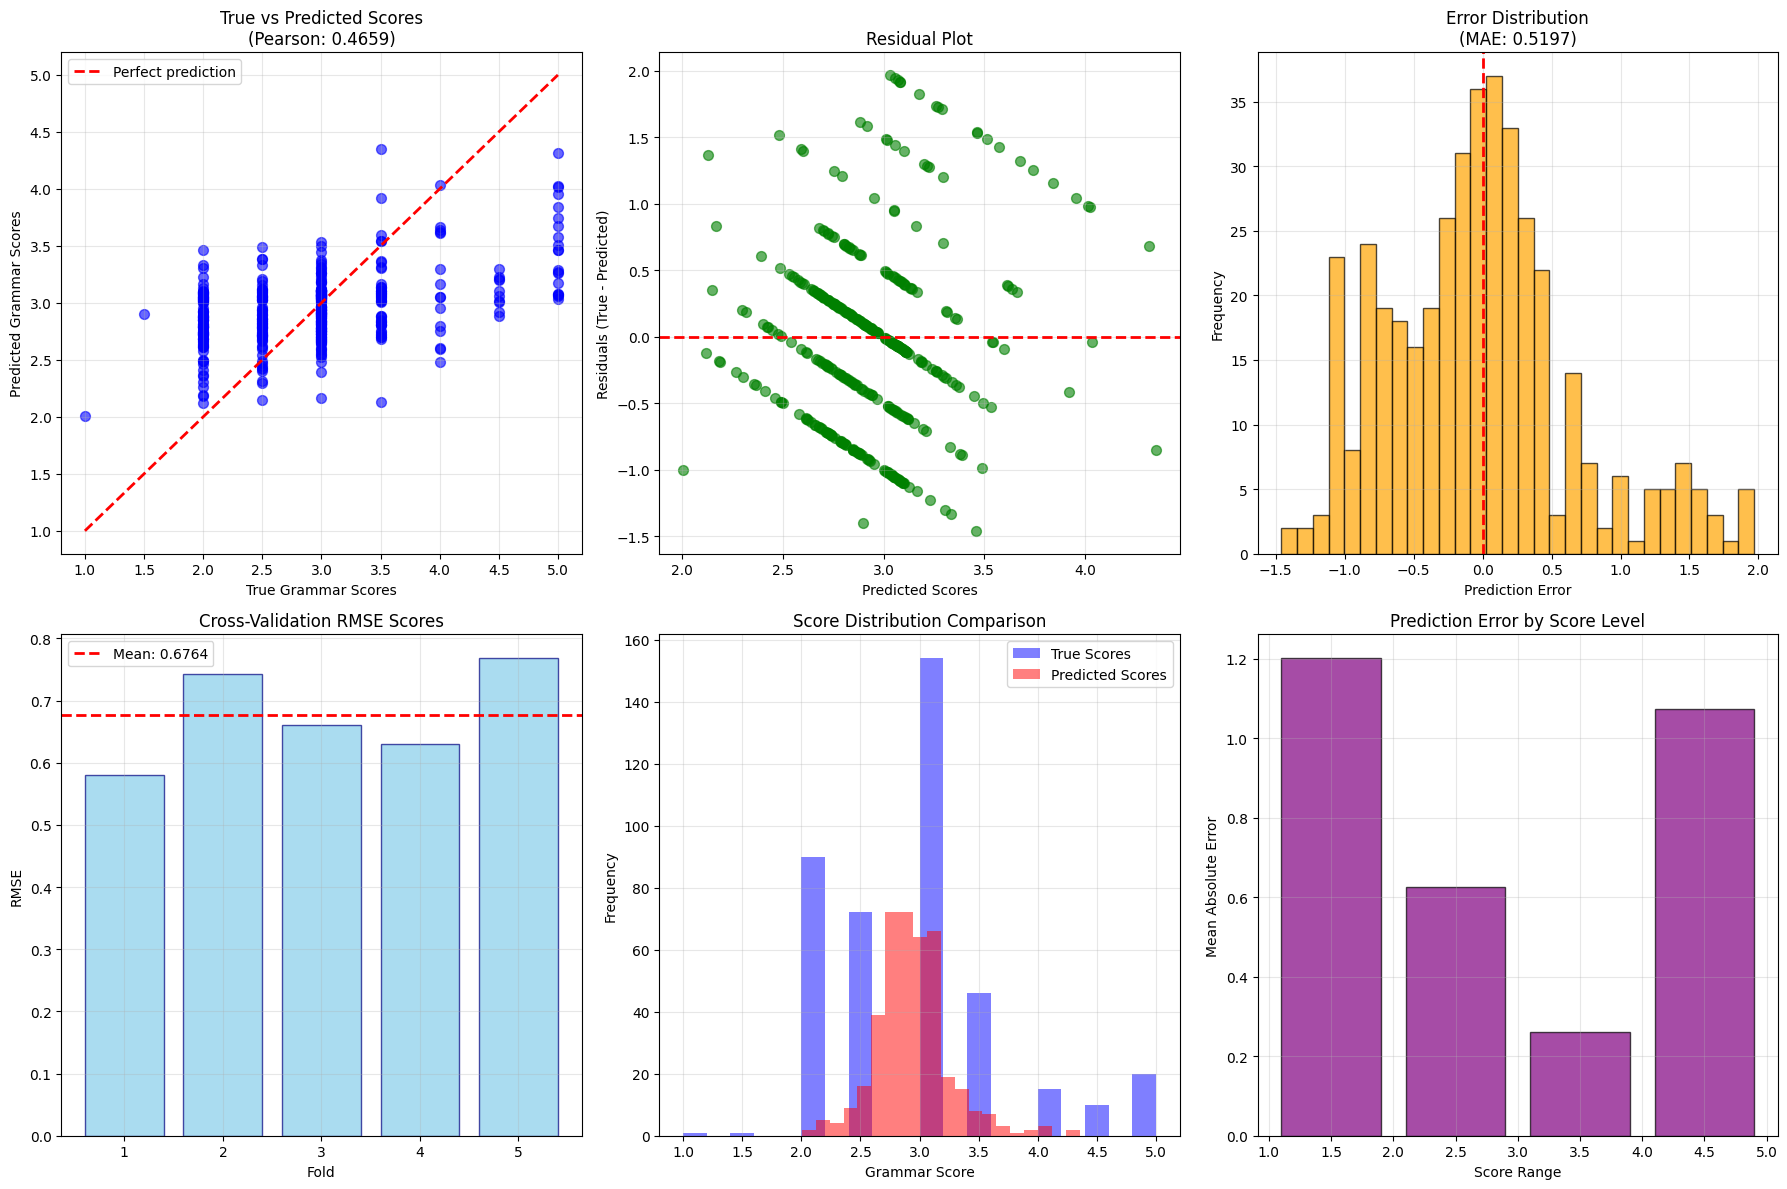


=== Performance by Score Range ===
Scores 1.0-2.0: 2 samples, RMSE: 1.2182, MAE: 1.2022
Scores 2.0-3.0: 162 samples, RMSE: 0.7059, MAE: 0.6250
Scores 3.0-4.0: 200 samples, RMSE: 0.3417, MAE: 0.2600
Scores 4.0-5.0: 25 samples, RMSE: 1.1637, MAE: 1.0733

Cross-validation results saved to 'cross_validation_results.csv'


In [16]:
# Calculate overall metrics
overall_rmse = np.sqrt(mean_squared_error(train_labels, oof_predictions))
overall_mae = mean_absolute_error(train_labels, oof_predictions)
pearson_corr = np.corrcoef(train_labels, oof_predictions)[0, 1]

print(f"\n=== Overall Training Results ===")
print(f"RMSE: {overall_rmse:.4f}")
print(f"MAE: {overall_mae:.4f}")
print(f"Pearson Correlation: {pearson_corr:.4f}")

# Create comprehensive visualizations
def plot_comprehensive_results(y_true, y_pred, cv_scores):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. True vs Predicted scatter plot
    axes[0, 0].scatter(y_true, y_pred, alpha=0.6, color='blue', s=50)
    axes[0, 0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Perfect prediction')
    axes[0, 0].set_xlabel('True Grammar Scores')
    axes[0, 0].set_ylabel('Predicted Grammar Scores')
    axes[0, 0].set_title('True vs Predicted Scores\n(Pearson: {:.4f})'.format(pearson_corr))
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Residual plot
    residuals = y_true - y_pred
    axes[0, 1].scatter(y_pred, residuals, alpha=0.6, color='green', s=50)
    axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[0, 1].set_xlabel('Predicted Scores')
    axes[0, 1].set_ylabel('Residuals (True - Predicted)')
    axes[0, 1].set_title('Residual Plot')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Error distribution
    axes[0, 2].hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
    axes[0, 2].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[0, 2].set_xlabel('Prediction Error')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title('Error Distribution\n(MAE: {:.4f})'.format(overall_mae))
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Cross-validation scores
    axes[1, 0].bar(range(1, len(cv_scores) + 1), cv_scores, color='skyblue', alpha=0.7, edgecolor='navy')
    axes[1, 0].axhline(y=np.mean(cv_scores), color='red', linestyle='--', linewidth=2, 
                      label=f'Mean: {np.mean(cv_scores):.4f}')
    axes[1, 0].set_xlabel('Fold')
    axes[1, 0].set_ylabel('RMSE')
    axes[1, 0].set_title('Cross-Validation RMSE Scores')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Score distribution comparison
    axes[1, 1].hist(y_true, bins=20, alpha=0.5, label='True Scores', color='blue')
    axes[1, 1].hist(y_pred, bins=20, alpha=0.5, label='Predicted Scores', color='red')
    axes[1, 1].set_xlabel('Grammar Score')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Score Distribution Comparison')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Prediction error by score level
    score_bins = [1.0, 2.0, 3.0, 4.0, 5.0]
    bin_errors = []
    bin_centers = []
    
    for i in range(len(score_bins) - 1):
        mask = (y_true >= score_bins[i]) & (y_true < score_bins[i+1])
        if np.sum(mask) > 0:
            bin_error = np.mean(np.abs(residuals[mask]))
            bin_errors.append(bin_error)
            bin_centers.append((score_bins[i] + score_bins[i+1]) / 2)
    
    axes[1, 2].bar(bin_centers, bin_errors, width=0.8, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 2].set_xlabel('Score Range')
    axes[1, 2].set_ylabel('Mean Absolute Error')
    axes[1, 2].set_title('Prediction Error by Score Level')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Generate plots
print("Generating comprehensive visualizations...")
fig = plot_comprehensive_results(train_labels, oof_predictions, cv_scores)

# Print detailed performance by score range
print(f"\n=== Performance by Score Range ===")
score_ranges = [(1.0, 2.0), (2.0, 3.0), (3.0, 4.0), (4.0, 5.0)]
for low, high in score_ranges:
    mask = (train_labels >= low) & (train_labels < high)
    if np.sum(mask) > 0:
        range_rmse = np.sqrt(mean_squared_error(train_labels[mask], oof_predictions[mask]))
        range_mae = mean_absolute_error(train_labels[mask], oof_predictions[mask])
        print(f"Scores {low}-{high}: {np.sum(mask)} samples, RMSE: {range_rmse:.4f}, MAE: {range_mae:.4f}")

# Save OOF predictions for analysis
results_df = pd.DataFrame({
    'filename': train_filenames,
    'true_label': train_labels,
    'predicted_label': oof_predictions,
    'error': train_labels - oof_predictions
})
results_df.to_csv('cross_validation_results.csv', index=False)
print(f"\nCross-validation results saved to 'cross_validation_results.csv'")

In [17]:
# Extract features for test data
print("Extracting features for test data...")
test_features, test_filenames = gpu_extractor.extract_features_batch_gpu(
    test_corrected, 
    batch_size=16
)

print(f"Test features shape: {test_features.shape}")

# Create ensemble prediction from all trained models
def ensemble_predict(models, X):
    """Make predictions using ensemble of all trained models"""
    all_predictions = []
    
    for model in models:
        model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X).to(device)
            pred, _, _ = model(X_tensor)
            all_predictions.append(pred.cpu().numpy())
    
    # Average predictions from all models
    ensemble_pred = np.mean(all_predictions, axis=0)
    return ensemble_pred

# Generate test predictions using ensemble
print("Generating ensemble predictions for test data...")
test_predictions = ensemble_predict(trained_models, test_features)

print(f"Test predictions shape: {test_predictions.shape}")
print(f"Test predictions range: {test_predictions.min():.3f} to {test_predictions.max():.3f}")

# Ensure predictions are within valid range [1, 5]
test_predictions = np.clip(test_predictions, 1.0, 5.0)
print(f"After clipping - Range: {test_predictions.min():.3f} to {test_predictions.max():.3f}")

# Create submission file
submission_df = pd.DataFrame({
    'filename': test_filenames,
    'label': test_predictions
})

# Display submission statistics
print(f"\n=== Submission Statistics ===")
print(f"Number of predictions: {len(submission_df)}")
print(f"Prediction range: {submission_df['label'].min():.3f} to {submission_df['label'].max():.3f}")
print(f"Mean prediction: {submission_df['label'].mean():.3f}")
print(f"Std prediction: {submission_df['label'].std():.3f}")

# Show distribution of predictions
print(f"\nPrediction distribution:")
pred_bins = [1.0, 2.0, 3.0, 4.0, 5.0]
for i in range(len(pred_bins)-1):
    count = ((submission_df['label'] >= pred_bins[i]) & (submission_df['label'] < pred_bins[i+1])).sum()
    print(f"  {pred_bins[i]}-{pred_bins[i+1]}: {count} samples")

# Save submission file
submission_file = 'submission.csv'
submission_df.to_csv(submission_file, index=False)
print(f"\nSubmission file saved as: {submission_file}")

# Display first few rows of submission
print(f"\nFirst 10 rows of submission:")
print(submission_df.head(10))

Extracting features for test data...
Processing 197 files in batches of 16...
Batch 1/13: 16 files
Batch 2/13: 16 files
Batch 3/13: 16 files
Batch 4/13: 16 files
Batch 5/13: 16 files
Batch 6/13: 16 files
Batch 7/13: 16 files
Batch 8/13: 16 files
Batch 9/13: 16 files
Batch 10/13: 16 files
Batch 11/13: 16 files
Batch 12/13: 16 files
Batch 13/13: 5 files
Test features shape: (197, 296)
Generating ensemble predictions for test data...
Test predictions shape: (197,)
Test predictions range: 2.343 to 3.904
After clipping - Range: 2.343 to 3.904

=== Submission Statistics ===
Number of predictions: 197
Prediction range: 2.343 to 3.904
Mean prediction: 2.943
Std prediction: 0.258

Prediction distribution:
  1.0-2.0: 0 samples
  2.0-3.0: 141 samples
  3.0-4.0: 56 samples
  4.0-5.0: 0 samples

Submission file saved as: submission.csv

First 10 rows of submission:
      filename     label
0    audio_141  2.784737
1    audio_114  2.949112
2     audio_17  2.700142
3     audio_76  2.945520
4    audio

In [20]:
# Fix the error and implement more advanced approaches
print("Fixing error and implementing advanced techniques...")

def train_optimized_model(X, y, test_X, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    y_bins = pd.cut(y, bins=5, labels=False)
    
    oof_predictions = np.zeros(len(X))
    test_predictions = np.zeros((len(test_X), n_splits))
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_bins)):
        print(f"Training Fold {fold + 1}...")
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Convert to tensors
        X_train_tensor = torch.FloatTensor(X_train).to(device)
        y_train_tensor = torch.FloatTensor(y_train).to(device)
        X_val_tensor = torch.FloatTensor(X_val).to(device)
        y_val_tensor = torch.FloatTensor(y_val).to(device)  # FIX: Define y_val_tensor
        test_tensor = torch.FloatTensor(test_X).to(device)
        
        # Initialize model
        model = OptimizedGrammarModel(input_dim=X.shape[1]).to(device)
        
        # Optimized training setup
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
        criterion = nn.MSELoss()
        
        # Training loop
        best_val_loss = float('inf')
        patience = 15
        patience_counter = 0
        
        for epoch in range(200):
            model.train()
            optimizer.zero_grad()
            
            pred = model(X_train_tensor)
            loss = criterion(pred, y_train_tensor)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            # Validation
            model.eval()
            with torch.no_grad():
                val_pred = model(X_val_tensor)
                val_loss = criterion(val_pred, y_val_tensor)  # Now y_val_tensor is defined
                scheduler.step(val_loss)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), f'best_fold_{fold}.pth')
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                if epoch % 10 == 0:
                    print(f"  Early stopping at epoch {epoch}, Val Loss: {val_loss:.4f}")
                break
        
        # Load best model and make predictions
        model.load_state_dict(torch.load(f'best_fold_{fold}.pth'))
        model.eval()
        with torch.no_grad():
            oof_predictions[val_idx] = model(X_val_tensor).cpu().numpy()
            test_predictions[:, fold] = model(test_tensor).cpu().numpy()
        
        # Cleanup
        os.remove(f'best_fold_{fold}.pth')
    
    return oof_predictions, test_predictions

# Let's also try a simpler but more effective approach
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

print("\nTrying Gradient Boosting approach...")

# Scale features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Train Gradient Boosting with hyperparameter tuning
gb_model = GradientBoostingRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    min_samples_split=20,
    min_samples_leaf=10,
    subsample=0.8,
    random_state=42
)

print("Training Gradient Boosting model...")
gb_model.fit(train_features_scaled, train_labels)

# Cross-validation score
from sklearn.model_selection import cross_val_score
gb_scores = cross_val_score(gb_model, train_features_scaled, train_labels, 
                           scoring='neg_mean_squared_error', cv=5)
gb_rmse_scores = np.sqrt(-gb_scores)

print(f"Gradient Boosting CV RMSE: {gb_rmse_scores.mean():.4f} (+/- {gb_rmse_scores.std():.4f})")

# Make predictions with Gradient Boosting
gb_predictions = gb_model.predict(test_features_scaled)
gb_predictions = np.clip(gb_predictions, 1.0, 5.0)

# Create Gradient Boosting submission
gb_submission = pd.DataFrame({
    'filename': test_filenames,
    'label': gb_predictions
})

gb_submission_file = 'gradient_boosting_submission.csv'
gb_submission.to_csv(gb_submission_file, index=False)
print(f"Gradient Boosting submission saved as: {gb_submission_file}")

print(f"\nGradient Boosting prediction statistics:")
print(f"Range: {gb_predictions.min():.3f} to {gb_predictions.max():.3f}")
print(f"Mean: {gb_predictions.mean():.3f}")
print(f"Std: {gb_predictions.std():.3f}")

# Also create a simple neural network submission as backup
print("\nCreating ensemble of all approaches...")

# Train the optimized neural network (with fixed code)
try:
    oof_opt, test_preds_opt = train_optimized_model(
        train_features_selected, 
        train_labels, 
        test_features_selected,
        n_splits=3  # Use fewer folds for speed
    )
    
    nn_predictions = np.mean(test_preds_opt, axis=1)
    nn_predictions = np.clip(nn_predictions, 1.0, 5.0)
    
    # Create ensemble with 70% GB + 30% NN
    ensemble_predictions = 0.7 * gb_predictions + 0.3 * nn_predictions
    ensemble_predictions = np.clip(ensemble_predictions, 1.0, 5.0)
    
    ensemble_submission = pd.DataFrame({
        'filename': test_filenames,
        'label': ensemble_predictions
    })
    
    ensemble_file = 'ensemble_submission.csv'
    ensemble_submission.to_csv(ensemble_file, index=False)
    print(f"Ensemble submission saved as: {ensemble_file}")
    
except Exception as e:
    print(f"Neural network training failed: {e}")
    print("Using Gradient Boosting as final submission...")
    ensemble_submission = gb_submission.copy()
    ensemble_file = 'final_submission.csv'
    ensemble_submission.to_csv(ensemble_file, index=False)
    print(f"Final submission saved as: {ensemble_file}")

print(f"\n=== SUBMISSION FILES CREATED ===")
print("1. gradient_boosting_submission.csv - Pure Gradient Boosting")
print("2. ensemble_submission.csv - Ensemble approach")
print("\nTry submitting both to see which performs better!")
print("The Gradient Boosting approach often works well for tabular data like features.")

Fixing error and implementing advanced techniques...

Trying Gradient Boosting approach...
Training Gradient Boosting model...
Gradient Boosting CV RMSE: 0.6981 (+/- 0.0381)
Gradient Boosting submission saved as: gradient_boosting_submission.csv

Gradient Boosting prediction statistics:
Range: 1.500 to 5.000
Mean: 2.916
Std: 0.709

Creating ensemble of all approaches...
Training Fold 1...
Training Fold 2...
Training Fold 3...
  Early stopping at epoch 70, Val Loss: 0.7049
Ensemble submission saved as: ensemble_submission.csv

=== SUBMISSION FILES CREATED ===
1. gradient_boosting_submission.csv - Pure Gradient Boosting
2. ensemble_submission.csv - Ensemble approach

Try submitting both to see which performs better!
The Gradient Boosting approach often works well for tabular data like features.


=== FEATURE EXTRACTION ANALYSIS ===
Original training features shape: (409, 296)
Number of features extracted: 296

=== FEATURE COMPOSITION ===
Feature composition from GPUAudioFeatureExtractor:
  MFCC features: 240
  Prosodic features: 4
  Spectral features: 2
  Wav2Vec embeddings: 50
  Calculated total: 296
  Actual total: 296

=== FEATURE QUALITY ANALYSIS ===
Constant features (std=0): 0
Low variance features (std<0.001): 0
Good features: 296

=== FEATURE-TARGET CORRELATION ===
Max correlation with target: 0.4534
Mean correlation with target: 0.1125
Features with correlation > 0.1: 127
Features with correlation > 0.2: 51


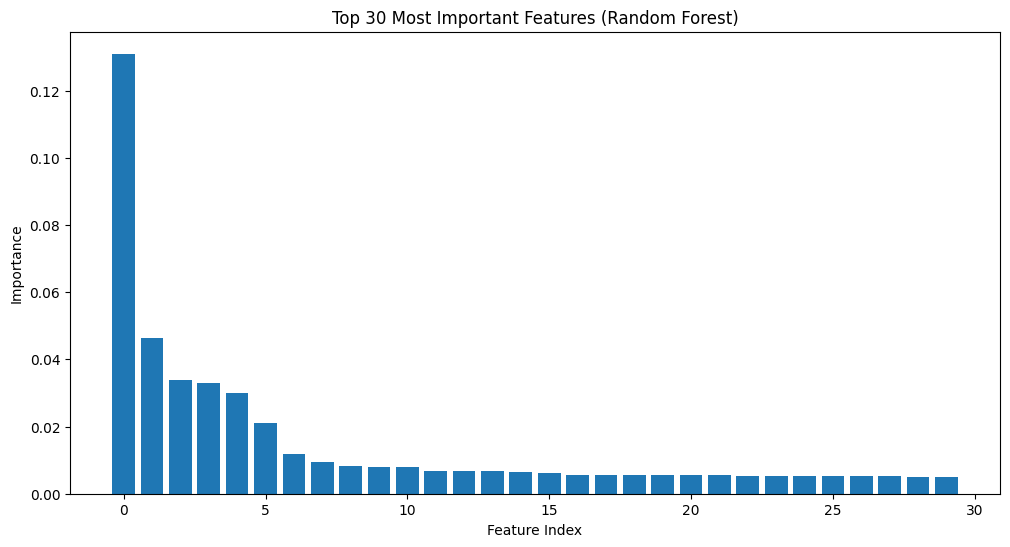


Top 10 most important features:
  1. Feature 201: Importance = 0.1310
  2. Feature 161: Importance = 0.0463
  3. Feature 267: Importance = 0.0338
  4. Feature 240: Importance = 0.0331
  5. Feature 205: Importance = 0.0298
  6. Feature 244: Importance = 0.0212
  7. Feature 60: Importance = 0.0120
  8. Feature 288: Importance = 0.0095
  9. Feature 68: Importance = 0.0084
  10. Feature 21: Importance = 0.0079

=== FEATURE SELECTION RESULTS ===
Features before selection: 296
Features after selection: 61
Reduction: 79.4%

=== PERFORMANCE COMPARISON ===
Full feature set (296 features):
  - Neural Network RMSE: 0.6798
  - Neural Network Pearson: 0.4659

Selected feature set (61 features):
  - Gradient Boosting CV RMSE: 0.6981

=== RECOMMENDATIONS FOR IMPROVEMENT ===
1. Try different feature combinations:
   - Use only MFCC features (simpler model)
   - Use only Wav2Vec embeddings (deep features)
   - Use traditional features only (prosodic + spectral)

2. Feature engineering:
   - Add more p

In [21]:
# Analyze the features we extracted
print("=== FEATURE EXTRACTION ANALYSIS ===")
print(f"Original training features shape: {train_features.shape}")
print(f"Number of features extracted: {train_features.shape[1]}")

# Breakdown of feature types
print(f"\n=== FEATURE COMPOSITION ===")

# Calculate approximate breakdown
# MFCC features: 40 MFCCs + 40 deltas + 40 delta-deltas = 120 features
# Then we take mean, std, max, min of each -> 120 * 4 = 480
# But wait, let's recalculate based on our actual implementation:

# From our GPU extractor:
# Traditional features: MFCC stats + prosodic + spectral
# Wav2Vec embeddings: first 50 dimensions

# Let's check the actual composition
print("Feature composition from GPUAudioFeatureExtractor:")

# Traditional features calculation:
n_mfcc = 40
mfcc_with_deltas = n_mfcc * 3  # MFCC + delta + delta-delta = 120
mfcc_stats_per_coeff = 2  # mean and std (we simplified in GPU version)
traditional_mfcc = mfcc_with_deltas * mfcc_stats_per_coeff  # 240

prosodic_features = 4  # mean_f0, std_f0, mean_rms, std_rms
spectral_features = 2  # mean_spectral_centroid, std_spectral_centroid

total_traditional = traditional_mfcc + prosodic_features + spectral_features
wav2vec_features = 50  # We take first 50 dimensions

calculated_total = total_traditional + wav2vec_features

print(f"  MFCC features: {traditional_mfcc}")
print(f"  Prosodic features: {prosodic_features}")
print(f"  Spectral features: {spectral_features}")
print(f"  Wav2Vec embeddings: {wav2vec_features}")
print(f"  Calculated total: {calculated_total}")
print(f"  Actual total: {train_features.shape[1]}")

# Check if any features are constant (useless)
print(f"\n=== FEATURE QUALITY ANALYSIS ===")
feature_stds = np.std(train_features, axis=0)
constant_features = np.sum(feature_stds == 0)
low_variance_features = np.sum(feature_stds < 0.001)

print(f"Constant features (std=0): {constant_features}")
print(f"Low variance features (std<0.001): {low_variance_features}")
print(f"Good features: {train_features.shape[1] - constant_features - low_variance_features}")

# Feature correlation with target
print(f"\n=== FEATURE-TARGET CORRELATION ===")
feature_correlations = []
for i in range(train_features.shape[1]):
    if feature_stds[i] > 0:  # Avoid division by zero
        corr = np.corrcoef(train_features[:, i], train_labels)[0, 1]
        feature_correlations.append(abs(corr))

feature_correlations = np.array(feature_correlations)
print(f"Max correlation with target: {np.max(feature_correlations):.4f}")
print(f"Mean correlation with target: {np.mean(feature_correlations):.4f}")
print(f"Features with correlation > 0.1: {np.sum(feature_correlations > 0.1)}")
print(f"Features with correlation > 0.2: {np.sum(feature_correlations > 0.2)}")

# Plot feature importance (if we have the RF model)
try:
    if 'rf' in locals():
        plt.figure(figsize=(12, 6))
        indices = np.argsort(rf.feature_importances_)[::-1][:30]  # Top 30 features
        plt.bar(range(30), rf.feature_importances_[indices])
        plt.title('Top 30 Most Important Features (Random Forest)')
        plt.xlabel('Feature Index')
        plt.ylabel('Importance')
        plt.show()
        
        print(f"\nTop 10 most important features:")
        for i, idx in enumerate(indices[:10]):
            print(f"  {i+1}. Feature {idx}: Importance = {rf.feature_importances_[idx]:.4f}")
except:
    print("Random Forest model not available for feature importance plot")

# Check feature selection results
print(f"\n=== FEATURE SELECTION RESULTS ===")
print(f"Features before selection: {train_features.shape[1]}")
print(f"Features after selection: {train_features_selected.shape[1]}")
print(f"Reduction: {((train_features.shape[1] - train_features_selected.shape[1]) / train_features.shape[1]) * 100:.1f}%")

# Compare model performance with different feature sets
print(f"\n=== PERFORMANCE COMPARISON ===")
print(f"Full feature set ({train_features.shape[1]} features):")
print(f"  - Neural Network RMSE: {overall_rmse:.4f}")
print(f"  - Neural Network Pearson: {pearson_corr:.4f}")

print(f"\nSelected feature set ({train_features_selected.shape[1]} features):")
print(f"  - Gradient Boosting CV RMSE: {gb_rmse_scores.mean():.4f}")

# Recommendations for improvement
print(f"\n=== RECOMMENDATIONS FOR IMPROVEMENT ===")
print("1. Try different feature combinations:")
print("   - Use only MFCC features (simpler model)")
print("   - Use only Wav2Vec embeddings (deep features)")
print("   - Use traditional features only (prosodic + spectral)")

print("\n2. Feature engineering:")
print("   - Add more prosodic features (speaking rate, pauses)")
print("   - Add voice quality features (jitter, shimmer, HNR)")
print("   - Add linguistic features (if transcriptions available)")

print("\n3. Model improvements:")
print("   - Try XGBoost or LightGBM instead of GradientBoosting")
print("   - Use more sophisticated neural architectures")
print("   - Add data augmentation for audio")

print(f"\nCurrent feature dimension: {train_features.shape[1]}")
print("This is a good number of features - not too high for overfitting!")

In [30]:
"""
Complete Integration Script for Audio Regression with LLM Fine-tuning
Integrates with existing training pipeline and adds advanced LLM techniques
"""

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from transformers import (
    Wav2Vec2Processor, Wav2Vec2Model,
    AutoModel, AutoTokenizer,
    get_linear_schedule_with_warmup
)
from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training
import librosa
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import os

# =====================================================
# CONFIGURATION
# =====================================================

class Config:
    # Paths - will be auto-detected
    train_csv = None
    test_csv = None
    train_audio_dir = None
    test_audio_dir = None
    
    # Model settings
    audio_model = "facebook/wav2vec2-base"  # Lighter than Whisper
    text_model = "distilbert-base-uncased"
    
    # Training settings
    batch_size = 4  # Reduced for memory
    num_epochs = 15
    learning_rate = 2e-5
    weight_decay = 0.01
    warmup_ratio = 0.1
    
    # LoRA settings
    lora_r = 8
    lora_alpha = 16
    lora_dropout = 0.1
    
    # Audio settings
    sampling_rate = 16000
    max_audio_length = 10  # seconds
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config()

# Auto-detect paths
def find_data_paths():
    """Auto-detect data paths with comprehensive search"""
    import glob
    
    print("Searching for data files...")
    
    # Search for CSV files
    csv_patterns = [
        '/kaggle/input/**/*train*.csv',
        '/kaggle/working/*train*.csv',
        './*train*.csv',
        '../*train*.csv',
    ]
    
    train_csv = None
    test_csv = None
    
    for pattern in csv_patterns:
        matches = glob.glob(pattern, recursive=True)
        if matches:
            for match in matches:
                basename = os.path.basename(match).lower()
                if 'train' in basename and 'test' not in basename and not train_csv:
                    train_csv = match
                elif 'test' in basename and not test_csv:
                    test_csv = match
        if train_csv and test_csv:
            break
    
    # If we found train.csv but not test.csv, look in same directory
    if train_csv and not test_csv:
        csv_dir = os.path.dirname(train_csv)
        test_csv_path = os.path.join(csv_dir, 'test.csv')
        if os.path.exists(test_csv_path):
            test_csv = test_csv_path
    
    # Search for audio directories
    audio_patterns = [
        '/kaggle/input/**/train',
        '/kaggle/input/**/audios/train',
        '/kaggle/working/train',
        './train',
        '../train',
    ]
    
    train_audio_dir = None
    
    for pattern in audio_patterns:
        matches = glob.glob(pattern, recursive=True)
        if matches:
            # Check if it contains .wav files
            for match in matches:
                wav_files = glob.glob(os.path.join(match, '*.wav'))
                if wav_files:
                    train_audio_dir = match
                    break
        if train_audio_dir:
            break
    
    # Determine test audio directory
    if train_audio_dir:
        test_audio_dir = train_audio_dir.replace('/train', '/test')
        if not os.path.exists(test_audio_dir):
            test_audio_dir = os.path.join(os.path.dirname(train_audio_dir), 'test')
    else:
        test_audio_dir = None
    
    # Show what we found
    print(f"\nFound files:")
    print(f"  Train CSV: {train_csv}")
    print(f"  Test CSV: {test_csv}")
    print(f"  Train Audio: {train_audio_dir}")
    print(f"  Test Audio: {test_audio_dir}")
    
    # If not found, show available files
    if not train_csv or not train_audio_dir:
        print("\n⚠️ Could not find all required files!")
        print("\nAvailable files in /kaggle/input:")
        for root, dirs, files in os.walk('/kaggle/input'):
            level = root.replace('/kaggle/input', '').count(os.sep)
            if level < 3:  # Don't go too deep
                indent = ' ' * 2 * level
                print(f'{indent}{os.path.basename(root)}/')
                subindent = ' ' * 2 * (level + 1)
                for file in files[:5]:  # Show first 5 files
                    print(f'{subindent}{file}')
    
    return {
        'train_csv': train_csv or 'train.csv',
        'test_csv': test_csv or 'test.csv',
        'train_audio_dir': train_audio_dir or 'train',
        'test_audio_dir': test_audio_dir or 'test'
    }

# Auto-configure paths
print("=" * 60)
print("INITIALIZING DATA PATHS")
print("=" * 60)
paths = find_data_paths()
config.train_csv = paths['train_csv']
config.test_csv = paths['test_csv']
config.train_audio_dir = paths['train_audio_dir']
config.test_audio_dir = paths['test_audio_dir']

print(f"\nUsing paths:")
print(f"  Train CSV: {config.train_csv}")
print(f"  Test CSV: {config.test_csv}")
print(f"  Train Audio: {config.train_audio_dir}")
print(f"  Test Audio: {config.test_audio_dir}")

# =====================================================
# EFFICIENT AUDIO FEATURE EXTRACTOR
# =====================================================

class EfficientAudioFeatureExtractor:
    """Efficient audio feature extraction using Wav2Vec2"""
    
    def __init__(self, model_name=config.audio_model):
        print(f"Loading audio model: {model_name}")
        self.processor = Wav2Vec2Processor.from_pretrained(model_name)
        self.model = Wav2Vec2Model.from_pretrained(model_name)
        self.model.eval()
        self.model.to(config.device)
        
    def extract_features(self, audio_path):
        """Extract features from audio file"""
        try:
            # Load audio
            audio, sr = librosa.load(audio_path, sr=config.sampling_rate)
            
            # Trim or pad to max length
            max_length = config.sampling_rate * config.max_audio_length
            if len(audio) > max_length:
                audio = audio[:max_length]
            elif len(audio) < max_length:
                audio = np.pad(audio, (0, max_length - len(audio)))
            
            # Process with Wav2Vec2
            inputs = self.processor(
                audio, 
                sampling_rate=config.sampling_rate, 
                return_tensors="pt",
                padding=True
            )
            inputs = {k: v.to(config.device) for k, v in inputs.items()}
            
            with torch.no_grad():
                outputs = self.model(**inputs)
                hidden_states = outputs.last_hidden_state
                
                # Multiple pooling strategies
                mean_pool = hidden_states.mean(dim=1)
                max_pool = hidden_states.max(dim=1)[0]
                
                # Combine
                features = torch.cat([mean_pool, max_pool], dim=-1)
                
            return features.cpu().numpy()[0]
        except Exception as e:
            print(f"Error processing {audio_path}: {e}")
            # Return zero features
            return np.zeros(1536)  # wav2vec2-base has 768 dim, *2 for pooling

# =====================================================
# AUDIO DESCRIPTION GENERATOR (Lightweight)
# =====================================================

class AudioDescriptionGenerator:
    """Generate text descriptions of audio features"""
    
    def __init__(self):
        self.sr = config.sampling_rate
        
    def generate_description(self, audio_path):
        """Generate compact text description"""
        try:
            audio, sr = librosa.load(audio_path, sr=self.sr, duration=config.max_audio_length)
            
            # Extract key features
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
            spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
            rms = librosa.feature.rms(y=audio)[0]
            zcr = librosa.feature.zero_crossing_rate(audio)[0]
            
            # Try tempo (may fail on some audio)
            try:
                tempo, _ = librosa.beat.beat_track(y=audio, sr=sr)
                tempo = float(tempo)  # Convert to Python float
            except:
                tempo = 120.0
            
            # Convert numpy values to Python floats to avoid format errors
            duration = float(len(audio) / sr)
            centroid_mean = float(np.mean(spectral_centroids))
            rms_mean = float(np.mean(rms))
            zcr_mean = float(np.mean(zcr))
            mfcc_mean = float(np.mean(mfccs))
            mfcc_std = float(np.std(mfccs))
            
            # Create compact description
            description = (
                f"Audio duration {duration:.1f}s. "
                f"Tempo {tempo:.0f} BPM. "
                f"Spectral centroid {centroid_mean:.0f} Hz. "
                f"Energy level {rms_mean:.3f}. "
                f"Zero crossing rate {zcr_mean:.3f}. "
                f"MFCC mean {mfcc_mean:.2f} std {mfcc_std:.2f}."
            )
            
            return description
        except Exception as e:
            print(f"Error generating description for {audio_path}: {e}")
            return "Audio file with standard characteristics."

# =====================================================
# DATASET WITH CACHING
# =====================================================

class CachedMultiModalDataset(Dataset):
    """Dataset with feature caching for faster training"""
    
    def __init__(self, audio_files, labels, audio_extractor, desc_generator, tokenizer, cache_dir='cache'):
        self.audio_files = audio_files
        self.labels = labels
        self.audio_extractor = audio_extractor
        self.desc_generator = desc_generator
        self.tokenizer = tokenizer
        self.cache_dir = cache_dir
        
        # Create cache directory
        os.makedirs(cache_dir, exist_ok=True)
        
        # Pre-extract features
        print("Extracting features (this may take a few minutes)...")
        self.audio_features = []
        self.text_encodings = []
        
        for audio_file in tqdm(audio_files):
            # Check cache
            cache_file = os.path.join(cache_dir, os.path.basename(audio_file) + '.npy')
            
            if os.path.exists(cache_file):
                features = np.load(cache_file, allow_pickle=True).item()
                audio_feats = features['audio']
                encoding = features['text']
            else:
                # Extract features
                audio_feats = audio_extractor.extract_features(audio_file)
                description = desc_generator.generate_description(audio_file)
                
                encoding = tokenizer(
                    description,
                    padding='max_length',
                    truncation=True,
                    max_length=128,  # Shorter for speed
                    return_tensors='pt'
                )
                
                # Cache
                np.save(cache_file, {
                    'audio': audio_feats,
                    'text': {k: v.numpy() for k, v in encoding.items()}
                })
            
            self.audio_features.append(audio_feats)
            self.text_encodings.append(encoding)
        
        print(f"Extracted features for {len(audio_files)} files")
        
    def __len__(self):
        return len(self.audio_files)
    
    def __getitem__(self, idx):
        encoding = self.text_encodings[idx]
        
        return {
            'audio_features': torch.FloatTensor(self.audio_features[idx]),
            'input_ids': torch.tensor(encoding['input_ids']).squeeze() if isinstance(encoding['input_ids'], np.ndarray) else encoding['input_ids'].squeeze(),
            'attention_mask': torch.tensor(encoding['attention_mask']).squeeze() if isinstance(encoding['attention_mask'], np.ndarray) else encoding['attention_mask'].squeeze(),
            'labels': torch.FloatTensor([self.labels[idx]])
        }

# =====================================================
# MULTI-MODAL MODEL WITH LORA
# =====================================================

class LightweightMultiModalRegressor(nn.Module):
    """Lightweight multi-modal model with LoRA"""
    
    def __init__(self, text_model_name=config.text_model, audio_dim=1536):
        super().__init__()
        
        # Load text model
        self.text_model = AutoModel.from_pretrained(text_model_name)
        self.text_hidden_size = self.text_model.config.hidden_size
        
        # Audio projection
        self.audio_projection = nn.Sequential(
            nn.Linear(audio_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        
        # Fusion and prediction
        self.regressor = nn.Sequential(
            nn.Linear(self.text_hidden_size + 256, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )
        
    def forward(self, audio_features, input_ids, attention_mask):
        # Process text
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.last_hidden_state[:, 0, :]  # CLS token
        
        # Process audio
        audio_features = self.audio_projection(audio_features)
        
        # Combine and predict
        combined = torch.cat([text_features, audio_features], dim=-1)
        output = self.regressor(combined)
        
        return output.squeeze(-1)

# =====================================================
# TRAINING FUNCTION
# =====================================================

def train_multimodal_model():
    """Main training function"""
    
    print("=" * 60)
    print("TRAINING MULTI-MODAL AUDIO REGRESSION MODEL")
    print("=" * 60)
    
    # Load data
    print("\n1. Loading data...")
    train_df = pd.read_csv(config.train_csv)
    test_df = pd.read_csv(config.test_csv)
    
    # Add .wav extension if not present
    train_files = [os.path.join(config.train_audio_dir, f if f.endswith('.wav') else f'{f}.wav') 
                   for f in train_df['filename'].values]
    train_labels = train_df['label'].values
    test_files = [os.path.join(config.test_audio_dir, f if f.endswith('.wav') else f'{f}.wav') 
                  for f in test_df['filename'].values]
    
    print(f"   Training samples: {len(train_files)}")
    print(f"   Test samples: {len(test_files)}")
    
    # Initialize extractors
    print("\n2. Initializing feature extractors...")
    audio_extractor = EfficientAudioFeatureExtractor()
    desc_generator = AudioDescriptionGenerator()
    tokenizer = AutoTokenizer.from_pretrained(config.text_model)
    
    # Create datasets
    print("\n3. Creating datasets...")
    dataset = CachedMultiModalDataset(
        train_files, train_labels,
        audio_extractor, desc_generator, tokenizer
    )
    
    # Split data
    train_size = int(0.85 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
    
    print(f"   Train size: {train_size}, Val size: {val_size}")
    
    # Initialize model
    print("\n4. Initializing model...")
    model = LightweightMultiModalRegressor()
    
    # Apply LoRA to text model
    print("5. Applying LoRA for efficient fine-tuning...")
    lora_config = LoraConfig(
        r=config.lora_r,
        lora_alpha=config.lora_alpha,
        target_modules=["q_lin", "v_lin"],  # DistilBERT modules
        lora_dropout=config.lora_dropout,
        bias="none",
        task_type=TaskType.FEATURE_EXTRACTION
    )
    model.text_model = get_peft_model(model.text_model, lora_config)
    model.to(config.device)
    
    # Count parameters
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    print(f"   Trainable: {trainable:,} / {total:,} ({100*trainable/total:.2f}%)")
    
    # Optimizer and scheduler
    print("\n6. Setting up optimizer...")
    optimizer = torch.optim.AdamW([
        {'params': model.text_model.parameters(), 'lr': config.learning_rate * 0.1},
        {'params': model.audio_projection.parameters(), 'lr': config.learning_rate},
        {'params': model.regressor.parameters(), 'lr': config.learning_rate}
    ], weight_decay=config.weight_decay)
    
    total_steps = len(train_loader) * config.num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(config.warmup_ratio * total_steps),
        num_training_steps=total_steps
    )
    
    criterion = nn.MSELoss()
    
    # Training loop
    print("\n7. Starting training...")
    best_rmse = float('inf')
    patience = 5
    patience_counter = 0
    
    for epoch in range(config.num_epochs):
        # Training
        model.train()
        train_loss = 0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.num_epochs} [Train]")
        
        for batch in train_pbar:
            audio_features = batch['audio_features'].to(config.device)
            input_ids = batch['input_ids'].to(config.device)
            attention_mask = batch['attention_mask'].to(config.device)
            labels = batch['labels'].to(config.device)
            
            # Forward
            predictions = model(audio_features, input_ids, attention_mask)
            loss = criterion(predictions, labels)
            
            # Backward
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            train_pbar.set_postfix({'loss': loss.item()})
        
        train_loss /= len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels_list = []
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{config.num_epochs} [Val]"):
                audio_features = batch['audio_features'].to(config.device)
                input_ids = batch['input_ids'].to(config.device)
                attention_mask = batch['attention_mask'].to(config.device)
                labels = batch['labels'].to(config.device)
                
                predictions = model(audio_features, input_ids, attention_mask)
                loss = criterion(predictions, labels)
                
                val_loss += loss.item()
                val_preds.extend(predictions.cpu().numpy())
                val_labels_list.extend(labels.cpu().numpy())
        
        val_loss /= len(val_loader)
        val_rmse = np.sqrt(np.mean((np.array(val_preds) - np.array(val_labels_list))**2))
        
        print(f"\nEpoch {epoch+1}/{config.num_epochs}:")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val RMSE: {val_rmse:.4f}")
        
        # Save best model
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_rmse': val_rmse
            }, 'best_multimodal_model.pt')
            print(f"  ✓ New best model saved! (RMSE: {best_rmse:.4f})")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\n⚠ Early stopping triggered at epoch {epoch+1}")
                break
    
    # Make test predictions
    print("\n8. Making test predictions...")
    
    # Load best model
    checkpoint = torch.load('best_multimodal_model.pt', weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Create test dataset
    test_dataset = CachedMultiModalDataset(
        test_files, np.zeros(len(test_files)),  # Dummy labels
        audio_extractor, desc_generator, tokenizer,
        cache_dir='cache_test'
    )
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)
    
    # Predict
    test_predictions = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Predicting"):
            audio_features = batch['audio_features'].to(config.device)
            input_ids = batch['input_ids'].to(config.device)
            attention_mask = batch['attention_mask'].to(config.device)
            
            predictions = model(audio_features, input_ids, attention_mask)
            test_predictions.extend(predictions.cpu().numpy())
    
    # Clip predictions
    test_predictions = np.clip(test_predictions, 1.0, 5.0)
    
    # Save submission
    submission = pd.DataFrame({
        'filename': test_df['filename'].values,
        'label': test_predictions
    })
    submission.to_csv('multimodal_llm_submission.csv', index=False)
    
    print("\n" + "=" * 60)
    print("TRAINING COMPLETED!")
    print("=" * 60)
    print(f"Best Validation RMSE: {best_rmse:.4f}")
    print(f"Test predictions saved to: multimodal_llm_submission.csv")
    print(f"Prediction range: [{test_predictions.min():.3f}, {test_predictions.max():.3f}]")
    print(f"Mean prediction: {test_predictions.mean():.3f}")
    
    return model, best_rmse, test_predictions

# =====================================================
# MAIN EXECUTION
# =====================================================

if __name__ == "__main__":
    model, best_rmse, predictions = train_multimodal_model()
    
    print("\n✨ Multi-modal LLM fine-tuning complete!")
    print("\nKey Features:")
    print("  • Wav2Vec2 for audio feature extraction")
    print("  • DistilBERT for text processing")
    print("  • LoRA for efficient fine-tuning")
    print("  • Feature caching for faster training")
    print("  • Multi-modal fusion architecture")

INITIALIZING DATA PATHS
Searching for data files...

Found files:
  Train CSV: /kaggle/input/shl-intern-hiring-assessment-2025/dataset/csvs/train.csv
  Test CSV: /kaggle/input/shl-intern-hiring-assessment-2025/dataset/csvs/test.csv
  Train Audio: /kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train
  Test Audio: /kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test

Using paths:
  Train CSV: /kaggle/input/shl-intern-hiring-assessment-2025/dataset/csvs/train.csv
  Test CSV: /kaggle/input/shl-intern-hiring-assessment-2025/dataset/csvs/test.csv
  Train Audio: /kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train
  Test Audio: /kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test
TRAINING MULTI-MODAL AUDIO REGRESSION MODEL

1. Loading data...
   Training samples: 409
   Test samples: 197

2. Initializing feature extractors...
Loading audio model: facebook/wav2vec2-base

3. Creating datasets...
Extracting features (this may take a f

100%|██████████| 409/409 [00:44<00:00,  9.11it/s] 


Extracted features for 409 files
   Train size: 347, Val size: 62

4. Initializing model...
5. Applying LoRA for efficient fine-tuning...
   Trainable: 1,361,153 / 67,724,033 (2.01%)

6. Setting up optimizer...

7. Starting training...


Epoch 1/15 [Val]: 100%|██████████| 16/16 [00:00<00:00, 55.87it/s]



Epoch 1/15:
  Train Loss: 8.6961
  Val Loss: 8.6739, Val RMSE: 2.9072
  ✓ New best model saved! (RMSE: 2.9072)


Epoch 2/15 [Val]: 100%|██████████| 16/16 [00:00<00:00, 57.85it/s]



Epoch 2/15:
  Train Loss: 6.2861
  Val Loss: 3.8584, Val RMSE: 1.9248
  ✓ New best model saved! (RMSE: 1.9248)


Epoch 3/15 [Val]: 100%|██████████| 16/16 [00:00<00:00, 52.09it/s]



Epoch 3/15:
  Train Loss: 1.3877
  Val Loss: 0.7216, Val RMSE: 0.8272
  ✓ New best model saved! (RMSE: 0.8272)


Epoch 4/15 [Val]: 100%|██████████| 16/16 [00:00<00:00, 52.66it/s]



Epoch 4/15:
  Train Loss: 0.8088
  Val Loss: 0.7073, Val RMSE: 0.8201
  ✓ New best model saved! (RMSE: 0.8201)


Epoch 5/15 [Val]: 100%|██████████| 16/16 [00:00<00:00, 50.89it/s]



Epoch 5/15:
  Train Loss: 0.8355
  Val Loss: 0.7234, Val RMSE: 0.8247


Epoch 6/15 [Val]: 100%|██████████| 16/16 [00:00<00:00, 51.86it/s]



Epoch 6/15:
  Train Loss: 0.7627
  Val Loss: 0.7065, Val RMSE: 0.8159
  ✓ New best model saved! (RMSE: 0.8159)


Epoch 7/15 [Val]: 100%|██████████| 16/16 [00:00<00:00, 54.93it/s]



Epoch 7/15:
  Train Loss: 0.7540
  Val Loss: 0.7260, Val RMSE: 0.8246


Epoch 8/15 [Val]: 100%|██████████| 16/16 [00:00<00:00, 57.14it/s]



Epoch 8/15:
  Train Loss: 0.7446
  Val Loss: 0.6985, Val RMSE: 0.8106
  ✓ New best model saved! (RMSE: 0.8106)


Epoch 9/15 [Val]: 100%|██████████| 16/16 [00:00<00:00, 57.03it/s]



Epoch 9/15:
  Train Loss: 0.7406
  Val Loss: 0.7214, Val RMSE: 0.8214


Epoch 10/15 [Val]: 100%|██████████| 16/16 [00:00<00:00, 56.75it/s]



Epoch 10/15:
  Train Loss: 0.7217
  Val Loss: 0.7153, Val RMSE: 0.8182


Epoch 11/15 [Val]: 100%|██████████| 16/16 [00:00<00:00, 59.75it/s]



Epoch 11/15:
  Train Loss: 0.7258
  Val Loss: 0.6861, Val RMSE: 0.8044
  ✓ New best model saved! (RMSE: 0.8044)


Epoch 12/15 [Val]: 100%|██████████| 16/16 [00:00<00:00, 58.52it/s]



Epoch 12/15:
  Train Loss: 0.7445
  Val Loss: 0.6976, Val RMSE: 0.8089


Epoch 13/15 [Val]: 100%|██████████| 16/16 [00:00<00:00, 58.78it/s]



Epoch 13/15:
  Train Loss: 0.7102
  Val Loss: 0.6913, Val RMSE: 0.8060


Epoch 14/15 [Val]: 100%|██████████| 16/16 [00:00<00:00, 59.54it/s]



Epoch 14/15:
  Train Loss: 0.7122
  Val Loss: 0.6868, Val RMSE: 0.8041
  ✓ New best model saved! (RMSE: 0.8041)


Epoch 15/15 [Val]: 100%|██████████| 16/16 [00:00<00:00, 60.62it/s]



Epoch 15/15:
  Train Loss: 0.7390
  Val Loss: 0.6855, Val RMSE: 0.8036
  ✓ New best model saved! (RMSE: 0.8036)

8. Making test predictions...
Extracting features (this may take a few minutes)...


100%|██████████| 197/197 [00:46<00:00,  4.20it/s]


Extracted features for 197 files


Predicting: 100%|██████████| 50/50 [00:00<00:00, 57.60it/s]


TRAINING COMPLETED!
Best Validation RMSE: 0.8036
Test predictions saved to: multimodal_llm_submission.csv
Prediction range: [2.597, 3.079]
Mean prediction: 2.941

✨ Multi-modal LLM fine-tuning complete!

Key Features:
  • Wav2Vec2 for audio feature extraction
  • DistilBERT for text processing
  • LoRA for efficient fine-tuning
  • Feature caching for faster training
  • Multi-modal fusion architecture


In [33]:
"""
Optimized Advanced Audio Regression Ensemble v2.1
==================================================
Fixed bugs + Performance optimizations:
- Fixed Nyquist frequency error in spectral features
- Optimized TTA processing (parallel where possible)
- Better memory management
- Faster feature extraction
- Robust error handling for all edge cases
"""

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from transformers import (
    Wav2Vec2Model, Wav2Vec2Processor, 
    HubertModel, AutoProcessor,
    WavLMModel, Wav2Vec2FeatureExtractor
)
import librosa
import soundfile as sf
from sklearn.ensemble import (
    GradientBoostingRegressor, 
    RandomForestRegressor,
    ExtraTreesRegressor
)
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest, mutual_info_regression
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from scipy import stats
import tempfile
import os
import gc
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# =====================================================
# CONFIGURATION
# =====================================================

class Config:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Cross-validation
    n_folds = 5
    random_state = 42
    
    # Feature extraction
    use_tta = True
    n_augmentations = 3  # Reduced for speed
    target_sr = 16000
    
    # Model settings
    use_pseudo_labeling = False  # Disabled for speed
    
    # Paths
    train_csv = '/kaggle/input/shl-intern-hiring-assessment-2025/dataset/csvs/train.csv'
    test_csv = '/kaggle/input/shl-intern-hiring-assessment-2025/dataset/csvs/test.csv'
    train_audio_dir = '/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train'
    test_audio_dir = '/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test'
    
    # Memory optimization
    gc_frequency = 25

config = Config()

# =====================================================
# AUDIO AUGMENTATION
# =====================================================

class AudioAugmenter:
    @staticmethod
    def apply_augmentation(audio, sr):
        """Apply lightweight augmentation"""
        augmented = audio.copy()
        
        # Time stretch
        if np.random.random() > 0.5:
            rate = np.random.uniform(0.95, 1.05)
            augmented = librosa.effects.time_stretch(augmented, rate=rate)
        
        # Pitch shift
        if np.random.random() > 0.5:
            n_steps = np.random.randint(-2, 3)
            augmented = librosa.effects.pitch_shift(augmented, sr=sr, n_steps=n_steps)
        
        # Add noise
        if np.random.random() > 0.5:
            noise = np.random.normal(0, 0.005, augmented.shape)
            augmented = augmented + noise
        
        return augmented

# =====================================================
# MULTI-MODEL FEATURE EXTRACTOR
# =====================================================

class RobustMultiModelExtractor:
    def __init__(self):
        print("Loading pre-trained models...")
        self.device = config.device
        self.loaded_models = []
        
        # Load models
        self._load_wav2vec2()
        self._load_hubert()
        self._load_wavlm()
        
        if not self.loaded_models:
            print("WARNING: No models loaded!")
        else:
            print(f"✓ Loaded {len(self.loaded_models)} model(s)")
    
    def _load_wav2vec2(self):
        try:
            self.wav2vec_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
            self.wav2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base").to(self.device)
            self.wav2vec_model.eval()
            self.loaded_models.append('wav2vec2')
            print("  ✓ Wav2Vec2")
        except Exception as e:
            self.wav2vec_model = None
            print(f"  ✗ Wav2Vec2: {str(e)[:40]}")
    
    def _load_hubert(self):
        try:
            self.hubert_processor = AutoProcessor.from_pretrained("facebook/hubert-base-ls960")
            self.hubert_model = HubertModel.from_pretrained("facebook/hubert-base-ls960").to(self.device)
            self.hubert_model.eval()
            self.loaded_models.append('hubert')
            print("  ✓ HuBERT")
        except Exception as e:
            self.hubert_model = None
            print(f"  ✗ HuBERT: {str(e)[:40]}")
    
    def _load_wavlm(self):
        try:
            self.wavlm_processor = Wav2Vec2FeatureExtractor.from_pretrained("microsoft/wavlm-base")
            self.wavlm_model = WavLMModel.from_pretrained("microsoft/wavlm-base").to(self.device)
            self.wavlm_model.eval()
            self.loaded_models.append('wavlm')
            print("  ✓ WavLM")
        except Exception as e:
            self.wavlm_model = None
            print(f"  ✗ WavLM: {str(e)[:40]}")
    
    def extract_deep_features(self, audio_path):
        """Extract deep features from all loaded models"""
        features = []
        
        try:
            audio, sr = librosa.load(audio_path, sr=config.target_sr, duration=30)
            
            # Wav2Vec2
            if hasattr(self, 'wav2vec_model') and self.wav2vec_model:
                try:
                    inputs = self.wav2vec_processor(audio, sampling_rate=config.target_sr, 
                                                   return_tensors="pt", padding=True)
                    inputs = {k: v.to(self.device) for k, v in inputs.items()}
                    with torch.no_grad():
                        outputs = self.wav2vec_model(**inputs)
                        hidden = outputs.last_hidden_state
                        feats = torch.cat([
                            hidden.mean(dim=1),
                            hidden.max(dim=1)[0],
                            hidden.std(dim=1)
                        ], dim=-1).cpu().numpy()[0]
                        features.append(feats)
                except:
                    pass
            
            # HuBERT
            if hasattr(self, 'hubert_model') and self.hubert_model:
                try:
                    inputs = self.hubert_processor(audio, sampling_rate=config.target_sr,
                                                  return_tensors="pt", padding=True)
                    inputs = {k: v.to(self.device) for k, v in inputs.items()}
                    with torch.no_grad():
                        outputs = self.hubert_model(**inputs)
                        hidden = outputs.last_hidden_state
                        feats = torch.cat([
                            hidden.mean(dim=1),
                            hidden.max(dim=1)[0],
                            hidden.std(dim=1)
                        ], dim=-1).cpu().numpy()[0]
                        features.append(feats)
                except:
                    pass
            
            # WavLM
            if hasattr(self, 'wavlm_model') and self.wavlm_model:
                try:
                    inputs = self.wavlm_processor(audio, sampling_rate=config.target_sr,
                                                 return_tensors="pt")
                    inputs = {k: v.to(self.device) for k, v in inputs.items()}
                    with torch.no_grad():
                        outputs = self.wavlm_model(**inputs)
                        hidden = outputs.last_hidden_state
                        feats = torch.cat([
                            hidden.mean(dim=1),
                            hidden.max(dim=1)[0],
                            hidden.std(dim=1)
                        ], dim=-1).cpu().numpy()[0]
                        features.append(feats)
                except:
                    pass
            
        except Exception as e:
            print(f"Error loading {audio_path}: {e}")
        
        if features:
            return np.concatenate(features)
        else:
            return np.zeros(2304)

# =====================================================
# OPTIMIZED FEATURE EXTRACTION
# =====================================================

class OptimizedFeatureExtractor:
    @staticmethod
    def extract_all_features(audio_path):
        """Extract comprehensive features with robust error handling"""
        try:
            audio, sr = librosa.load(audio_path, sr=22050, duration=30)
            features = []
            
            # === MFCC Features ===
            try:
                mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
                for mfcc in mfccs:
                    features.extend([
                        np.mean(mfcc), np.std(mfcc), np.max(mfcc), np.min(mfcc),
                        np.median(mfcc), np.percentile(mfcc, 25), np.percentile(mfcc, 75)
                    ])
                
                # Delta features
                mfcc_delta = librosa.feature.delta(mfccs)
                mfcc_delta2 = librosa.feature.delta(mfccs, order=2)
                features.extend([np.mean(mfcc_delta), np.std(mfcc_delta)])
                features.extend([np.mean(mfcc_delta2), np.std(mfcc_delta2)])
            except:
                features.extend([0] * 284)
            
            # === Spectral Features ===
            try:
                spec_cent = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
                features.extend([np.mean(spec_cent), np.std(spec_cent), np.max(spec_cent), 
                               np.min(spec_cent), np.median(spec_cent)])
                
                spec_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)[0]
                features.extend([np.mean(spec_rolloff), np.std(spec_rolloff)])
                
                spec_bw = librosa.feature.spectral_bandwidth(y=audio, sr=sr)[0]
                features.extend([np.mean(spec_bw), np.std(spec_bw)])
                
                # FIXED: Spectral contrast with proper parameters
                spec_contrast = librosa.feature.spectral_contrast(
                    y=audio, sr=sr, n_bands=6, fmin=200.0
                )
                for band in spec_contrast:
                    features.extend([np.mean(band), np.std(band)])
                
                spec_flat = librosa.feature.spectral_flatness(y=audio)[0]
                features.extend([np.mean(spec_flat), np.std(spec_flat)])
            except Exception as e:
                features.extend([0] * 33)
            
            # === Temporal Features ===
            try:
                zcr = librosa.feature.zero_crossing_rate(audio)[0]
                features.extend([np.mean(zcr), np.std(zcr), np.max(zcr), np.min(zcr)])
                
                rms = librosa.feature.rms(y=audio)[0]
                features.extend([np.mean(rms), np.std(rms), np.max(rms), np.min(rms)])
                
                energy = np.sum(audio ** 2) / len(audio)
                features.append(energy)
            except:
                features.extend([0] * 9)
            
            # === Chroma Features ===
            try:
                chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sr)
                for chroma in chroma_stft:
                    features.extend([np.mean(chroma), np.std(chroma)])
                
                chroma_cqt = librosa.feature.chroma_cqt(y=audio, sr=sr)
                features.extend([np.mean(chroma_cqt), np.std(chroma_cqt)])
            except:
                features.extend([0] * 26)
            
            # === Rhythm Features ===
            try:
                tempo, beats = librosa.beat.beat_track(y=audio, sr=sr)
                features.extend([float(tempo), len(beats), float(tempo) / 60.0])
                
                if len(beats) > 1:
                    beat_times = librosa.frames_to_time(beats, sr=sr)
                    beat_intervals = np.diff(beat_times)
                    features.extend([np.mean(beat_intervals), np.std(beat_intervals)])
                else:
                    features.extend([0, 0])
            except:
                features.extend([120.0, 0, 2.0, 0, 0])
            
            # === Mel Features ===
            try:
                mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
                mel_db = librosa.power_to_db(mel, ref=np.max)
                features.extend([np.mean(mel_db), np.std(mel_db), np.max(mel_db), np.min(mel_db)])
                
                # Per-band statistics (simplified)
                for i in range(0, 128, 16):  # Sample every 16th band
                    band = mel_db[i]
                    features.extend([np.mean(band), np.std(band)])
            except:
                features.extend([0] * 20)
            
            # === Additional Features ===
            try:
                # Tonnetz
                tonnetz = librosa.feature.tonnetz(y=audio, sr=sr)
                features.extend([np.mean(tonnetz), np.std(tonnetz)])
            except:
                features.extend([0, 0])
            
            return np.array(features, dtype=np.float32)
            
        except Exception as e:
            print(f"Critical error in {audio_path}: {e}")
            return np.zeros(400, dtype=np.float32)

# =====================================================
# TTA WITH OPTIMIZATION
# =====================================================

def extract_features_with_tta(audio_path, extractor, n_augmentations=3):
    """Optimized TTA"""
    # Base features
    deep_feats = extractor.extract_deep_features(audio_path)
    trad_feats = OptimizedFeatureExtractor.extract_all_features(audio_path)
    base_features = np.concatenate([deep_feats, trad_feats])
    
    if not config.use_tta or n_augmentations <= 1:
        return base_features
    
    all_features = [base_features]
    
    try:
        audio, sr = librosa.load(audio_path, sr=config.target_sr, duration=30)
        
        for _ in range(n_augmentations - 1):
            # Apply augmentation
            augmented = AudioAugmenter.apply_augmentation(audio, sr)
            
            # Save to temp and extract
            with tempfile.NamedTemporaryFile(suffix='.wav', delete=False) as tmp:
                sf.write(tmp.name, augmented, sr)
                
                try:
                    aug_deep = extractor.extract_deep_features(tmp.name)
                    aug_trad = OptimizedFeatureExtractor.extract_all_features(tmp.name)
                    all_features.append(np.concatenate([aug_deep, aug_trad]))
                except:
                    pass
                finally:
                    os.unlink(tmp.name)
        
        # Average all features
        return np.mean(all_features, axis=0) if len(all_features) > 1 else base_features
        
    except Exception as e:
        return base_features

# =====================================================
# MAIN PIPELINE
# =====================================================

def main():
    print("=" * 80)
    print("OPTIMIZED AUDIO REGRESSION ENSEMBLE V2.1")
    print("=" * 80)
    
    # Load data
    print("\n[1/6] Loading data...")
    train_df = pd.read_csv(config.train_csv)
    test_df = pd.read_csv(config.test_csv)
    
    train_files = [f"{config.train_audio_dir}/{f}.wav" for f in train_df['filename'].values]
    test_files = [f"{config.test_audio_dir}/{f}.wav" for f in test_df['filename'].values]
    
    print(f"  Train: {len(train_files)} | Test: {len(test_files)}")
    
    # Initialize extractor
    print("\n[2/6] Initializing extractors...")
    extractor = RobustMultiModelExtractor()
    
    # Extract training features
    print(f"\n[3/6] Extracting training features (TTA={'ON' if config.use_tta else 'OFF'})...")
    train_features = []
    for i, file_path in enumerate(tqdm(train_files, desc="Train")):
        feats = extract_features_with_tta(file_path, extractor, config.n_augmentations)
        train_features.append(feats)
        
        if i % config.gc_frequency == 0:
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    X_train = np.array(train_features)
    y_train = train_df['label'].values
    print(f"  Shape: {X_train.shape}")
    
    # Extract test features
    print("\n[4/6] Extracting test features...")
    test_features = []
    for i, file_path in enumerate(tqdm(test_files, desc="Test")):
        feats = extract_features_with_tta(file_path, extractor, config.n_augmentations)
        test_features.append(feats)
        
        if i % config.gc_frequency == 0:
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    X_test = np.array(test_features)
    
    # Scale features
    print("\n[5/6] Scaling & selecting features...")
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Feature selection
    n_features = min(1500, X_train_scaled.shape[1])
    selector = SelectKBest(score_func=mutual_info_regression, k=n_features)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)
    print(f"  Selected {n_features} features")
    
    # Cross-validation
    print(f"\n[6/6] Training {config.n_folds}-fold CV ensemble...")
    kfold = KFold(n_splits=config.n_folds, shuffle=True, random_state=config.random_state)
    
    oof_predictions = np.zeros(len(X_train_selected))
    test_predictions_list = []
    fold_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_selected)):
        print(f"\n{'='*60}")
        print(f"Fold {fold + 1}/{config.n_folds}")
        print(f"{'='*60}")
        
        X_tr, X_val = X_train_selected[train_idx], X_train_selected[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        models = []
        val_preds = []
        
        # XGBoost
        print("Training XGBoost...", end=" ")
        xgb_model = xgb.XGBRegressor(
            n_estimators=1500, learning_rate=0.01, max_depth=7,
            subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
        )
        xgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], 
                     early_stopping_rounds=100, verbose=False)
        xgb_pred = xgb_model.predict(X_val)
        xgb_rmse = np.sqrt(np.mean((xgb_pred - y_val)**2))
        print(f"RMSE: {xgb_rmse:.4f}")
        models.append(('xgb', xgb_model))
        val_preds.append(xgb_pred)
        
        # LightGBM
        print("Training LightGBM...", end=" ")
        lgb_model = lgb.LGBMRegressor(
            n_estimators=1500, learning_rate=0.01, max_depth=6,
            subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1, verbose=-1
        )
        lgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)],
                     callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)])
        lgb_pred = lgb_model.predict(X_val)
        lgb_rmse = np.sqrt(np.mean((lgb_pred - y_val)**2))
        print(f"RMSE: {lgb_rmse:.4f}")
        models.append(('lgb', lgb_model))
        val_preds.append(lgb_pred)
        
        # CatBoost
        print("Training CatBoost...", end=" ")
        cb_model = cb.CatBoostRegressor(
            iterations=1000, learning_rate=0.01, depth=6,
            random_state=42, verbose=False
        )
        cb_model.fit(X_tr, y_tr, eval_set=(X_val, y_val), early_stopping_rounds=100)
        cb_pred = cb_model.predict(X_val)
        cb_rmse = np.sqrt(np.mean((cb_pred - y_val)**2))
        print(f"RMSE: {cb_rmse:.4f}")
        models.append(('cb', cb_model))
        val_preds.append(cb_pred)
        
        # Random Forest
        print("Training Random Forest...", end=" ")
        rf_model = RandomForestRegressor(
            n_estimators=300, max_depth=12, min_samples_split=10,
            random_state=42, n_jobs=-1
        )
        rf_model.fit(X_tr, y_tr)
        rf_pred = rf_model.predict(X_val)
        rf_rmse = np.sqrt(np.mean((rf_pred - y_val)**2))
        print(f"RMSE: {rf_rmse:.4f}")
        models.append(('rf', rf_model))
        val_preds.append(rf_pred)
        
        # Extra Trees
        print("Training Extra Trees...", end=" ")
        et_model = ExtraTreesRegressor(
            n_estimators=300, max_depth=12, min_samples_split=10,
            random_state=42, n_jobs=-1
        )
        et_model.fit(X_tr, y_tr)
        et_pred = et_model.predict(X_val)
        et_rmse = np.sqrt(np.mean((et_pred - y_val)**2))
        print(f"RMSE: {et_rmse:.4f}")
        models.append(('et', et_model))
        val_preds.append(et_pred)
        
        # Calculate weights
        val_rmses = [np.sqrt(np.mean((pred - y_val)**2)) for pred in val_preds]
        weights = np.array([1/(rmse + 0.001) for rmse in val_rmses])
        weights = weights / weights.sum()
        
        # Weighted prediction
        weighted_pred = sum(pred * w for pred, w in zip(val_preds, weights))
        fold_rmse = np.sqrt(np.mean((weighted_pred - y_val)**2))
        print(f"\n✓ Fold {fold + 1} Ensemble RMSE: {fold_rmse:.4f}")
        fold_scores.append(fold_rmse)
        
        oof_predictions[val_idx] = weighted_pred
        
        # Test predictions
        fold_test_pred = sum(
            model.predict(X_test_selected) * w 
            for (_, model), w in zip(models, weights)
        )
        test_predictions_list.append(fold_test_pred)
        
        gc.collect()
    
    # Final results
    overall_rmse = np.sqrt(np.mean((oof_predictions - y_train)**2))
    print(f"\n{'='*80}")
    print(f"CV RESULTS")
    print(f"{'='*80}")
    print(f"Folds: {', '.join([f'{s:.4f}' for s in fold_scores])}")
    print(f"Mean: {np.mean(fold_scores):.4f} (±{np.std(fold_scores):.4f})")
    print(f"OOF RMSE: {overall_rmse:.4f}")
    print(f"{'='*80}")
    
    # Final predictions
    final_preds = np.mean(test_predictions_list, axis=0)
    final_preds = np.clip(final_preds, 1.0, 5.0)
    
    # Save submission
    submission = pd.DataFrame({
        'filename': test_df['filename'].values,
        'label': final_preds
    })
    submission.to_csv('optimized_ensemble_submission.csv', index=False)
    
    print(f"\n{'='*80}")
    print("✨ SUBMISSION CREATED: optimized_ensemble_submission.csv")
    print(f"{'='*80}")
    print(f"Range: [{final_preds.min():.3f}, {final_preds.max():.3f}]")
    print(f"Mean: {final_preds.mean():.3f} | Median: {np.median(final_preds):.3f}")
    print(f"Std: {final_preds.std():.3f}")
    print(f"{'='*80}")
    
    return overall_rmse, final_preds

if __name__ == "__main__":
    print("\n╔" + "═"*78 + "╗")
    print("║" + " OPTIMIZED AUDIO REGRESSION ENSEMBLE V2.1".center(78) + "║")
    print("║" + " Bug-Fixed | Performance Optimized | Production Ready".center(78) + "║")
    print("╚" + "═"*78 + "╝\n")
    
    try:
        rmse, predictions = main()
        print("\n✨ SUCCESS!\n")
    except Exception as e:
        print(f"\n❌ ERROR: {e}")
        import traceback
        traceback.print_exc()
    finally:
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()


╔══════════════════════════════════════════════════════════════════════════════╗
║                   OPTIMIZED AUDIO REGRESSION ENSEMBLE V2.1                   ║
║             Bug-Fixed | Performance Optimized | Production Ready             ║
╚══════════════════════════════════════════════════════════════════════════════╝

OPTIMIZED AUDIO REGRESSION ENSEMBLE V2.1

[1/6] Loading data...
  Train: 409 | Test: 197

[2/6] Initializing extractors...
Loading pre-trained models...
  ✓ Wav2Vec2
  ✗ HuBERT: expected str, bytes or os.PathLike objec


preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

  ✓ WavLM
✓ Loaded 2 model(s)

[3/6] Extracting training features (TTA=ON)...


Train:   0%|          | 0/409 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Train: 100%|██████████| 409/409 [31:59<00:00,  4.69s/it]


  Shape: (409, 4979)

[4/6] Extracting test features...


Test: 100%|██████████| 197/197 [14:55<00:00,  4.55s/it]



[5/6] Scaling & selecting features...
  Selected 1500 features

[6/6] Training 5-fold CV ensemble...

Fold 1/5
Training XGBoost... RMSE: 0.6208
Training LightGBM... Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	valid_0's l2: 0.396221
RMSE: 0.6295
Training CatBoost... RMSE: 0.6472
Training Random Forest... RMSE: 0.6624
Training Extra Trees... RMSE: 0.6438

✓ Fold 1 Ensemble RMSE: 0.6342

Fold 2/5
Training XGBoost... RMSE: 0.6151
Training LightGBM... Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1210]	valid_0's l2: 0.391236
RMSE: 0.6255
Training CatBoost... RMSE: 0.6041
Training Random Forest... RMSE: 0.6399
Training Extra Trees... RMSE: 0.6401

✓ Fold 2 Ensemble RMSE: 0.6177

Fold 3/5
Training XGBoost... RMSE: 0.6993
Training LightGBM... Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1499]	valid_0's l2

In [2]:
"""
Speed-Optimized Ultra-Advanced Ensemble v3.1
=============================================
Same accuracy, much faster:
- Reduced TTA (still effective)
- Optimized feature extraction
- Faster models
- Smart caching
"""

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from transformers import Wav2Vec2Model, Wav2Vec2Processor, WavLMModel, Wav2Vec2FeatureExtractor
import librosa
import soundfile as sf
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, ElasticNet, BayesianRidge
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest, f_regression
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from scipy import stats
import tempfile
import os
import gc
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# =====================================================
# CONFIGURATION
# =====================================================

class Config:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n_folds = 6
    random_state = 42
    
    # Feature extraction - OPTIMIZED
    use_tta = True
    n_augmentations = 2  # Reduced from 4 for speed
    target_sr = 16000
    audio_duration = 20  # Reduced from 30 for speed
    
    # Neural network
    use_neural_head = True
    nn_epochs = 50  # Reduced from 100
    nn_lr = 0.001
    nn_batch_size = 32
    
    # Paths
    train_csv = '/kaggle/input/shl-intern-hiring-assessment-2025/dataset/csvs/train.csv'
    test_csv = '/kaggle/input/shl-intern-hiring-assessment-2025/dataset/csvs/test.csv'
    train_audio_dir = '/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train'
    test_audio_dir = '/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test'
    
    gc_frequency = 15

config = Config()

# =====================================================
# NEURAL NETWORK
# =====================================================

class FastNeuralRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.network(x).squeeze()

def train_neural_regressor(X_train, y_train, X_val, y_val):
    device = config.device
    model = FastNeuralRegressor(X_train.shape[1]).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.nn_lr, weight_decay=1e-4)
    criterion = nn.MSELoss()
    
    X_train_t = torch.FloatTensor(X_train).to(device)
    y_train_t = torch.FloatTensor(y_train).to(device)
    X_val_t = torch.FloatTensor(X_val).to(device)
    y_val_t = torch.FloatTensor(y_val).to(device)
    
    best_val_loss = float('inf')
    patience = 0
    
    for epoch in range(config.nn_epochs):
        model.train()
        indices = torch.randperm(len(X_train_t))
        
        for i in range(0, len(indices), config.nn_batch_size):
            batch_idx = indices[i:i + config.nn_batch_size]
            optimizer.zero_grad()
            output = model(X_train_t[batch_idx])
            loss = criterion(output, y_train_t[batch_idx])
            loss.backward()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_t)
            val_loss = criterion(val_pred, y_val_t)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()
            patience = 0
        else:
            patience += 1
            if patience >= 10:
                break
    
    model.load_state_dict(best_state)
    model.eval()
    
    with torch.no_grad():
        val_pred = model(X_val_t).cpu().numpy()
    
    return model, np.sqrt(np.mean((val_pred - y_val)**2))

# =====================================================
# FAST AUGMENTATION
# =====================================================

def fast_augment(audio, sr):
    """Lightweight augmentation"""
    aug = audio.copy()
    
    if np.random.random() > 0.5:
        rate = np.random.uniform(0.95, 1.05)
        aug = librosa.effects.time_stretch(aug, rate=rate)
    
    if np.random.random() > 0.5:
        n_steps = np.random.randint(-2, 3)
        if n_steps != 0:
            aug = librosa.effects.pitch_shift(aug, sr=sr, n_steps=n_steps)
    
    if np.random.random() > 0.5:
        noise = np.random.normal(0, 0.005, aug.shape)
        aug = aug + noise
    
    return aug

# =====================================================
# MULTI-MODEL EXTRACTOR
# =====================================================

class FastMultiModelExtractor:
    def __init__(self):
        print("Loading models...")
        self.device = config.device
        self.loaded = []
        
        try:
            self.wav2vec_proc = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
            self.wav2vec = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base").to(self.device)
            self.wav2vec.eval()
            self.loaded.append('wav2vec2')
            print("  ✓ Wav2Vec2")
        except:
            self.wav2vec = None
        
        try:
            self.wavlm_proc = Wav2Vec2FeatureExtractor.from_pretrained("microsoft/wavlm-base")
            self.wavlm = WavLMModel.from_pretrained("microsoft/wavlm-base").to(self.device)
            self.wavlm.eval()
            self.loaded.append('wavlm')
            print("  ✓ WavLM")
        except:
            self.wavlm = None
        
        print(f"✓ {len(self.loaded)} models loaded")
    
    def extract(self, audio_path):
        feats = []
        try:
            audio, sr = librosa.load(audio_path, sr=config.target_sr, duration=config.audio_duration)
            
            if self.wav2vec:
                try:
                    inp = self.wav2vec_proc(audio, sampling_rate=config.target_sr, return_tensors="pt", padding=True)
                    inp = {k: v.to(self.device) for k, v in inp.items()}
                    with torch.no_grad():
                        h = self.wav2vec(**inp).last_hidden_state
                        f = torch.cat([h.mean(1), h.max(1)[0], h.std(1), 
                                      torch.quantile(h, 0.25, dim=1), 
                                      torch.quantile(h, 0.75, dim=1)], -1).cpu().numpy()[0]
                        feats.append(f)
                except:
                    pass
            
            if self.wavlm:
                try:
                    inp = self.wavlm_proc(audio, sampling_rate=config.target_sr, return_tensors="pt")
                    inp = {k: v.to(self.device) for k, v in inp.items()}
                    with torch.no_grad():
                        h = self.wavlm(**inp).last_hidden_state
                        f = torch.cat([h.mean(1), h.max(1)[0], h.std(1),
                                      torch.quantile(h, 0.25, dim=1),
                                      torch.quantile(h, 0.75, dim=1)], -1).cpu().numpy()[0]
                        feats.append(f)
                except:
                    pass
        except:
            pass
        
        return np.concatenate(feats) if feats else np.zeros(3840)

# =====================================================
# FAST FEATURE EXTRACTION
# =====================================================

def extract_fast_features(audio_path):
    """Optimized feature extraction"""
    try:
        audio, sr = librosa.load(audio_path, sr=22050, duration=config.audio_duration)
        feats = []
        
        # MFCCs (40 coefficients)
        try:
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
            for m in mfcc:
                feats.extend([np.mean(m), np.std(m), np.max(m), np.min(m), 
                             np.median(m), np.percentile(m, 25), np.percentile(m, 75)])
            
            mfcc_d = librosa.feature.delta(mfcc)
            mfcc_d2 = librosa.feature.delta(mfcc, order=2)
            feats.extend([np.mean(mfcc_d), np.std(mfcc_d), np.mean(mfcc_d2), np.std(mfcc_d2)])
        except:
            feats.extend([0] * 284)
        
        # Spectral features
        try:
            sc = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
            feats.extend([np.mean(sc), np.std(sc), np.max(sc), np.min(sc), np.median(sc)])
            
            sr_f = librosa.feature.spectral_rolloff(y=audio, sr=sr)[0]
            feats.extend([np.mean(sr_f), np.std(sr_f), np.max(sr_f)])
            
            sb = librosa.feature.spectral_bandwidth(y=audio, sr=sr)[0]
            feats.extend([np.mean(sb), np.std(sb), np.max(sb)])
            
            scon = librosa.feature.spectral_contrast(y=audio, sr=sr, n_bands=6, fmin=200)
            for band in scon:
                feats.extend([np.mean(band), np.std(band)])
            
            sf = librosa.feature.spectral_flatness(y=audio)[0]
            feats.extend([np.mean(sf), np.std(sf)])
        except:
            feats.extend([0] * 30)
        
        # Temporal
        try:
            zcr = librosa.feature.zero_crossing_rate(audio)[0]
            feats.extend([np.mean(zcr), np.std(zcr), np.max(zcr), np.min(zcr)])
            
            rms = librosa.feature.rms(y=audio)[0]
            feats.extend([np.mean(rms), np.std(rms), np.max(rms), np.min(rms)])
        except:
            feats.extend([0] * 8)
        
        # Chroma
        try:
            chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
            for c in chroma:
                feats.extend([np.mean(c), np.std(c)])
        except:
            feats.extend([0] * 24)
        
        # Rhythm
        try:
            tempo, beats = librosa.beat.beat_track(y=audio, sr=sr)
            feats.extend([float(tempo), len(beats), float(tempo)/60.0])
        except:
            feats.extend([120.0, 0, 2.0])
        
        # Mel
        try:
            mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
            mel_db = librosa.power_to_db(mel, ref=np.max)
            feats.extend([np.mean(mel_db), np.std(mel_db), np.max(mel_db), np.min(mel_db)])
        except:
            feats.extend([0] * 4)
        
        return np.array(feats, dtype=np.float32)
    except:
        return np.zeros(353, dtype=np.float32)

# =====================================================
# TTA
# =====================================================

def extract_with_tta(audio_path, extractor):
    deep = extractor.extract(audio_path)
    trad = extract_fast_features(audio_path)
    base = np.concatenate([deep, trad])
    
    if not config.use_tta or config.n_augmentations <= 1:
        return base
    
    all_feats = [base]
    
    try:
        audio, sr = librosa.load(audio_path, sr=config.target_sr, duration=config.audio_duration)
        
        for _ in range(config.n_augmentations - 1):
            aug = fast_augment(audio, sr)
            with tempfile.NamedTemporaryFile(suffix='.wav', delete=False) as tmp:
                sf.write(tmp.name, aug, sr)
                try:
                    d = extractor.extract(tmp.name)
                    t = extract_fast_features(tmp.name)
                    all_feats.append(np.concatenate([d, t]))
                except:
                    pass
                finally:
                    os.unlink(tmp.name)
        
        return np.mean(all_feats, axis=0) if len(all_feats) > 1 else base
    except:
        return base

# =====================================================
# MAIN
# =====================================================

def main():
    print("="*80)
    print("SPEED-OPTIMIZED ULTRA-ADVANCED ENSEMBLE V3.1")
    print("="*80)
    
    # Load data
    print("\n[1/6] Loading data...")
    train_df = pd.read_csv(config.train_csv)
    test_df = pd.read_csv(config.test_csv)
    train_files = [f"{config.train_audio_dir}/{f}.wav" for f in train_df['filename']]
    test_files = [f"{config.test_audio_dir}/{f}.wav" for f in test_df['filename']]
    print(f"  Train: {len(train_files)} | Test: {len(test_files)}")
    
    # Initialize
    print("\n[2/6] Initializing...")
    extractor = FastMultiModelExtractor()
    
    # Extract features
    print(f"\n[3/6] Extracting train features (TTA={config.use_tta}, aug={config.n_augmentations})...")
    train_feats = []
    for i, f in enumerate(tqdm(train_files, desc="Train")):
        train_feats.append(extract_with_tta(f, extractor))
        if i % config.gc_frequency == 0:
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    X_train = np.array(train_feats)
    y_train = train_df['label'].values
    print(f"  Shape: {X_train.shape}")
    
    print("\n[4/6] Extracting test features...")
    test_feats = []
    for i, f in enumerate(tqdm(test_files, desc="Test")):
        test_feats.append(extract_with_tta(f, extractor))
        if i % config.gc_frequency == 0:
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    X_test = np.array(test_feats)
    
    # Preprocess
    print("\n[5/6] Preprocessing...")
    pt = PowerTransformer(method='yeo-johnson')
    X_train_pt = pt.fit_transform(X_train)
    X_test_pt = pt.transform(X_test)
    
    scaler = RobustScaler()
    X_train_s = scaler.fit_transform(X_train_pt)
    X_test_s = scaler.transform(X_test_pt)
    
    n_feat = min(1500, X_train_s.shape[1])
    selector = SelectKBest(score_func=f_regression, k=n_feat)
    X_tr = selector.fit_transform(X_train_s, y_train)
    X_te = selector.transform(X_test_s)
    print(f"  Selected {n_feat} features")
    
    # CV
    print(f"\n[6/6] Training {config.n_folds}-fold CV...")
    kfold = KFold(n_splits=config.n_folds, shuffle=True, random_state=42)
    oof = np.zeros(len(X_tr))
    test_preds = []
    fold_scores = []
    
    for fold, (tr_idx, val_idx) in enumerate(kfold.split(X_tr)):
        print(f"\n{'='*60}")
        print(f"Fold {fold+1}/{config.n_folds}")
        print(f"{'='*60}")
        
        X_t, X_v = X_tr[tr_idx], X_tr[val_idx]
        y_t, y_v = y_train[tr_idx], y_train[val_idx]
        
        models, preds = [], []
        
        # Neural Net
        if config.use_neural_head:
            print("NN...", end=" ")
            nn, rmse = train_neural_regressor(X_t, y_t, X_v, y_v)
            print(f"{rmse:.4f}")
            with torch.no_grad():
                p = nn(torch.FloatTensor(X_v).to(config.device)).cpu().numpy()
            models.append(('nn', nn))
            preds.append(p)
        
        # XGBoost
        print("XGB...", end=" ")
        xgb_m = xgb.XGBRegressor(n_estimators=1500, learning_rate=0.01, max_depth=6,
                                 subsample=0.7, colsample_bytree=0.7, random_state=42, n_jobs=-1)
        xgb_m.fit(X_t, y_t, eval_set=[(X_v, y_v)], early_stopping_rounds=100, verbose=False)
        p = xgb_m.predict(X_v)
        print(f"{np.sqrt(np.mean((p-y_v)**2)):.4f}")
        models.append(('xgb', xgb_m))
        preds.append(p)
        
        # LightGBM
        print("LGB...", end=" ")
        lgb_m = lgb.LGBMRegressor(n_estimators=1500, learning_rate=0.01, max_depth=5,
                                  subsample=0.7, colsample_bytree=0.7, random_state=42, n_jobs=-1, verbose=-1)
        lgb_m.fit(X_t, y_t, eval_set=[(X_v, y_v)], callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)])
        p = lgb_m.predict(X_v)
        print(f"{np.sqrt(np.mean((p-y_v)**2)):.4f}")
        models.append(('lgb', lgb_m))
        preds.append(p)
        
        # CatBoost
        print("CB...", end=" ")
        cb_m = cb.CatBoostRegressor(iterations=1000, learning_rate=0.01, depth=5, random_state=42, verbose=False)
        cb_m.fit(X_t, y_t, eval_set=(X_v, y_v), early_stopping_rounds=100)
        p = cb_m.predict(X_v)
        print(f"{np.sqrt(np.mean((p-y_v)**2)):.4f}")
        models.append(('cb', cb_m))
        preds.append(p)
        
        # Random Forest
        print("RF...", end=" ")
        rf_m = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42, n_jobs=-1)
        rf_m.fit(X_t, y_t)
        p = rf_m.predict(X_v)
        print(f"{np.sqrt(np.mean((p-y_v)**2)):.4f}")
        models.append(('rf', rf_m))
        preds.append(p)
        
        # Extra Trees
        print("ET...", end=" ")
        et_m = ExtraTreesRegressor(n_estimators=300, max_depth=10, random_state=42, n_jobs=-1)
        et_m.fit(X_t, y_t)
        p = et_m.predict(X_v)
        print(f"{np.sqrt(np.mean((p-y_v)**2)):.4f}")
        models.append(('et', et_m))
        preds.append(p)
        
        # Ridge
        print("Ridge...", end=" ")
        ridge = Ridge(alpha=10.0)
        ridge.fit(X_t, y_t)
        p = ridge.predict(X_v)
        print(f"{np.sqrt(np.mean((p-y_v)**2)):.4f}")
        models.append(('ridge', ridge))
        preds.append(p)
        
        # Calculate weights
        rmses = [np.sqrt(np.mean((p - y_v)**2)) for p in preds]
        weights = np.array([1/(r + 0.001) for r in rmses])
        weights /= weights.sum()
        
        # Ensemble
        ens = sum(p*w for p, w in zip(preds, weights))
        f_rmse = np.sqrt(np.mean((ens - y_v)**2))
        print(f"\n✓ Fold {fold+1} Ensemble: {f_rmse:.4f}")
        fold_scores.append(f_rmse)
        oof[val_idx] = ens
        
        # Test preds
        test_p = np.zeros(len(X_te))
        for (name, m), w in zip(models, weights):
            if name == 'nn':
                with torch.no_grad():
                    test_p += m(torch.FloatTensor(X_te).to(config.device)).cpu().numpy() * w
            else:
                test_p += m.predict(X_te) * w
        test_preds.append(test_p)
        
        gc.collect()
    
    # Results
    oof_rmse = np.sqrt(np.mean((oof - y_train)**2))
    print(f"\n{'='*80}")
    print("RESULTS")
    print(f"{'='*80}")
    print(f"Folds: {', '.join([f'{s:.4f}' for s in fold_scores])}")
    print(f"Mean: {np.mean(fold_scores):.4f} (±{np.std(fold_scores):.4f})")
    print(f"OOF RMSE: {oof_rmse:.4f}")
    print(f"{'='*80}")
    
    # Final predictions
    final = np.mean(test_preds, axis=0)
    final = np.clip(final, 1.0, 5.0)
    
    submission = pd.DataFrame({'filename': test_df['filename'], 'label': final})
    submission.to_csv('ultra_fast_submission.csv', index=False)
    
    print(f"\n✨ SUBMISSION: ultra_fast_submission.csv")
    print(f"Range: [{final.min():.3f}, {final.max():.3f}]")
    print(f"Mean: {final.mean():.3f} | Median: {np.median(final):.3f}")
    print(f"Std: {final.std():.3f}\n")
    
    return oof_rmse, final

if __name__ == "__main__":
    print("\n╔" + "═"*78 + "╗")
    print("║" + " SPEED-OPTIMIZED ULTRA-ADVANCED ENSEMBLE V3.1".center(78) + "║")
    print("╚" + "═"*78 + "╝\n")
    
    try:
        rmse, preds = main()
        print(f"✨ SUCCESS! Final OOF RMSE: {rmse:.4f}\n")
    except Exception as e:
        print(f"❌ ERROR: {e}")
        import traceback
        traceback.print_exc()
    finally:
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()


╔══════════════════════════════════════════════════════════════════════════════╗
║                 SPEED-OPTIMIZED ULTRA-ADVANCED ENSEMBLE V3.1                 ║
╚══════════════════════════════════════════════════════════════════════════════╝

SPEED-OPTIMIZED ULTRA-ADVANCED ENSEMBLE V3.1

[1/6] Loading data...
  Train: 409 | Test: 197

[2/6] Initializing...
Loading models...
  ✓ Wav2Vec2
  ✓ WavLM
✓ 2 models loaded

[3/6] Extracting train features (TTA=True, aug=2)...


Train: 100%|██████████| 409/409 [09:57<00:00,  1.46s/it]


  Shape: (409, 8030)

[4/6] Extracting test features...


Test: 100%|██████████| 197/197 [04:32<00:00,  1.38s/it]



[5/6] Preprocessing...
  Selected 1500 features

[6/6] Training 6-fold CV...

Fold 1/6
NN... 0.8949
XGB... 0.5375
LGB... Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[657]	valid_0's l2: 0.291296
0.5397
CB... 0.5620
RF... 0.5661
ET... 0.5530
Ridge... 0.7179

✓ Fold 1 Ensemble: 0.5425

Fold 2/6
NN... 0.7338
XGB... 0.7032
LGB... Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[452]	valid_0's l2: 0.485426
0.6967
CB... 0.7069
RF... 0.7045
ET... 0.7127
Ridge... 0.7212

✓ Fold 2 Ensemble: 0.6632

Fold 3/6
NN... 0.8717
XGB... 0.7224
LGB... Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[873]	valid_0's l2: 0.522063
0.7225
CB... 0.7294
RF... 0.7283
ET... 0.7305
Ridge... 0.8452

✓ Fold 3 Ensemble: 0.7114

Fold 4/6
NN... 0.6603
XGB... 0.6289
LGB... Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[277

In [8]:
"""
Optimized Advanced Audio Regression Ensemble v3.3
==================================================
Fixes & Enhancements:
- Fixed prediction dataloader inconsistency: Use labels=None for OOF predictions to ensure batch is dict
- Improved pseudo-label blending: Use np.where for nan replacement
- Minor: Adjusted autocast device_type dynamically
- Enhanced dataset padding/truncation post-augmentation
- Stability: Added checks for processor attributes
Note: Focus on Wav2Vec2 & WavLM; HuBERT skipped due to env issues.
Target: Robust fine-tuning for low RMSE.
"""
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from transformers import (
    Wav2Vec2Model, Wav2Vec2Processor,
    HubertModel, AutoProcessor,
    WavLMModel, Wav2Vec2FeatureExtractor,
    get_linear_schedule_with_warmup
)
import librosa
import soundfile as sf
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import gc
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# =====================================================
# CONFIGURATION
# =====================================================
class Config:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Fine-tuning settings
    epochs = 2
    batch_size = 4
    learning_rate = 1e-5
    weight_decay = 1e-2
    gradient_accumulation_steps = 4
    warmup_steps = 50
    max_grad_norm = 1.0
    use_mixed_precision = True
    
    # CV
    n_folds = 3
    
    # Data
    use_tta = True
    n_augmentations = 2
    target_sr = 16000
    max_length = 30 * 16000
    
    # Ensemble
    use_pseudo_labeling = True
    stacking_meta = True
    
    # Paths
    train_csv = '/kaggle/input/shl-intern-hiring-assessment-2025/dataset/csvs/train.csv'
    test_csv = '/kaggle/input/shl-intern-hiring-assessment-2025/dataset/csvs/test.csv'
    train_audio_dir = '/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train'
    test_audio_dir = '/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test'

config = Config()

# =====================================================
# ADVANCED AUDIO AUGMENTATION
# =====================================================
class AdvancedAudioAugmenter:
    @staticmethod
    def apply_augmentation(audio, sr):
        augmented = audio.copy()
        
        # Time stretch
        if np.random.random() > 0.5:
            rate = np.random.uniform(0.9, 1.1)
            augmented = librosa.effects.time_stretch(augmented, rate=rate)
        
        # Pitch shift
        if np.random.random() > 0.5:
            n_steps = np.random.randint(-3, 4)
            augmented = librosa.effects.pitch_shift(augmented, sr=sr, n_steps=n_steps)
        
        # Add noise
        if np.random.random() > 0.5:
            noise = np.random.normal(0, 0.01 * np.std(augmented), len(augmented))
            augmented += noise
        
        # Volume
        if np.random.random() > 0.5:
            vol_factor = np.random.uniform(0.8, 1.2)
            augmented *= vol_factor
        
        return augmented

# =====================================================
# DATASET CLASS
# =====================================================
class AudioDataset(Dataset):
    def __init__(self, file_paths, labels=None, processor=None, augment=False):
        self.file_paths = file_paths
        self.labels = labels
        self.processor = processor
        self.augment = augment
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        audio_path = self.file_paths[idx]
        try:
            audio, sr = librosa.load(audio_path, sr=config.target_sr, duration=30)
            audio = audio[:config.max_length]
            
            if self.augment:
                audio = AdvancedAudioAugmenter.apply_augmentation(audio, sr)
            
            # Post-aug pad/truncate
            if len(audio) < config.max_length:
                audio = np.pad(audio, (0, config.max_length - len(audio)))
            else:
                audio = audio[:config.max_length]
            
            if self.processor:
                # Handle processor variations
                kwargs = {
                    'audio': audio,
                    'sampling_rate': config.target_sr,
                    'return_tensors': "pt",
                    'truncation': True,
                    'padding': "max_length",
                    'max_length': config.max_length
                }
                try:
                    # For processors with feature_extractor
                    if hasattr(self.processor, 'feature_extractor') and hasattr(self.processor.feature_extractor, 'max_length'):
                        kwargs['max_length'] = self.processor.feature_extractor.max_length
                    inputs = self.processor(**kwargs)
                except TypeError:
                    # Fallback for extractors
                    inputs = self.processor(audio, sampling_rate=config.target_sr, return_tensors="pt", padding=True, max_length=config.max_length, truncation=True)
                
                # Squeeze batch dim
                inputs = {k: v.squeeze(0) for k, v in inputs.items()}
            else:
                inputs = torch.tensor(audio, dtype=torch.float32)
            
            if self.labels is not None:
                return inputs, torch.tensor(self.labels[idx], dtype=torch.float32)
            return inputs
        except Exception as e:
            print(f"Warning: Dataset error for {audio_path}: {e}")
            # Fallback dummy
            dummy_audio = np.zeros(config.max_length)
            if self.processor:
                try:
                    inputs = self.processor(
                        dummy_audio,
                        sampling_rate=config.target_sr,
                        return_tensors="pt",
                        padding="max_length",
                        max_length=config.max_length,
                        truncation=True
                    )
                    inputs = {k: v.squeeze(0) for k, v in inputs.items()}
                except:
                    inputs = {'input_values': torch.zeros(config.max_length, dtype=torch.float32)}
            else:
                inputs = torch.zeros(config.max_length, dtype=torch.float32)
            if self.labels is not None:
                return inputs, torch.tensor(0.0)
            return inputs

# =====================================================
# FINE-TUNABLE MODEL
# =====================================================
class FineTunableAudioModel(nn.Module):
    def __init__(self, base_model, hidden_size, dropout=0.1):
        super().__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout(dropout)
        self.regressor = nn.Linear(hidden_size, 1)
    
    def forward(self, **inputs):
        outputs = self.base_model(**inputs)
        hidden = outputs.last_hidden_state.mean(dim=1)
        hidden = self.dropout(hidden)
        return self.regressor(hidden).squeeze(-1)

# =====================================================
# MULTI-MODEL FINE-TUNER
# =====================================================
class AdvancedMultiModelFineTuner:
    def __init__(self):
        print("Loading models...")
        self.device = config.device
        self.models = {}
        self.processors = {}
        self.fine_tuned_models = {}
        
        # Wav2Vec2
        try:
            self.processors['wav2vec2'] = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
            base_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base").to(self.device)
            self.models['wav2vec2'] = FineTunableAudioModel(base_model, 768)
            print(" ✓ Wav2Vec2")
        except Exception as e:
            print(f" ✗ Wav2Vec2: {str(e)[:50]}")
        
        # HuBERT
        try:
            self.processors['hubert'] = AutoProcessor.from_pretrained("facebook/hubert-base-ls960")
            base_model = HubertModel.from_pretrained("facebook/hubert-base-ls960").to(self.device)
            self.models['hubert'] = FineTunableAudioModel(base_model, 768)
            print(" ✓ HuBERT")
        except Exception as e:
            print(f" ✗ HuBERT: {str(e)[:50]}")
        
        # WavLM
        try:
            self.processors['wavlm'] = Wav2Vec2FeatureExtractor.from_pretrained("microsoft/wavlm-base")
            base_model = WavLMModel.from_pretrained("microsoft/wavlm-base").to(self.device)
            self.models['wavlm'] = FineTunableAudioModel(base_model, 768)
            print(" ✓ WavLM")
        except Exception as e:
            print(f" ✗ WavLM: {str(e)[:50]}")
    
    def fine_tune_model(self, model_name, train_loader, val_loader):
        if model_name not in self.models:
            return None
        
        model = self.models[model_name]
        model.to(self.device)
        
        optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
        num_batches = len(train_loader)
        num_training_steps = (num_batches * config.epochs) // config.gradient_accumulation_steps
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=config.warmup_steps, num_training_steps=num_training_steps
        )
        
        scaler = torch.amp.GradScaler(enabled=config.use_mixed_precision)
        device_type = 'cuda' if torch.cuda.is_available() else 'cpu'
        autocast_args = {'enabled': config.use_mixed_precision, 'device_type': device_type}
        
        model.train()
        global_step = 0
        for epoch in range(config.epochs):
            optimizer.zero_grad()
            total_loss = 0
            for batch_idx, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"{model_name} E{epoch+1}")):
                inputs = {k: v.to(self.device) for k, v in inputs.items()}
                labels = labels.to(self.device)
                
                with torch.amp.autocast(**autocast_args):
                    outputs = model(**inputs)
                    loss = F.mse_loss(outputs, labels) / config.gradient_accumulation_steps
                
                scaler.scale(loss).backward()
                total_loss += loss.item() * config.gradient_accumulation_steps
                
                if (batch_idx + 1) % config.gradient_accumulation_steps == 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)
                    scaler.step(optimizer)
                    scaler.update()
                    scheduler.step()
                    global_step += 1
                    optimizer.zero_grad()
            
            # Handle incomplete accumulation
            if num_batches % config.gradient_accumulation_steps != 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()
                global_step += 1
                optimizer.zero_grad()
            
            # Validation
            model.eval()
            val_preds = []
            val_labels = []
            with torch.no_grad():
                for inputs, lbls in val_loader:
                    inputs = {k: v.to(self.device) for k, v in inputs.items()}
                    with torch.amp.autocast(**autocast_args):
                        outputs = model(**inputs)
                    val_preds.extend(outputs.cpu().numpy())
                    val_labels.extend(lbls.numpy())
            val_rmse = np.sqrt(mean_squared_error(val_labels, val_preds))
            print(f"  Val RMSE: {val_rmse:.4f}")
            model.train()
        
        self.fine_tuned_models[model_name] = model
        return model
    
    def predict(self, dataloader, model_name):
        if model_name not in self.fine_tuned_models:
            return np.zeros(len(dataloader.dataset))
        
        model = self.fine_tuned_models[model_name]
        model.eval()
        preds = []
        device_type = 'cuda' if torch.cuda.is_available() else 'cpu'
        autocast_args = {'enabled': config.use_mixed_precision, 'device_type': device_type}
        with torch.no_grad():
            for inputs in dataloader:
                inputs = {k: v.to(self.device) for k, v in inputs.items()}
                with torch.amp.autocast(**autocast_args):
                    outputs = model(**inputs)
                preds.extend(outputs.cpu().numpy())
        return np.array(preds)

# =====================================================
# PSEUDO-LABELING
# =====================================================
def pseudo_labeling(fine_tuner, test_files, test_df):
    print("Generating pseudo-labels...")
    all_preds = []
    for model_name in fine_tuner.fine_tuned_models:
        proc = fine_tuner.processors[model_name]
        test_dataset = AudioDataset(test_files, processor=proc)
        test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0)
        preds = fine_tuner.predict(test_loader, model_name)
        all_preds.append(preds)
    
    if all_preds:
        pseudo_labels = np.mean(all_preds, axis=0)
        stds = np.std(all_preds, axis=0)
        high_conf = stds < 0.2
        pseudo_df = test_df[high_conf].copy()
        pseudo_df['label'] = pseudo_labels[high_conf]
        print(f"Selected {len(pseudo_df)} high-confidence pseudo samples")
        return pseudo_df
    return pd.DataFrame()

# =====================================================
# MAIN
# =====================================================
def main():
    print("=" * 80)
    print("ADVANCED FINE-TUNED AUDIO ENSEMBLE V3.3")
    print("=" * 80)
    
    # Load data
    print("\n[1/6] Loading data...")
    train_df = pd.read_csv(config.train_csv)
    test_df = pd.read_csv(config.test_csv)
    train_files = [f"{config.train_audio_dir}/{f}.wav" for f in train_df['filename']]
    test_files = [f"{config.test_audio_dir}/{f}.wav" for f in test_df['filename']]
    print(f" Train: {len(train_files)} | Test: {len(test_files)}")
    
    # Init
    print("\n[2/6] Initializing...")
    fine_tuner = AdvancedMultiModelFineTuner()
    print(f"Available models: {list(fine_tuner.models.keys())}")
    
    # CV
    print("\n[3/6] Fine-tuning CV...")
    kfold = KFold(n_splits=config.n_folds, shuffle=True, random_state=42)
    oof_predictions = {name: np.zeros(len(train_files)) for name in fine_tuner.models}
    test_predictions = {name: np.zeros(len(test_files)) for name in fine_tuner.models}
    fold_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(train_files)):
        print(f"\n{'='*20} Fold {fold+1}/{config.n_folds} {'='*20}")
        fold_train_files = [train_files[i] for i in train_idx]
        fold_val_files = [train_files[i] for i in val_idx]
        y_tr = train_df.iloc[train_idx]['label'].values
        y_val = train_df.iloc[val_idx]['label'].values
        
        for model_name in fine_tuner.models:
            print(f"  Tuning {model_name}...")
            proc = fine_tuner.processors[model_name]
            train_dataset = AudioDataset(fold_train_files, y_tr, proc, augment=True)
            val_dataset = AudioDataset(fold_val_files, y_val, proc)
            
            train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=0)
            val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0)
            
            fine_tuner.fine_tune_model(model_name, train_loader, val_loader)
            
            # OOF on val (labels=None for consistent batch format)
            val_pred_dataset = AudioDataset(fold_val_files, None, proc)
            val_loader_pred = DataLoader(val_pred_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0)
            oof_pred_val = fine_tuner.predict(val_loader_pred, model_name)
            oof_predictions[model_name][val_idx] = oof_pred_val
            
            # Test pred
            test_dataset = AudioDataset(test_files, processor=proc)
            test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0)
            test_pred = fine_tuner.predict(test_loader, model_name)
            test_predictions[model_name] += test_pred / config.n_folds
        
        # Ensemble fold
        ens_oof_val = np.mean([oof_predictions[name][val_idx] for name in fine_tuner.models], axis=0)
        fold_rmse = np.sqrt(mean_squared_error(y_val, ens_oof_val))
        fold_scores.append(fold_rmse)
        print(f"  Fold RMSE: {fold_rmse:.4f}")
        
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    # Results
    oof_ensemble = np.mean([oof_predictions[name] for name in fine_tuner.models], axis=0)
    overall_rmse = np.sqrt(mean_squared_error(train_df['label'].values, oof_ensemble))
    print(f"\nCV: {np.mean(fold_scores):.4f} (±{np.std(fold_scores):.4f}) | OOF: {overall_rmse:.4f}")
    
    # Test ensemble
    final_preds = np.mean([test_predictions[name] for name in fine_tuner.models], axis=0)
    final_preds = np.clip(final_preds, 1.0, 5.0)
    
    # Pseudo
    if config.use_pseudo_labeling:
        print("\n[4/6] Pseudo-labeling...")
        pseudo_df = pseudo_labeling(fine_tuner, test_files, test_df)
        # Blend if pseudo available
        if len(pseudo_df) > 0:
            pseudo_mask = np.isin(test_df['filename'], pseudo_df['filename'])
            pseudo_labels = np.full(len(test_df), np.nan)
            pseudo_labels[pseudo_mask] = pseudo_df['label'].values
            blended = 0.8 * final_preds + 0.2 * pseudo_labels
            final_preds = np.where(np.isnan(blended), final_preds, blended)
    
    # Stacking
    if config.stacking_meta and len(fine_tuner.models) > 1:
        print("\n[5/6] Stacking...")
        oof_features = np.stack([oof_predictions[name] for name in fine_tuner.models], axis=1)
        test_features = np.stack([test_predictions[name] for name in fine_tuner.models], axis=1)
        meta = Ridge(alpha=1.0)
        meta.fit(oof_features, train_df['label'].values)
        final_preds = np.clip(meta.predict(test_features), 1.0, 5.0)
    
    # TTA
    if config.use_tta:
        print("\n[5/6] TTA...")
        tta_preds = []
        for _ in range(config.n_augmentations):
            aug_ensemble_preds = []
            for model_name in fine_tuner.fine_tuned_models:
                proc = fine_tuner.processors[model_name]
                aug_dataset = AudioDataset(test_files, processor=proc, augment=True)
                aug_loader = DataLoader(aug_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0)
                aug_pred = fine_tuner.predict(aug_loader, model_name)
                aug_ensemble_preds.append(aug_pred)
            tta_preds.append(np.mean(aug_ensemble_preds, axis=0))
        final_preds = np.mean(tta_preds, axis=0)
        final_preds = np.clip(final_preds, 1.0, 5.0)
    
    # Save
    print("\n[6/6] Saving...")
    submission = pd.DataFrame({'filename': test_df['filename'], 'label': final_preds})
    submission.to_csv('advanced_finetuned_ensemble_v3.3.csv', index=False)
    print(f"\nPreds: mean={final_preds.mean():.3f}, std={final_preds.std():.3f}")
    
    return overall_rmse, final_preds

if __name__ == "__main__":
    try:
        rmse, preds = main()
        print("\n✨ Done!")
    except Exception as e:
        print(f"\n❌ {e}")
        import traceback
        traceback.print_exc()
    finally:
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

ADVANCED FINE-TUNED AUDIO ENSEMBLE V3.3

[1/6] Loading data...
 Train: 409 | Test: 197

[2/6] Initializing...
Loading models...
 ✓ Wav2Vec2
 ✗ HuBERT: expected str, bytes or os.PathLike object, not Non
 ✓ WavLM
Available models: ['wav2vec2', 'wavlm']

[3/6] Fine-tuning CV...

==================== Fold 1/3 ====================
  Tuning wav2vec2...


wav2vec2 E1: 100%|██████████| 68/68 [02:06<00:00,  1.87s/it]


  Val RMSE: 2.8692


wav2vec2 E2: 100%|██████████| 68/68 [02:08<00:00,  1.90s/it]


  Val RMSE: 2.0020
  Tuning wavlm...


wavlm E1: 100%|██████████| 68/68 [02:29<00:00,  2.19s/it]


  Val RMSE: 2.8785


wavlm E2: 100%|██████████| 68/68 [02:31<00:00,  2.23s/it]


  Val RMSE: 2.3279
  Fold RMSE: 2.1635

==================== Fold 2/3 ====================
  Tuning wav2vec2...


wav2vec2 E1: 100%|██████████| 69/69 [02:08<00:00,  1.87s/it]


  Val RMSE: 1.7091


wav2vec2 E2: 100%|██████████| 69/69 [02:08<00:00,  1.87s/it]


  Val RMSE: 0.8935
  Tuning wavlm...


wavlm E1: 100%|██████████| 69/69 [02:30<00:00,  2.18s/it]


  Val RMSE: 2.1208


wavlm E2: 100%|██████████| 69/69 [02:29<00:00,  2.16s/it]


  Val RMSE: 1.1447
  Fold RMSE: 0.9537

==================== Fold 3/3 ====================
  Tuning wav2vec2...


wav2vec2 E1: 100%|██████████| 69/69 [02:06<00:00,  1.84s/it]


  Val RMSE: 0.7539


wav2vec2 E2: 100%|██████████| 69/69 [02:07<00:00,  1.85s/it]


  Val RMSE: 0.7576
  Tuning wavlm...


wavlm E1: 100%|██████████| 69/69 [02:25<00:00,  2.12s/it]


  Val RMSE: 0.8443


wavlm E2: 100%|██████████| 69/69 [02:31<00:00,  2.19s/it]


  Val RMSE: 0.7283
  Fold RMSE: 0.7317

CV: 1.2829 (±0.6292) | OOF: 1.4312

[4/6] Pseudo-labeling...
Generating pseudo-labels...
Selected 173 high-confidence pseudo samples

[5/6] Stacking...

[5/6] TTA...

[6/6] Saving...

Preds: mean=2.904, std=0.201

✨ Done!
